In [1]:
import os
import importlib
import time

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
#from torchvision import transforms
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import load_data
import model

In [2]:
plt.style.use('Solarize_Light2')
%matplotlib inline
importlib.reload(load_data)
importlib.reload(model)

<module 'model' from '/home/uldo/work/kaggle/competitions/Human_Protein_Atlas_Image_Classification/code/model.py'>

In [3]:
W = H = 256

BATCH_SIZE = 100

LABEL_NAMES_MAP = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [4]:
def show(image, labels):
    f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(25,25), sharey=True)

    title = ""
    npimage = image.numpy()
    nplabels = labels.numpy()
    print(npimage.shape)
    print(nplabels)

    for i, label in enumerate(nplabels):
        if label == 1:
            if title == '':
                title += LABEL_NAMES_MAP[i]
            else:
                title += " & " + LABEL_NAMES_MAP[i]
    
    ax1.imshow(npimage[0,:,:],cmap="hot")
    ax1.set_title('Red')
    ax2.imshow(npimage[1,:,:],cmap="copper")
    ax2.set_title('Green')
    ax3.imshow(npimage[2,:,:],cmap="bone")
    ax3.set_title('Blue')
    ax4.imshow(npimage[3,:,:],cmap="afmhot")
    ax4.set_title('Yellow')
    f.suptitle(title, fontsize=20, y=0.62)
    

In [5]:
class HPA_ConvNeuralNet(nn.Module):
    
    def __init__(self):
        super(HPA_ConvNeuralNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 8, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop_out = nn.Dropout()
        self.out1 = nn.Linear(int(16 * W/4 * H/4), 900)
        self.out2 = nn.Linear(900, 28)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.drop_out(x)
        output = self.out1(x)
        output = self.out2(output)
        #return output, x
        return output

In [6]:
def prepare_loaders(dataset, valid_train_ratio=0.6):
    dataset_size = len(dataset)
    print("dataset_size: ", dataset_size)

    validation_subset_size = int(dataset_size * (1 - valid_train_ratio))
    print("validation_subset_size: ", validation_subset_size)

    indices = list(range(dataset_size))
    validation_indices = np.random.choice(indices, size=validation_subset_size, replace=False)
    train_indices = list(set(indices) - set(validation_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    dataset_sizes = {
            'train': len(train_indices),
            'validation': len(validation_indices)
        }

    train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=train_sampler)
    validation_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=validation_sampler)

    loaders = {
            'train': train_loader,
            'validation': validation_loader
        }

    return loaders, dataset_sizes

In [35]:
def validate(model, validation_loader, validation_dataset_size):
    model.eval()
    with torch.no_grad():
        
        correct = 0
        total = 0
        for images, labels in validation_loader:
            images = images.to(device, dtype=torch.float)
            
            labels = labels.to(device, dtype=torch.uint8)
            
            outputs = model(images)
            predicted = outputs > 0

            total += labels.size(0)

            sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
            item = sum_of_correct_predicted.item()

            correct += item

        print("total: ", total)
        accuracy = correct * 1.0 / total
        print(
                "Validation accuracy of the model on the {} validation images: {} ".format(
                    validation_dataset_size,
                    accuracy
                )
            )

    return accuracy

In [34]:
train_df = load_data.load_text_data('../input/train.csv')

In [9]:
print(train_df.shape)

(31072, 2)


In [10]:
dataset = load_data.HumanProteinAtlasDataset(
    train_df,
    transform=load_data.transforms.ToTensor()
)

In [11]:
dataset_loaders, dataset_sizes = prepare_loaders(dataset)

dataset_size:  31072
validation_subset_size:  12428


In [12]:
train_loader = dataset_loaders['train']
validation_loader = dataset_loaders['validation']
train_dataset_size = dataset_sizes['train']
validation_dataset_size = dataset_sizes['validation']

In [13]:
print(train_dataset_size)
print(validation_dataset_size)

18644
12428


In [14]:
print(train_loader)

In [15]:
train_iter = iter(train_loader)

In [16]:
print(type(train_iter))

<class 'torch.utils.data.dataloader._DataLoaderIter'>


In [17]:
images, labels = train_iter.next()

In [18]:
print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

images shape on batch size = torch.Size([100, 4, 256, 256])
labels shape on batch size = torch.Size([100, 28])


(4, 256, 256)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


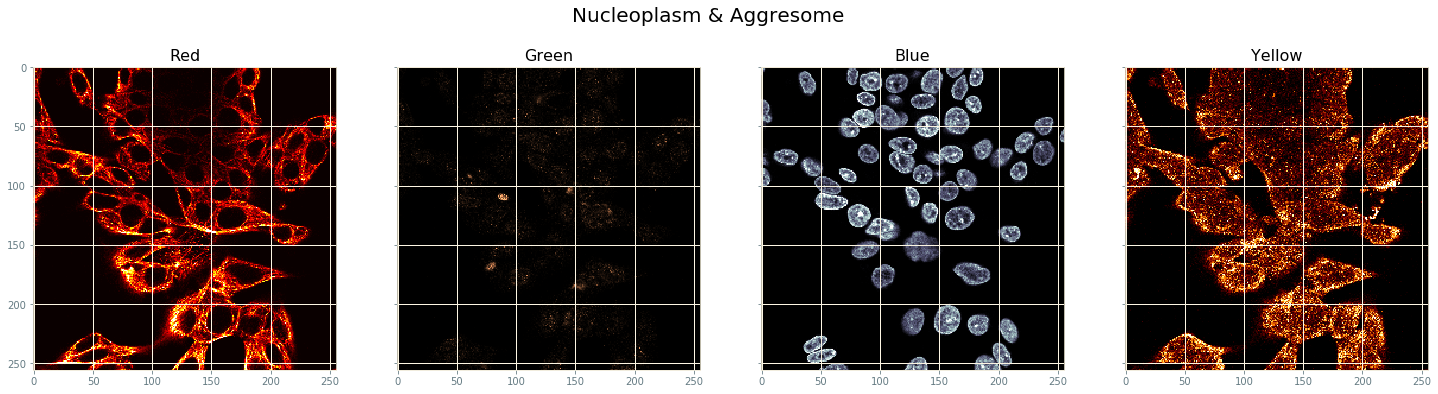

In [22]:
show(images[0], labels[0])

In [23]:
hpa_conv_neural_net = HPA_ConvNeuralNet()

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
print(device)

cuda:0


In [26]:
hpa_conv_neural_net.to(device)

HPA_ConvNeuralNet(
  (conv1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (out1): Linear(in_features=65536, out_features=900, bias=True)
  (out2): Linear(in_features=900, out_features=28, bias=True)
)

In [27]:
criterion=nn.BCEWithLogitsLoss(reduction='sum')
optimizer = optim.Adam(hpa_conv_neural_net.parameters(), lr=0.001, betas=(0.9, 0.99))

In [28]:
torch.cuda.empty_cache()
since = time.time()
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        
        outputs = hpa_conv_neural_net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 200 == 199:
            print("[%d, %5d, loss: %.3f]" % (epoch + 1, i + 1, running_loss / 20.0))
            running_loss = 0.0
            
print("Finished Training")
time_elapsed = time.time() - since
print(
    'Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )
)

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2852, 0.2109, 0.0938,  ..., 0.0000, 0.0000, 0.0000],
          [0.1055, 0.1719, 0.2305,  ..., 0.0000, 0.0039, 0.0000],
          [0.0156, 0.0352, 0.0508,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3555, 0.2266, 0.3008],
          [0.0000, 0.0000, 0.0000,  ..., 0.2891, 0.1445, 0.1875],
          [0.0000, 0.0000, 0.0000,  ..., 0.3398, 0.2070, 0.0664]],

         [[0.2656, 0.1875, 0.1055,  ..., 0.0000, 0.0000, 0.0000],
          [0.0898, 0.2070, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0430, 0.0859,  ..., 0.0000, 0.0000, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2383, 0.2578, 0.2617],
          [0.0000, 0.0000, 0.0000,  ..., 0.2812, 0.3203, 0.1680],
          [0.0000, 0.0000, 0.0000,  ..., 0.3750, 0.2891, 0.2383]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

type(outputs):  <class 'torch.Tensor'>
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.0584, -0.0106,  0.0054,  ...,  0.0130, -0.0724, -0.0077],
        [ 0.0548,  0.0014, -0.0201,  ...,  0.0153, -0.0519,  0.0025],
        [ 0.0324, -0.0164, -0.0541,  ...,  0.0111, -0.0240,  0.0049],
        ...,
        [ 0.0355, -0.0201, -0.0441,  ...,  0.0126, -0.0583,  0.0068],
        [ 0.1050, -0.0041, -0.0245,  ...,  0.0362, -0.0457, -0.0221],
        [ 0.0328, -0.0020, -0.0389,  ...,  0.0278, -0.0438, -0.0137]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)
inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000,

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0273, 0.0312, 0.0273,  ..., 0.0195, 0.0000, 0.0000],
          [0.0820, 0.0391, 0.0234,  ..., 0.0078, 0.0195, 0.0039],
          [0.0312, 0.0117, 0.1016,  ..., 0.0117, 0.0195, 0.0078],
          ...,
          [0.0469, 0.1602, 0.0039,  ..., 0.0117, 0.0000, 0.0312],
          [0.1094, 0.0781, 0.0234,  ..., 0.0547, 0.0000, 0.0625],
          [0.0625, 0.0078, 0.1016,  ..., 0.0039, 0.0156, 0.0078]],

         [[0.0195, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0664,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0469,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0586],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3398, 0.6836, 0.4609],
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.7344, 0.5781],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.4570, 0.3750]],

         [[0.0000, 0.0078, 0.0000,  ..., 0.0312, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0156, 0.0078],
          [0.0352, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.1211, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.1406, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.1406, 0.1602]],

         [[0.0117, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.3477, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.2617],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0156, 0.1523]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0469, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0000, 0.1484]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0547, 0.0469, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0234, 0.1328,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0703, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0547, 0.0977,  ..., 0.0977, 0.0430, 0.0586],
          [0.0234, 0.0195, 0.0234,  ..., 0.0234, 0.0859, 0.0117],
          [0.0000, 0.0391, 0.0469,  ..., 0.0039, 0.0391, 0.0000]],

         [[0.0195, 0.0430, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0820, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0469, 0.1328,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1406, 0.1289, 0.0000,  ..., 0.0000, 0.0273, 0.0078],
          [0.0703, 0.0625, 0.0000,  ..., 0.0000, 0.1523, 0.0000],
          [0.0625, 0.0000, 0.0312,  ..., 0.1016, 0.0000, 0.0391]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0156,  ..., 0.0430, 0.1328, 0.0000],
          [0.0000, 0.0000, 0.0156,  ..., 0.0469, 0.0625, 0.0352],
          [0.0000, 0.0000, 0.0078,  ..., 0.0391, 0.0195, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0352]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3281, 0.0703, 0.5859,  ..., 0.0000, 0.0039, 0.0000],
          [0.1484, 0.9297, 0.5977,  ..., 0.0039, 0.0000, 0.0078],
          [0.3750, 0.8047, 0.1289,  ..., 0.0000, 0.0000, 0.0938],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0352, 0.1094, 0.0039,  ..., 0.1172, 0.0664, 0.1289],
          [0.0859, 0.0977, 0.0742,  ..., 0.4023, 0.1992, 0.1367],
          [0.0273, 0.0430, 0.1172,  ..., 0.1172, 0.0391, 0.0742],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.1055, 0.1016],
          [0.0000, 0.0000, 0.0000,  ..., 0.2227, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2734, 0.0391, 0.0000,  ..., 0.0000, 0.0117, 0.0156],
          [0.0703, 0.0039, 0.0000,  ..., 0.0039, 0.0000, 0.0117],
          [0.0312, 0.0664, 0.0117,  ..., 0.0195, 0.0234, 0.0039],
          ...,
          [0.0469, 0.0234, 0.0078,  ..., 0.0508, 0.0117, 0.0898],
          [0.0430, 0.0625, 0.0039,  ..., 0.0000, 0.0625, 0.0352],
          [0.0156, 0.0000, 0.0000,  ..., 0.0078, 0.0508, 0.1055]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3008, 0.1055, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.2422, 0.3

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0859, 0.4844, 0.4727,  ..., 0.0469, 0.0898, 0.0898],
          [0.0703, 0.6055, 0.1328,  ..., 0.0312, 0.0352, 0.1719],
          [0.1562, 0.3555, 0.0391,  ..., 0.1055, 0.0508, 0.0664],
          ...,
          [0.2500, 0.3320, 0.3477,  ..., 0.2305, 0.0430, 0.2109],
          [0.3906, 0.2539, 0.4102,  ..., 0.0703, 0.1562, 0.0820],
          [0.3828, 0.0312, 0.2461,  ..., 0.1250, 0.3008, 0.2070]],

         [[0.0391, 0.0859, 0.0664,  ..., 0.0117, 0.0391, 0.0312],
          [0.0273, 0.1562, 0.0039,  ..., 0.0312, 0.0352, 0.0547],
          [0.1016, 0.0352, 0.1367,  ..., 0.0078, 0.0312, 0.0586],
          ...,
          [0.1016, 0.0156, 0.0508,  ..., 0.0195, 0.0273, 0.0469],
          [0.0078, 0.1641, 0.0312,  ..., 0.0781, 0.0547, 0.1250],
          [0.1172, 0.0742, 0.0625,  ..., 0.0391, 0.0000, 0.1133]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.2344, 0.3281],
          [0.0000, 0.0000, 0.0000,  ..., 0.3086, 0.1641, 0.2969],
          [0.0000, 0.0000, 0.0000,  ..., 0.1953, 0.3281, 0.3516],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1953, 0.5820, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.2500, 0.2695, 0.1523],
          [0.0000, 0.0000, 0.0000,  ..., 0.1406, 0.2031, 0.1016],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.2656, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0586, 0.0039, 0.1758,  ..., 0.2305, 0.2773, 0.2305],
          [0.0156, 0.1680, 0.0898,  ..., 0.2227, 0.3633, 0.1523],
          [0.0781, 0.0234, 0.0273,  ..., 0.2539, 0.2969, 0.2812],
          ...,
          [0.1094, 0.0195, 0.0234,  ..., 0.0195, 0.1250, 0.2148],
          [0.1953, 0.0664, 0.1328,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0000, 0.0000,  ..., 0.0430, 0.0234, 0.0078]],

         [[0.0000, 0.0000, 0.0508,  ..., 0.0000, 0.0000, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0156],
          [0.0234, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.1094],
          [0.0000, 0.0000, 0.0625,  ..., 0.0859, 0.0000, 0.0078],
          [0.0430, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1875, 0.1719, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0938, 0.0898, 0.1250,  ..., 0.2930, 0.0469, 0.2188],
          [0.0820, 0.0156, 0.0508,  ..., 0.0391, 0.5664, 0.1602],
          [0.0781, 0.0117, 0.0508,  ..., 0.3203, 0.2578, 0.4727],
          ...,
          [0.0039, 0.0234, 0.0117,  ..., 0.0547, 0.0078, 0.0391],
          [0.0391, 0.0156, 0.0195,  ..., 0.0000, 0.0078, 0.0000],
          [0.0391, 0.0586, 0.1680,  ..., 0.0039, 0.0078, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0625, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.0391, 0.4219]],

         [[0.9961, 0.9102, 0.4688,  ..., 0.0000, 0.0000, 0.0000],
          [0.8008, 0.9688, 0.7773,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0273, 0.0273],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0078, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0195],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0312, 0.0391, 0.0156,  ..., 0.0547, 0.0000, 0.0000],
          [0.0430, 0.0586, 0.0469,  ..., 0.0078, 0.0156, 0.0039],
          [0.0312, 0.0352, 0.0039,  ..., 0.0000, 0.0039, 0.0039],
          ...,
          [0.0117, 0.0273, 0.0039,  ..., 0.0078, 0.0195, 0.0039],
          [0.0742, 0.0039, 0.0273,  ..., 0.0312, 0.0078, 0.0117],
          [0.0234, 0.0039, 0.0000,  ..., 0.0586, 0.0000, 0.0664]],

         [[0.0586, 0.1055, 0.0039,  ..., 0.0391, 0.0078, 0.0195],
          [0.0234, 0.0000, 0.0547,  ..., 0.0664, 0.0156, 0.0312],
          [0.0938, 0.1641, 0.0039,  ..., 0.1328, 0.0039, 0.0977],
          ...,
          [0.1406, 0.0273, 0.0000,  ..., 0.0117, 0.0078, 0.0234],
          [0.1562, 0.0391, 0.0195,  ..., 0.0234, 0.0469, 0.0391],
          [0.0000, 0.0273, 0.1016,  ..., 0.0000, 0.0039, 0.0742]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.8086, 0.3008, 0.2305],
          [0.0000, 0.0000, 0.0000,  ..., 0.3008, 0.1914, 0.1406],
          [0.0000, 0.0000, 0.0000,  ..., 0.2109, 0.2305, 0.2031],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.2266, 0.3438, 0.2500,  ..., 0.0000, 0.0000, 0.0000],
          [0.2383, 0.3047, 0.2266,  ..., 0.0078, 0.0000, 0.0000],
          [0.2461, 0.2344, 0.2773,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0156, 0.0039, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2461, 0.2031, 0.1133,  ..., 0.2031, 0.3984, 0.1172],
          [0.4609, 0.1016, 0.1641,  ..., 0.0938, 0.2930, 0.1289],
          [0.1953, 0.3789, 0.0469,  ..., 0.1719, 0.0391, 0.0312],
          ...,
          [0.0234, 0.0000, 0.0312,  ..., 0.0195, 0.9961, 0.0078],
          [0.0000, 0.0781, 0.1016,  ..., 0.2031, 0.5508, 0.0000],
          [0.0078, 0.0156, 0.0273,  ..., 0.5312, 0.0000, 0.0000]],

         [[0.3672, 0.1680, 0.0820,  ..., 0.1602, 0.2852, 0.0938],
          [0.1641, 0.0391, 0.0586,  ..., 0.1562, 0.2422, 0.0742],
          [0.0859, 0.0938, 0.0703,  ..., 0.1055, 0.1797, 0.0977],
          ...,
          [0.0859, 0.1094, 0.1680,  ..., 0.0000, 0.0000, 0.0664],
          [0.0781, 0.3047, 0.1328,  ..., 0.0625, 0.3047, 0.0156],
          [0.2930, 0.1562, 0.0430,  ..., 0.0898, 0.0117, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2070, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2109, 0.2227, 0.3555,  ..., 0.0352, 0.0430, 0.0273],
          [0.4062, 0.1406, 0.3750,  ..., 0.0273, 0.0234, 0.0391],
          [0.2812, 0.2773, 0.4805,  ..., 0.0352, 0.0508, 0.1875],
          ...,
          [0.0273, 0.0000, 0.0000,  ..., 0.0273, 0.0039, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0430, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0117, 0.0078]],

         [[0.1406, 0.0508, 0.0586,  ..., 0.0273, 0.0156, 0.0820],
          [0.0312, 0.0117, 0.0430,  ..., 0.0586, 0.0781, 0.0703],
          [0.0430, 0.0039, 0.1289,  ..., 0.0391, 0.1719, 0.0312],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0000,  ..., 0.0156, 0.0039, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1445, 0.0664, 0.1406],
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.1

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1562, 0.0859, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.1602, 0.0781, 0.0547,  ..., 0.0039, 0.0000, 0.0039],
          [0.1016, 0.1016, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0312, 0.0430, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.2891, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.4062, 0.1602],
          [0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.3438, 0.2852],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1719, 0.1250, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.1328, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0195, 0.1133]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2344, 0.0430, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.2461, 0.3242],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0156, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0508, 0.0898],
          [0.0273, 0.0000, 0.0000,  ..., 0.0000, 0.1016, 0.1406]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.1523, 0.1758],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1172, 0.2578, 0.0703,  ..., 0.0039, 0.0117, 0.0391],
          [0.1719, 0.3242, 0.1875,  ..., 0.0508, 0.0117, 0.0938],
          [0.1016, 0.0312, 0.0469,  ..., 0.0195, 0.0391, 0.0781],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.2969, 0.4922],
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.3516, 0.3945],
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.4062, 0.1836]],

         [[0.0078, 0.0117, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0312, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0039, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0000, 0.0352]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.0156, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.0352, 0.1328],
          [0.0000, 0.0000, 0.0039,  ..., 0.0547, 0.0000, 0.0273],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0977, 0.1680, 0.1211,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.3867, 0.1523,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.2031, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0078, 0.0117,  ..., 0.0312, 0.3438, 0.1836],
          [0.0156, 0.0117, 0.0391,  ..., 0.2773, 0.3008, 0.9375],
          [0.0039, 0.0000, 0.0156,  ..., 0.3359, 0.6680, 0.5195]],

         [[0.1172, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0000, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0078, 0.0000,  ..., 0.1133, 0.0469, 0.0273],
          [0.0117, 0.0000, 0.0352,  ..., 0.4297, 0.1562, 0.1367],
          [0.0000, 0.0000, 0.0078,  ..., 0.0195, 0.0000, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2422, 0.1367, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0469, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0859, 0.0664, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.1172, 0.0586, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.1523, 0.0508, 0.0547,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0039, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.1758, 0.1680, 0.2617,  ..., 0.0000, 0.0000, 0.0000],
          [0.1523, 0.1875, 0.1406,  ..., 0.0000, 0.0000, 0.0000],
          [0.1406, 0.1289, 0.1250,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0469, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.0117, 0.0000],
          ...,
          [0.0664, 0.2344, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.3867, 0.0000, 0.4727,  ..., 0.0000, 0.0000, 0.0000],
          [0.2734, 0.0234, 0.1562,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0312, 0.0156],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0273, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0078, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0352, 0.1289]],

         [[0.1992, 0.0586, 0.1094,  ..., 0.0000, 0.0000, 0.0000],
          [0.2969, 0.0469, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.4023, 0.0977, 0.1836,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0625, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0430, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0117, 0.0273]],

         [[0.3945, 0.4883, 0.3477,  ..., 0.0000, 0.0000, 0.0000],
          [0.2930, 0.5000, 0.3125,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0273, 0.0273, 0.0156,  ..., 0.1719, 0.2266, 0.2188],
          [0.0586, 0.0234, 0.0000,  ..., 0.2266, 0.3203, 0.1289],
          [0.0234, 0.0156, 0.0000,  ..., 0.3086, 0.1797, 0.3438],
          ...,
          [0.0000, 0.0078, 0.0117,  ..., 0.1094, 0.0547, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0156, 0.0352, 0.0898],
          [0.0156, 0.0039, 0.0156,  ..., 0.0039, 0.1016, 0.0000]],

         [[0.0156, 0.0078, 0.0117,  ..., 0.0039, 0.0039, 0.0117],
          [0.0195, 0.0273, 0.0000,  ..., 0.0117, 0.0078, 0.0000],
          [0.0273, 0.0000, 0.0391,  ..., 0.0117, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0234,  ..., 0.0312, 0.0391, 0.0195],
          [0.0234, 0.0391, 0.0391,  ..., 0.0547, 0.0234, 0.0117],
          [0.0078, 0.0000, 0.0117,  ..., 0.0312, 0.0195, 0.0078]],

         [[0.9141, 0.9961, 0.9961,  ..., 0.0000, 0.0000, 0.0000],
          [0.9297, 0.9961, 0.9961,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0352, 0.0234, 0.0273,  ..., 0.0117, 0.0000, 0.0000],
          [0.0391, 0.0781, 0.0195,  ..., 0.0039, 0.0000, 0.0000],
          [0.1406, 0.0898, 0.0352,  ..., 0.0000, 0.0000, 0.0273],
          ...,
          [0.0078, 0.0078, 0.0000,  ..., 0.0156, 0.0000, 0.0000],
          [0.0117, 0.0234, 0.0000,  ..., 0.0312, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000]],

         [[0.0703, 0.0469, 0.0859,  ..., 0.0078, 0.0000, 0.0078],
          [0.0391, 0.0273, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0156, 0.0000]],

         [[0.0156, 0.0039, 0.0039,  ..., 0.4062, 0.5742, 0.2227],
          [0.0117, 0.0000, 0.0000,  ..., 0.3320, 0.4

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0078,  ..., 0.0078, 0.0195, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1680, 0.2344, 0.1680,  ..., 0.0000, 0.0000, 0.0000],
          [0.1641, 0.2227, 0.6719,  ..., 0.0000, 0.0000, 0.0000],
          [0.1602, 0.2031, 0.3633,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1758, 0.1328, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.1211, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.1172, 0.0938,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0977, 0.2109, 0.2422,  ..., 0.3320, 0.7266, 0.5625],
          [0.3125, 0.2969, 0.0820,  ..., 0.2305, 0.5781, 0.5703],
          [0.1211, 0.3594, 0.2109,  ..., 0.5078, 0.2188, 0.2266],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1875, 0.0703, 0.0859],
          [0.0000, 0.0078, 0.0000,  ..., 0.0586, 0.2031, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.1094, 0.1797, 0.0625]],

         [[0.1406, 0.0234, 0.2656,  ..., 0.0273, 0.3086, 0.0703],
          [0.0742, 0.0156, 0.1133,  ..., 0.1250, 0.0664, 0.1094],
          [0.0977, 0.0742, 0.0039,  ..., 0.1641, 0.0898, 0.0195],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.1289, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.1641, 0.0352, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.1875, 0.2266]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0430, 0.0273, 0.0938,  ..., 0.1133, 0.3672, 0.0430],
          [0.0703, 0.0469, 0.0312,  ..., 0.3438, 0.5352, 0.2812],
          [0.0977, 0.0859, 0.0508,  ..., 0.1250, 0.2305, 0.5391],
          ...,
          [0.2891, 0.3516, 0.5039,  ..., 0.0000, 0.0000, 0.0000],
          [0.4336, 0.0859, 0.1602,  ..., 0.0000, 0.0000, 0.0000],
          [0.6211, 0.1211, 0.1406,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0117, 0.0039, 0.0195,  ..., 0.0273, 0.0312, 0.0273],
          [0.0195, 0.0078, 0.0391,  ..., 0.0859, 0.0273, 0.0156],
          [0.0156, 0.0352, 0.0117,  ..., 0.0391, 0.0156, 0.0547],
          ...,
          [0.3359, 0.3945, 0.4180,  ..., 0.0000, 0.0000, 0.0000],
          [0.5039, 0.3945, 0.2539,  ..., 0.0000, 0.0000, 0.0000],
          [0.4102, 0.4805, 0.6719,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0938, 0.2773, 0.4688,  ..., 0.0469, 0.0195, 0.0547],
          [0.3828, 0.4258, 0.3125,  ..., 0.0117, 0.0508, 0.0508],
          [0.0742, 0.3672, 0.0078,  ..., 0.0547, 0.0430, 0.0391],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1797, 0.1953, 0.8008],
          [0.0000, 0.0000, 0.0000,  ..., 0.1719, 0.6445, 0.3555],
          [0.0000, 0.0000, 0.0000,  ..., 0.1992, 0.4844, 0.1797]],

         [[0.0312, 0.0430, 0.0352,  ..., 0.1406, 0.0977, 0.0312],
          [0.0195, 0.0000, 0.0586,  ..., 0.0820, 0.0547, 0.0039],
          [0.0312, 0.0000, 0.0000,  ..., 0.1172, 0.3320, 0.0391],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0508, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0508, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.1211, 0.0352]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0742, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2852, 0.2539, 0.3086,  ..., 0.0156, 0.0352, 0.0078],
          [0.1055, 0.2422, 0.9570,  ..., 0.0234, 0.0117, 0.0156],
          [0.2188, 0.9961, 0.8398,  ..., 0.0312, 0.0117, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0195, 0.0234],
          [0.0000, 0.0000, 0.0156,  ..., 0.3984, 0.0781, 0.0156],
          [0.0000, 0.0039, 0.0039,  ..., 0.2891, 0.3320, 0.0391]],

         [[0.1523, 0.0273, 0.1953,  ..., 0.0625, 0.1055, 0.4141],
          [0.0898, 0.0312, 0.0078,  ..., 0.2617, 0.2852, 0.3867],
          [0.0000, 0.0781, 0.0938,  ..., 0.1172, 0.0742, 0.2578],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0547, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0391, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0078]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.3477, 0.4297, 0.4375],
          [0.0234, 0.0000, 0.0000,  ..., 0.3906, 0.5

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1836, 0.1562, 0.1406],
          [0.1133, 0.0312, 0.0000,  ..., 0.0195, 0.1055, 0.1523],
          [0.3438, 0.2383, 0.2344,  ..., 0.0664, 0.0820, 0.4805],
          ...,
          [0.0000, 0.0000, 0.0078,  ..., 0.0078, 0.0156, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0078],
          [0.0000, 0.0156, 0.0156,  ..., 0.0039, 0.0078, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1445, 0.0820, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.3164, 0.0000, 0.0547],
          [0.0000, 0.0195, 0.2148,  ..., 0.0312, 0.0000, 0.1250],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2969, 0.2617, 0.1133],
          [0.0312, 0.0352, 0.0078,  ..., 0.2617, 0.1719, 0.0273],
          [0.0352, 0.0469, 0.0469,  ..., 0.0273, 0.0938, 0.1914]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.4531, 0.3477, 0.2656],
          [0.0000, 0.0000, 0.0000,  ..., 0.3906, 0.4

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0234, 0.0781,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0117,  ..., 0.0273, 0.0039, 0.0312],
          [0.0000, 0.0078, 0.0000,  ..., 0.0039, 0.0273, 0.0000],
          ...,
          [0.3281, 0.2070, 0.1289,  ..., 0.0742, 0.3672, 0.1055],
          [0.1367, 0.2344, 0.0273,  ..., 0.2734, 0.4219, 0.4062],
          [0.1797, 0.1094, 0.0469,  ..., 0.1875, 0.4219, 0.1328]],

         [[0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0117],
          ...,
          [0.0352, 0.0234, 0.0234,  ..., 0.0078, 0.0430, 0.0156],
          [0.0352, 0.0156, 0.0391,  ..., 0.0117, 0.0742, 0.0000],
          [0.0312, 0.0234, 0.0430,  ..., 0.0508, 0.0547, 0.1289]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0430, 0.3008, 0.1328,  ..., 0.2148, 0.2930, 0.0625],
          [0.0117, 0.0625, 0.2930,  ..., 0.4375, 0.2891, 0.0430],
          [0.0469, 0.0547, 0.2305,  ..., 0.2070, 0.1211, 0.1133],
          ...,
          [0.0234, 0.0117, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0312, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0312, 0.0469,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0977, 0.1719, 0.1523,  ..., 0.2930, 0.4961, 0.2539],
          [0.0977, 0.1172, 0.1680,  ..., 0.3008, 0.2617, 0.2969],
          [0.0703, 0.0625, 0.1484,  ..., 0.3047, 0.2500, 0.1016],
          ...,
          [0.0039, 0.0156, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0430, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.5742, 0.3359, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.8477, 0.7500, 0.0781,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.2539, 0.0078, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0938, 0.2773],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0273, 0.0312],
          ...,
          [0.0156, 0.0078, 0.0000,  ..., 0.2266, 0.1250, 0.1680],
          [0.0352, 0.0000, 0.0078,  ..., 0.1328, 0.1562, 0.2266],
          [0.2266, 0.0156, 0.0000,  ..., 0.1641, 0.3125, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0820, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0781, 0.1328],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0703, 0.0781],
          ...,
          [0.0000, 0.0312, 0.0898,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0039, 0.0000,  ..., 0.0234, 0.0000, 0.0078],
          [0.1289, 0.0352, 0.1406,  ..., 0.0273, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0430, 0.0312],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.9453, 0.5312, 0.6914],
          [0.0039, 0.0000, 0.0039,  ..., 0.3984, 0.9062, 0.7461],
          [0.0000, 0.0117, 0.0000,  ..., 0.3555, 0.4883, 0.9961]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1719, 0.3125, 0.2812],
          [0.0000, 0.0000, 0.0000,  ..., 0.4648, 0.2266, 0.2930],
          [0.0000, 0.0000, 0.0000,  ..., 0.3008, 0.2109, 0.3711],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0859, 0.0156, 0.2539],
          [0.0000, 0.0000, 0.0000,  ..., 0.1602, 0.0586, 0.2891],
          [0.0039, 0.0000, 0.0039,  ..., 0.0742, 0.0742, 0.1367]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2070, 0.1523, 0.1250],
          [0.0000, 0.0000, 0.0000,  ..., 0.1875, 0.1

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0273, 0.0156, 0.0820,  ..., 0.1562, 0.0547, 0.1289],
          [0.0508, 0.0508, 0.0078,  ..., 0.0430, 0.0234, 0.0117],
          [0.1055, 0.0078, 0.0117,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0586, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0234, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.1484, 0.1719, 0.0391]],

         [[0.0430, 0.0430, 0.0938,  ..., 0.0898, 0.2148, 0.0469],
          [0.0000, 0.0117, 0.0469,  ..., 0.0508, 0.0195, 0.0156],
          [0.0156, 0.0078, 0.0078,  ..., 0.0312, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.0469, 0.1445],
          [0.0078, 0.0000, 0.0000,  ..., 0.1289, 0.0781, 0.0820],
          [0.0000, 0.0000, 0.0000,  ..., 0.1094, 0.1094, 0.1328]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0352, 0.0430, 0.1836,  ..., 0.0430, 0.2617, 0.0117],
          [0.1133, 0.0898, 0.1875,  ..., 0.0547, 0.0430, 0.0000],
          [0.0859, 0.1211, 0.2227,  ..., 0.0469, 0.0078, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0469, 0.0078, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0117, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.1367, 0.0391, 0.0273]],

         [[0.0703, 0.0352, 0.1016,  ..., 0.2578, 0.3359, 0.1523],
          [0.0195, 0.0586, 0.0859,  ..., 0.1289, 0.1133, 0.3438],
          [0.0312, 0.0156, 0.0430,  ..., 0.2852, 0.0742, 0.2148],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0234, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0703, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.1250, 0.0156, 0.0352]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1289, 0.1719, 0.2305],
          [0.0000, 0.0000, 0.0000,  ..., 0.2656, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0469, 0.0703, 0.1445,  ..., 0.0195, 0.0195, 0.0195],
          [0.4570, 0.1992, 0.0781,  ..., 0.0195, 0.0195, 0.0195],
          [0.8672, 0.1680, 0.1523,  ..., 0.0195, 0.0195, 0.0195],
          ...,
          [0.0547, 0.0391, 0.0391,  ..., 0.0195, 0.0195, 0.0195],
          [0.0430, 0.0547, 0.0312,  ..., 0.0234, 0.0195, 0.0195],
          [0.0391, 0.0273, 0.0312,  ..., 0.0195, 0.0312, 0.0195]],

         [[0.0234, 0.1016, 0.2109,  ..., 0.0000, 0.0000, 0.0000],
          [0.0703, 0.1680, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0703, 0.1602, 0.1367,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0273, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0039,  ..., 0.0000, 0.0039, 0.0000],
          [0.0117, 0.0508, 0.0000,  ..., 0.0156, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2344, 0.1094, 0.1250,  ..., 0.0117, 0.0078, 0.0039],
          [0.1406, 0.2305, 0.1523,  ..., 0.0078, 0.0469, 0.0078],
          [0.0742, 0.2109, 0.1016,  ..., 0.0000, 0.0273, 0.0156],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0273, 0.0938],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0859, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0391, 0.0312]],

         [[0.0625, 0.0000, 0.0312,  ..., 0.0352, 0.0664, 0.0078],
          [0.0000, 0.0352, 0.0938,  ..., 0.0078, 0.1211, 0.0000],
          [0.0781, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.0586, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0273, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0391]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0117, 0.0000,  ..., 0.0234, 0.2383, 0.1055],
          [0.0234, 0.0000, 0.0039,  ..., 0.0625, 0.1367, 0.1953],
          [0.0000, 0.0078, 0.0156,  ..., 0.0430, 0.2656, 0.1094]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0078, 0.0039,  ..., 0.2227, 0.0547, 0.0156],
          [0.0117, 0.0000, 0.0117,  ..., 0.2031, 0.0938, 0.2383],
          [0.0000, 0.0000, 0.0195,  ..., 0.2148, 0.0625, 0.1523]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0391, 0.0352, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0039, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0156, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0820, 0.1016, 0.0078,  ..., 0.0078, 0.0039, 0.0312],
          [0.2422, 0.0508, 0.0742,  ..., 0.0000, 0.0469, 0.0078],
          [0.1367, 0.1016, 0.1289,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.2109, 0.2461, 0.1758,  ..., 0.0039, 0.0000, 0.0000],
          [0.1641, 0.0938, 0.1211,  ..., 0.0000, 0.0000, 0.0000],
          [0.6055, 0.2109, 0.1250,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0234, 0.0000, 0.1133,  ..., 0.1602, 0.0977, 0.2930],
          [0.1250, 0.0000, 0.0117,  ..., 0.0859, 0.2617, 0.1250],
          [0.1680, 0.0664, 0.0703,  ..., 0.3320, 0.0430, 0.0156]],

         [[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0234, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0977, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1211, 0.0469, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2773, 0.2852, 0.1680],
          [0.0000, 0.0000, 0.0000,  ..., 0.3438, 0.2422, 0.1328],
          [0.0000, 0.0000, 0.0000,  ..., 0.2812, 0.2812, 0.3633]],

         [[0.0039, 0.0352, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.1172, 0.0312, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.1875, 0.2539],
          [0.0000, 0.0000, 0.0000,  ..., 0.3633, 0.1719, 0.3047],
          [0.0000, 0.0000, 0.0000,  ..., 0.2500, 0.1641, 0.1523]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3164, 0.1484, 0.4805,  ..., 0.0469, 0.1367, 0.0586],
          [0.3125, 0.3086, 0.2461,  ..., 0.0234, 0.3359, 0.0898],
          [0.1719, 0.3125, 0.5195,  ..., 0.0742, 0.1719, 0.0742],
          ...,
          [0.2891, 0.1250, 0.1836,  ..., 0.1797, 0.0469, 0.0039],
          [0.1914, 0.3828, 0.6484,  ..., 0.1328, 0.0859, 0.1367],
          [0.1133, 0.2500, 0.5664,  ..., 0.1016, 0.1133, 0.1133]],

         [[0.1055, 0.0469, 0.1211,  ..., 0.1875, 0.0703, 0.1172],
          [0.1094, 0.1055, 0.0625,  ..., 0.0000, 0.0273, 0.0586],
          [0.0781, 0.3555, 0.2617,  ..., 0.0586, 0.0508, 0.0508],
          ...,
          [0.0195, 0.0195, 0.0742,  ..., 0.2266, 0.0820, 0.1758],
          [0.0547, 0.0703, 0.2422,  ..., 0.0430, 0.0703, 0.0625],
          [0.0430, 0.0938, 0.1016,  ..., 0.0430, 0.0312, 0.0391]],

         [[0.0078, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.2852,  ..., 0.0000, 0.0000, 0.0000],
          [0.1055, 0.1719, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0391, 0.0742,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0898, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0000, 0.0234,  ..., 0.1094, 0.2344, 0.3594],
          [0.0000, 0.0000, 0.0039,  ..., 0.3359, 0.0898, 0.2305],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.1797, 0.2578],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0234, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0273, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0234, 0.0430]],

         [[0.0078, 0.0273, 0.0195,  ..., 0.0859, 0.0039, 0.0273],
          [0.0000, 0.0000, 0.0078,  ..., 0.1328, 0.0273, 0.0469],
          [0.0000, 0.0156, 0.0039,  ..., 0.0078, 0.1016, 0.0391],
          ...,
          [0.0195, 0.0078, 0.0000,  ..., 0.3086, 0.5156, 0.1836],
          [0.0234, 0.0117, 0.0039,  ..., 0.2969, 0.7344, 0.4297],
          [0.0195, 0.0156, 0.0000,  ..., 0.3867, 0.5469, 0.3945]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0469, 0.0703, 0.0039,  ..., 0.0000, 0.0039, 0.0000],
          [0.1133, 0.0586, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.1289, 0.0742, 0.0117,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.2383, 0.1055, 0.1172],
          [0.0039, 0.0000, 0.0000,  ..., 0.0977, 0.1094, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.5273, 0.1289, 0.0312]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2891, 0.0508, 0.0195,  ..., 0.0508, 0.0273, 0.0352],
          [0.0234, 0.1836, 0.0859,  ..., 0.0156, 0.0352, 0.0430],
          [0.0430, 0.0469, 0.1328,  ..., 0.0273, 0.0273, 0.0547],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1602, 0.0352, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.0352, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0273, 0.0547]],

         [[0.0039, 0.0312, 0.0000,  ..., 0.0000, 0.0391, 0.0000],
          [0.0000, 0.0625, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1133, 0.0156, 0.2227,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3281, 0.4414, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.6172, 0.6875, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.3594, 0.1914, 0.2305]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0430, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0117, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.1523],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0586, 0.1758],
          [0.0039, 0.0078, 0.0156,  ..., 0.0000, 0.0234, 0.1133],
          ...,
          [0.0039, 0.0234, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0117, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0352, 0.0547,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0508],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0547, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1016, 0.0469],
          ...,
          [0.1094, 0.0508, 0.0664,  ..., 0.0000, 0.0078, 0.0000],
          [0.0742, 0.1289, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0586, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1641, 0.0156, 0.0977,  ..., 0.3398, 0.4023, 0.2422],
          [0.1719, 0.1250, 0.1562,  ..., 0.1406, 0.2695, 0.1055],
          [0.1719, 0.6367, 0.1367,  ..., 0.2109, 0.2344, 0.5625],
          ...,
          [0.0547, 0.0352, 0.0234,  ..., 0.0000, 0.0078, 0.0000],
          [0.0391, 0.1016, 0.2070,  ..., 0.0156, 0.0000, 0.0117],
          [0.1211, 0.1289, 0.1211,  ..., 0.0352, 0.0312, 0.0078]],

         [[0.0312, 0.0117, 0.0000,  ..., 0.0000, 0.2227, 0.0000],
          [0.0273, 0.0000, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0078,  ..., 0.0039, 0.4297, 0.0000],
          ...,
          [0.0000, 0.0195, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0039],
          ...,
          [0.0000, 0.0117, 0.0195,  ..., 0.0039, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0078, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0078, 0.0234,  ..., 0.0625, 0.0117, 0.0312],
          [0.0000, 0.0273, 0.0000,  ..., 0.0117, 0.0078, 0.0078],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0195,  ..., 0.0039, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0352, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0156, 0.0078, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0352, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.4727, 0.6406],
          [0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.6523, 0.1680],
          [0.0000, 0.0000, 0.0000,  ..., 0.3359, 0.2812, 0.1406],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1406, 0.1758, 0.0352],
          [0.0039, 0.0000, 0.0000,  ..., 0.1289, 0.2266, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.3008, 0.0352, 0.1055]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0000, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3320, 0.2266, 0.3164,  ..., 0.5078, 0.1992, 0.1953],
          [0.2500, 0.6680, 0.2969,  ..., 0.0898, 0.2422, 0.5156],
          [0.1172, 0.1523, 0.3086,  ..., 0.3594, 0.1758, 0.1484],
          ...,
          [0.5664, 0.3633, 0.5820,  ..., 0.0000, 0.0469, 0.0781],
          [0.4297, 0.7031, 0.8438,  ..., 0.0273, 0.0039, 0.0000],
          [0.0117, 0.0430, 0.0898,  ..., 0.0664, 0.0000, 0.0000]],

         [[0.1211, 0.0625, 0.0742,  ..., 0.1133, 0.0859, 0.1797],
          [0.0508, 0.0000, 0.1641,  ..., 0.1523, 0.0820, 0.0117],
          [0.0742, 0.0664, 0.0625,  ..., 0.4766, 0.0547, 0.0195],
          ...,
          [0.0000, 0.0000, 0.1680,  ..., 0.0000, 0.0156, 0.0000],
          [0.0039, 0.0469, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1133, 0.0859, 0.3438,  ..., 0.0430, 0.0820, 0.0469]],

         [[0.2344, 0.1562, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3633, 0.3438, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0547, 0.0312, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0469, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0156, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.5312, 0.3594, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.2070, 0.2969, 0.2500],
          [0.0000, 0.0000, 0.0000,  ..., 0.3047, 0.3008, 0.2852],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0352, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0508, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0547, 0.0352],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.2578, 0.0352, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.2773, 0.0273, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0234, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1523, 0.1289, 0.1094],
          [0.0000, 0.0000, 0.0000,  ..., 0.2695, 0.1055, 0.1836],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.1914, 0.0664]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.0391],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0781, 0.1211],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.1289, 0.1602],
          [0.0000, 0.0000, 0.0000,  ..., 0.1953, 0.1328, 0.0352]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.1055, 0.1680],
          [0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.0898, 0.1445],
          [0.0000, 0.0000, 0.0000,  ..., 0.5391, 0.1641, 0.0586],
          ...,
          [0.0039, 0.0117, 0.0469,  ..., 0.9961, 0.2266, 0.0039],
          [0.0078, 0.0078, 0.0156,  ..., 0.6055, 0.5039, 0.6016],
          [0.0391, 0.0156, 0.0273,  ..., 0.4609, 0.6641, 0.3906]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0039],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0781, 0.0195],
          ...,
          [0.5820, 0.2227, 0.6172,  ..., 0.2695, 0.0000, 0.0000],
          [0.2539, 0.2891, 0.1250,  ..., 0.0273, 0.0820, 0.0039],
          [0.5703, 0.1133, 0.2461,  ..., 0.1133, 0.0898, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.1133, 0.0625,  ..., 0.0000, 0.0039, 0.0352],
          [0.0703, 0.0547, 0.0469,  ..., 0.0156, 0.0000, 0.0000],
          [0.0938, 0.0820, 0.1289,  ..., 0.0273, 0.0117, 0.0547],
          ...,
          [0.0000, 0.0000, 0.0195,  ..., 0.1797, 0.1367, 0.1562],
          [0.0000, 0.0000, 0.0195,  ..., 0.4141, 0.0352, 0.1016],
          [0.0078, 0.0000, 0.0078,  ..., 0.0234, 0.1094, 0.1914]],

         [[0.8516, 0.1875, 0.1797,  ..., 0.0039, 0.0000, 0.0156],
          [0.5078, 0.5117, 0.5586,  ..., 0.0312, 0.0117, 0.1602],
          [0.6797, 0.3047, 0.3086,  ..., 0.1172, 0.0000, 0.0312],
          ...,
          [0.0586, 0.1211, 0.1602,  ..., 0.5273, 0.2695, 0.3867],
          [0.0625, 0.0547, 0.0977,  ..., 0.2656, 0.0586, 0.1172],
          [0.0508, 0.0117, 0.0352,  ..., 0.1289, 0.1406, 0.1719]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3242, 0.3711, 0.4922],
          [0.0000, 0.0000, 0.0000,  ..., 0.4531, 0.4

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.0234, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0586, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0508, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3125, 0.2852, 0.2734],
          [0.0000, 0.0000, 0.0000,  ..., 0.2422, 0.2227, 0.2031],
          [0.0000, 0.0000, 0.0000,  ..., 0.3359, 0.1992, 0.4570]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0664, 0.0859, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0859, 0.0586, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0898, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0352, 0.2656, 0.1055,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0391, 0.6484,  ..., 0.0000, 0.0000, 0.0000],
          [0.1055, 0.0156, 0.3555,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0156, 0.0391, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0742, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0977, 0.0742, 0.0703,  ..., 0.0000, 0.0000, 0.0078],
          ...,
          [0.0352, 0.1719, 0.1133,  ..., 0.0000, 0.0000, 0.0000],
          [0.2812, 0.1484, 0.2383,  ..., 0.0000, 0.0000, 0.0000],
          [0.4102, 0.6016, 0.2344,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0234, 0.0312,  ..., 0.3203, 0.1250, 0.0547],
          [0.0039, 0.0625, 0.0234,  ..., 0.1562, 0.3320, 0.0195],
          [0.0195, 0.0391, 0.0391,  ..., 0.1641, 0.2227, 0.0781]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0352],
          [0.0000, 0.0000, 0.0312,  ..., 0.0234, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0156,  ..., 0.0195, 0.0000, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0820, 0.0469, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0352, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0781, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0586, 0.0234, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0742, 0.0000, 0.0234,  ..., 0.0000, 0.0469, 0.0000],
          [0.0352, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1484, 0.0391, 0.0000,  ..., 0.1211, 0.1680, 0.1406],
          [0.0469, 0.2070, 0.0430,  ..., 0.0781, 0.0820, 0.2617],
          [0.0078, 0.0664, 0.1602,  ..., 0.0977, 0.1250, 0.0898],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0039, 0.0156,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0195, 0.0078, 0.0000,  ..., 0.2383, 0.2031, 0.0781],
          [0.0664, 0.0430, 0.0039,  ..., 0.1328, 0.1172, 0.1719],
          [0.1406, 0.1055, 0.0469,  ..., 0.0781, 0.1055, 0.0938],
          ...,
          [0.1797, 0.2422, 0.1562,  ..., 0.0000, 0.0000, 0.0000],
          [0.1133, 0.1953, 0.2148,  ..., 0.0000, 0.0000, 0.0000],
          [0.1328, 0.1367, 0.1992,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1016, 0.0234, 0.0039,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1797, 0.1719, 0.1992],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0703, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0039, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0156,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.4141, 0.1992,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2383, 0.1562, 0.3086,  ..., 0.0000, 0.0000, 0.0000],
          [0.2969, 0.3047, 0.4531,  ..., 0.0000, 0.0000, 0.0000],
          [0.2617, 0.1719, 0.2148,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1250, 0.0664, 0.0703,  ..., 0.2422, 0.1602, 0.1680],
          [0.1016, 0.1953, 0.0898,  ..., 0.1953, 0.0664, 0.0312],
          [0.1484, 0.1211, 0.2969,  ..., 0.1836, 0.0977, 0.1875]],

         [[0.0547, 0.0586, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.1133, 0.0781, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0000, 0.1055,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0820, 0.2070, 0.4688,  ..., 0.0117, 0.0078, 0.0703],
          [0.1602, 0.1094, 0.1914,  ..., 0.0156, 0.0781, 0.3672],
          [0.1484, 0.1680, 0.0898,  ..., 0.0391, 0.0547, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2266, 0.0234, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0547, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.0820, 0.0312]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1328, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0898, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0977, 0.1250, 0.3711,  ..., 0.0000, 0.0000, 0.0000],
          [0.3789, 0.2305, 0.1602,  ..., 0.0000, 0.0000, 0.0000],
          [0.2188, 0.0352, 0.0273,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1055, 0.0039, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0586, 0.0430,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1875, 0.1289, 0.0859,  ..., 0.0898, 0.0859, 0.1523],
          [0.1016, 0.0352, 0.1250,  ..., 0.4727, 0.1289, 0.1250],
          [0.0664, 0.3828, 0.0938,  ..., 0.1445, 0.1406, 0.0781],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1875, 0.0000, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.1992, 0.0469, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.1953, 0.0000, 0.0039]],

         [[0.0469, 0.0039, 0.0078,  ..., 0.0039, 0.0039, 0.0000],
          [0.0078, 0.0078, 0.0156,  ..., 0.0078, 0.0000, 0.0586],
          [0.0000, 0.0430, 0.0078,  ..., 0.0391, 0.0078, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1836, 0.1562, 0.1562],
          [0.0000, 0.0000, 0.0000,  ..., 0.1992, 0.3320, 0.2266],
          [0.0000, 0.0000, 0.0000,  ..., 0.2031, 0.2812, 0.1328]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0078, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0742, 0.0000],
          ...,
          [0.0156, 0.0273, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0547, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0352, 0.0664,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0078],
          ...,
          [0.0273, 0.0469, 0.0859,  ..., 0.0352, 0.0156, 0.0000],
          [0.0508, 0.0508, 0.1094,  ..., 0.0156, 0.0000, 0.0156],
          [0.0273, 0.0820, 0.0312,  ..., 0.0000, 0.0039, 0.0000]],

         [[0.0234, 0.0000, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0156, 0.0156,  ..., 0.0000, 0.0039, 0.0039],
          [0.0195, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0586, 0.0547, 0.1562,  ..., 0.0938, 0.0781, 0.0391],
          [0.1055, 0.2188, 0.0547,  ..., 0.0977, 0.1641, 0.0898],
          [0.2812, 0.1250, 0.0820,  ..., 0.1719, 0.0312, 0.1328]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.4102, 0.7930, 0.5391,  ..., 0.0000, 0.0078, 0.0039],
          [0.4883, 0.7227, 0.6719,  ..., 0.0039, 0.0000, 0.0039],
          [0.7070, 0.7383, 0.8906,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0078, 0.1602, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.1016, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0234, 0.1016, 0.0703,  ..., 0.0000, 0.0000, 0.0156],
          [0.0508, 0.0781, 0.0312,  ..., 0.0430, 0.0000, 0.0156],
          [0.0547, 0.0000, 0.0156,  ..., 0.0117, 0.0078, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0742, 0.0000, 0.0156,  ..., 0.0000, 0.0234, 0.0000],
          [0.0000, 0.0000, 0.0469,  ..., 0.0000, 0.0195, 0.0195],
          [0.0352, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0156, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0430, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0000, 0.1211]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2422, 0.2305, 0.1680],
          [0.0000, 0.0000, 0.0000,  ..., 0.2148, 0.1992, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.1836, 0.4570, 0.1562],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.4258, 0.3984, 0.4062],
          [0.0000, 0.0000, 0.0000,  ..., 0.3281, 0.3

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0195, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0469, 0.2148,  ..., 0.0703, 0.0352, 0.0508],
          [0.0273, 0.0430, 0.0938,  ..., 0.0430, 0.0156, 0.0352],
          [0.0156, 0.0391, 0.0273,  ..., 0.0391, 0.0312, 0.0117]],

         [[0.3125, 0.5000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0703, 0.1094, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0195, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0273, 0.0820,  ..., 0.0156, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0234,  ..., 0.0000, 0.0156, 0.0234],
          [0.0352, 0.0352, 0.0000,  ..., 0.0781, 0.0000, 0.0000]],

         [[0.2305, 0.2461, 0.1914,  ..., 0.0000, 0.0000, 0.0000],
          [0.5156, 0.3125, 0.0352,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0625, 0.1055, 0.0625,  ..., 0.1172, 0.1602, 0.2930],
          [0.0352, 0.0156, 0.0000,  ..., 0.0938, 0.1484, 0.0977],
          [0.1367, 0.1680, 0.0039,  ..., 0.1406, 0.0430, 0.0430],
          ...,
          [0.0977, 0.0742, 0.1562,  ..., 0.0000, 0.0000, 0.0000],
          [0.1094, 0.2188, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          [0.3555, 0.4727, 0.2188,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1719, 0.0977, 0.0312,  ..., 0.0781, 0.0000, 0.0898],
          [0.2227, 0.0000, 0.0391,  ..., 0.2578, 0.0664, 0.0000],
          [0.0508, 0.0352, 0.0000,  ..., 0.0312, 0.0273, 0.3516],
          ...,
          [0.1211, 0.0000, 0.0898,  ..., 0.0000, 0.0000, 0.0000],
          [0.3047, 0.1289, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.1211, 0.1797, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0117, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0352, 0.0000],
          ...,
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0117, 0.0039, 0.0195,  ..., 0.0312, 0.0039, 0.0352],
          [0.0273, 0.0000, 0.0156,  ..., 0.0469, 0.0273, 0.0000],
          [0.0273, 0.0625, 0.0195,  ..., 0.0000, 0.0000, 0.0117],
          ...,
          [0.0586, 0.0859, 0.1094,  ..., 0.0859, 0.1289, 0.1172],
          [0.0586, 0.0664, 0.0273,  ..., 0.1055, 0.1055, 0.0898],
          [0.1406, 0.1289, 0.0508,  ..., 0.0430, 0.0859, 0.0820]],

         [[0.0000, 0.0078, 0.0000,  ..., 0.0391, 0.0312, 0.0234],
          [0.0273, 0.0195, 0.0117,  ..., 0.0273, 0.0508, 0.0234],
          [0.0039, 0.0352, 0.0156,  ..., 0.0234, 0.0312, 0.0195],
          ...,
          [0.1484, 0.2266, 0.2656,  ..., 0.0547, 0.0547, 0.0273],
          [0.0703, 0.0938, 0.0625,  ..., 0.0508, 0.0898, 0.0352],
          [0.1953, 0.1289, 0.0469,  ..., 0.0195, 0.0352, 0.0352]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.1367],
          [0.0156, 0.0000, 0.0000,  ..., 0.0273, 0.0625, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0000],
          ...,
          [0.0000, 0.1953, 0.0039,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.1250, 0.0703,  ..., 0.0195, 0.0664, 0.0039],
          [0.0000, 0.0234, 0.0898,  ..., 0.0234, 0.0000, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0156, 0.0234, 0.0703,  ..., 0.0078, 0.0000, 0.0000],
          [0.0039, 0.0469, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0312, 0.0312,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.4023, 0.3164, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0664, 0.3086,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0234, 0.0078, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1484, 0.0312, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.1484, 0.1992,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0625, 0.1367,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0391, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0000, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0547,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0508, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1641, 0.1836, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0156,  ..., 0.7695, 0.5391, 0.5820],
          [0.0000, 0.0000, 0.0000,  ..., 0.3672, 0.9453, 0.4219],
          [0.0000, 0.0000, 0.0000,  ..., 0.6602, 0.5703, 0.8359],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3164, 0.1914, 0.1094],
          [0.0000, 0.0000, 0.0000,  ..., 0.6719, 0.1836, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.6055, 0.1797, 0.1172],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1797, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.3164, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0664, 0.0703, 0.0664,  ..., 0.0273, 0.1875, 0.2734],
          [0.1445, 0.0430, 0.0938,  ..., 0.0352, 0.0820, 0.3086],
          [0.1523, 0.0703, 0.1172,  ..., 0.0586, 0.1289, 0.3945],
          ...,
          [0.3281, 0.2461, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0977, 0.0703, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.1094, 0.0078, 0.0742,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0273, 0.0703, 0.0039,  ..., 0.0117, 0.0430, 0.0469],
          [0.0117, 0.0391, 0.0117,  ..., 0.0078, 0.0117, 0.0664],
          [0.0078, 0.0039, 0.0195,  ..., 0.0273, 0.0391, 0.0312],
          ...,
          [0.0312, 0.0078, 0.0000,  ..., 0.0117, 0.0312, 0.0000],
          [0.0469, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0078],
          [0.0273, 0.0352, 0.0508,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0156, 0.0234, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0039, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.5547, 0.4883, 0.5625,  ..., 0.0000, 0.0000, 0.0000],
          [0.7891, 0.8125, 0.5234,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0039,  ..., 0.0625, 0.0508, 0.0273],
          [0.0000, 0.0000, 0.0039,  ..., 0.0977, 0.0508, 0.0234],
          [0.0000, 0.0039, 0.0000,  ..., 0.1602, 0.0977, 0.0469],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.1016, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.1406, 0.0781, 0.1055],
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.1250, 0.1094]],

         [[0.0000, 0.0000, 0.0117,  ..., 0.8750, 0.6641, 0.5312],
          [0.0000, 0.0000, 0.0312,  ..., 0.7344, 0.6289, 0.1133],
          [0.0000, 0.0000, 0.0195,  ..., 0.7734, 0.2305, 0.3438],
          ...,
          [0.0430, 0.0000, 0.0000,  ..., 0.6758, 0.4297, 0.8906],
          [0.0000, 0.0000, 0.0000,  ..., 0.9961, 0.9180, 0.5508],
          [0.0000, 0.0859, 0.0352,  ..., 0.2148, 0.1211, 0.1133]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3516, 0.1641, 0.2383,  ..., 0.0000, 0.0000, 0.0039],
          [0.4570, 0.1797, 0.2031,  ..., 0.0039, 0.0039, 0.0039],
          [0.0898, 0.2109, 0.2422,  ..., 0.0000, 0.0078, 0.0078],
          ...,
          [0.0195, 0.0703, 0.0820,  ..., 0.0625, 0.0977, 0.0820],
          [0.0781, 0.0664, 0.0859,  ..., 0.0312, 0.0703, 0.1250],
          [0.1094, 0.0703, 0.1172,  ..., 0.0586, 0.1016, 0.0625]],

         [[0.0586, 0.0430, 0.1523,  ..., 0.0000, 0.0000, 0.0078],
          [0.0078, 0.0742, 0.0469,  ..., 0.0117, 0.0000, 0.0000],
          [0.0625, 0.0469, 0.0625,  ..., 0.0117, 0.0000, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0273, 0.0078, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.1914, 0.1211],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.1641, 0.1992],
          [0.0000, 0.0000, 0.0000,  ..., 0.1797, 0.2383, 0.1328],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.1992, 0.2461],
          [0.0000, 0.0000, 0.0000,  ..., 0.1289, 0.2617, 0.1602],
          [0.0000, 0.0000, 0.0000,  ..., 0.1172, 0.2148, 0.1641]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0273, 0.0977],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0039, 0.0469,  ..., 0.7695, 0.3672, 0.3047],
          [0.0469, 0.0039, 0.0273,  ..., 0.8281, 0.2148, 0.7227],
          [0.0430, 0.0508, 0.0195,  ..., 0.2891, 0.4414, 0.4766]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          ...,
          [0.0000, 0.0586, 0.0000,  ..., 0.2383, 0.0000, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0195],
          [0.0273, 0.0000, 0.0117,  ..., 0.0000, 0.0938, 0.0586]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0469, 0.1875, 0.4453,  ..., 0.1211, 0.2031, 0.1602],
          [0.4844, 0.0117, 0.2578,  ..., 0.2305, 0.0117, 0.1406],
          [0.2773, 0.0000, 0.3008,  ..., 0.3750, 0.0625, 0.0430],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.4297, 0.9961, 0.9922],
          [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.5625, 0.7109],
          [0.0000, 0.0000, 0.0000,  ..., 0.3125, 0.0117, 0.0859]],

         [[0.0078, 0.0000, 0.0234,  ..., 0.0000, 0.0078, 0.0391],
          [0.0039, 0.0000, 0.0273,  ..., 0.0078, 0.0039, 0.0234],
          [0.0000, 0.0078, 0.0195,  ..., 0.0039, 0.0078, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0312, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0234, 0.0352, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          [0.1562, 0.2227, 0.1992,  ..., 0.0000, 0.0000, 0.0000],
          [0.3867, 0.1797, 0.3320,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.1523, 0.2422],
          [0.0000, 0.0000, 0.0156,  ..., 0.0469, 0.3438, 0.1914],
          [0.0859, 0.0000, 0.0000,  ..., 0.1758, 0.4648, 0.1680]],

         [[0.1602, 0.1875, 0.1211,  ..., 0.0117, 0.0000, 0.0117],
          [0.2109, 0.3359, 0.3242,  ..., 0.0391, 0.0000, 0.0000],
          [0.0352, 0.0430, 0.0508,  ..., 0.0078, 0.0000, 0.0039],
          ...,
          [0.2266, 0.3438, 0.3672,  ..., 0.0898, 0.0781, 0.0742],
          [0.2422, 0.0859, 0.5781,  ..., 0.0820, 0.0312, 0.0312],
          [0.1836, 0.2930, 0.2773,  ..., 0.0664, 0.0703, 0.0000]],

         [[0.4688, 0.3438, 0.4219,  ..., 0.0000, 0.0000, 0.0000],
          [0.1992, 0.1992, 0.1914,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.3438, 0.0703, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.2852, 0.0430, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0703, 0.0391],
          ...,
          [0.1758, 0.2891, 0.2031,  ..., 0.5156, 0.3516, 0.0703],
          [0.2891, 0.2812, 0.5000,  ..., 0.4766, 0.0547, 0.1523],
          [0.2031, 0.1758, 0.1211,  ..., 0.3633, 0.1094, 0.2578]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.1562, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0352, 0.0664],
          [0.0000, 0.0000, 0.0000,  ..., 0.1328, 0.1367, 0.0430],
          ...,
          [0.0742, 0.1680, 0.1094,  ..., 0.1250, 0.0938, 0.1680],
          [0.0625, 0.0859, 0.0273,  ..., 0.1172, 0.1172, 0.0391],
          [0.0391, 0.3047, 0.0586,  ..., 0.0742, 0.1328, 0.0664]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0234, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0000, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.2188, 0.1875],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.0586, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0039, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0664, 0.0859]],

         [[0.0000, 0.0195, 0.0000,  ..., 0.0039, 0.0352, 0.0078],
          [0.0000, 0.0078, 0.0000,  ..., 0.0312, 0.0234, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.1211],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0781, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.1172, 0.1992]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0742, 0.0586, 0.0508,  ..., 0.2773, 0.1641, 0.3047],
          [0.0273, 0.0430, 0.0703,  ..., 0.3203, 0.1016, 0.2148],
          [0.0195, 0.0352, 0.0391,  ..., 0.3086, 0.1562, 0.3398],
          ...,
          [0.0195, 0.0352, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0312, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0195, 0.0703,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0156, 0.0156,  ..., 0.0000, 0.0742, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0547, 0.0781],
          [0.0078, 0.0117, 0.0117,  ..., 0.0430, 0.0078, 0.0156],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0039, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0117, 0.0000,  ..., 0.0586, 0.0977, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0039, 0.0000],
          [0.0000, 0.0156, 0.0000,  ..., 0.0078, 0.0195, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0078, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0156, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0352, 0.1875, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.2383, 0.0430,  ..., 0.0078, 0.0000, 0.0000],
          [0.0703, 0.0938, 0.1602,  ..., 0.0039, 0.0078, 0.0039],
          ...,
          [0.0195, 0.0039, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.2695, 0.4297, 0.1875,  ..., 0.0469, 0.0586, 0.0508],
          [0.3789, 0.7031, 0.2500,  ..., 0.0781, 0.0430, 0.0703],
          [0.5508, 0.4219, 0.2227,  ..., 0.0312, 0.0664, 0.0781],
          ...,
          [0.0703, 0.0547, 0.0547,  ..., 0.0703, 0.0625, 0.0273],
          [0.0742, 0.0586, 0.0859,  ..., 0.0586, 0.0625, 0.0391],
          [0.0234, 0.0586, 0.0664,  ..., 0.0781, 0.0312, 0.0078]],

         [[0.0000, 0.0078, 0.2188,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0977,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1484, 0.2070, 0.0703,  ..., 0.0273, 0.0234, 0.0039],
          [0.1602, 0.0898, 0.1055,  ..., 0.0195, 0.0078, 0.0156],
          [0.2031, 0.1094, 0.0781,  ..., 0.0234, 0.0000, 0.0000],
          ...,
          [0.1875, 0.0156, 0.0508,  ..., 0.0664, 0.0000, 0.0000],
          [0.2812, 0.3320, 0.2852,  ..., 0.0273, 0.0000, 0.0000],
          [0.0547, 0.0508, 0.0703,  ..., 0.0273, 0.0938, 0.1406]],

         [[0.0000, 0.0430, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0000],
          [0.0000, 0.0312, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0508, 0.0352, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.1562, 0.0000, 0.0352,  ..., 0.0000, 0.0000, 0.0312]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0273, 0.0000, 0.0039,  ..., 0.0117, 0.1211, 0.0000],
          [0.0273, 0.0234, 0.0664,  ..., 0.1328, 0.0195, 0.1094],
          [0.0781, 0.1250, 0.0586,  ..., 0.0742, 0.0234, 0.0391],
          ...,
          [0.0195, 0.0352, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0273, 0.0156,  ..., 0.0156, 0.0000, 0.0000],
          [0.0156, 0.0625, 0.0352,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0312,  ..., 0.1055, 0.0273, 0.0273],
          [0.0000, 0.0898, 0.0156,  ..., 0.0859, 0.1211, 0.0117],
          [0.1172, 0.0000, 0.0977,  ..., 0.0391, 0.0664, 0.0234],
          ...,
          [0.0117, 0.0469, 0.0898,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0312, 0.0312,  ..., 0.0000, 0.0273, 0.0000],
          [0.0000, 0.0000, 0.1836,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0000, 0.1250],
          [0.0000, 0.0000, 0.0273,  ..., 0.0000, 0.0898, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1367, 0.0195, 0.2109,  ..., 0.0898, 0.1289, 0.3086],
          [0.1211, 0.1211, 0.3281,  ..., 0.1445, 0.1602, 0.1562],
          [0.2227, 0.0586, 0.2852,  ..., 0.1172, 0.1289, 0.0586],
          ...,
          [0.0117, 0.0234, 0.0000,  ..., 0.1094, 0.2969, 0.1250],
          [0.0000, 0.0312, 0.0508,  ..., 0.1367, 0.2812, 0.0078],
          [0.0078, 0.0000, 0.0000,  ..., 0.1523, 0.0938, 0.1602]],

         [[0.6250, 0.4219, 0.2227,  ..., 0.1016, 0.2148, 0.3672],
          [0.1602, 0.2695, 0.2695,  ..., 0.2344, 0.3711, 0.4336],
          [0.6094, 0.0508, 0.1992,  ..., 0.1328, 0.3242, 0.1367],
          ...,
          [0.2930, 0.1367, 0.0156,  ..., 0.2500, 0.3750, 0.2812],
          [0.0742, 0.2461, 0.2578,  ..., 0.1680, 0.1328, 0.1641],
          [0.0859, 0.1055, 0.2031,  ..., 0.3398, 0.5430, 0.4492]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0078, 0.1289, 0.1445],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0820, 0.0977, 0.0586,  ..., 0.6602, 0.5195, 0.2422],
          [0.2773, 0.0703, 0.0312,  ..., 0.4492, 0.5117, 0.3828],
          [0.0469, 0.2031, 0.3320,  ..., 0.1523, 0.4062, 0.1406],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.2227, 0.1172],
          [0.0195, 0.0000, 0.0352,  ..., 0.0664, 0.0117, 0.0039],
          [0.4102, 0.1992, 0.1797,  ..., 0.0625, 0.0078, 0.0195]],

         [[0.1484, 0.0234, 0.0898,  ..., 0.1602, 0.0664, 0.0391],
          [0.4102, 0.1055, 0.1680,  ..., 0.1094, 0.1289, 0.0469],
          [0.3750, 0.2539, 0.0938,  ..., 0.0156, 0.0703, 0.0352],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.0547, 0.0195],
          [0.0703, 0.1562, 0.2891,  ..., 0.0508, 0.1094, 0.1562],
          [0.0234, 0.0000, 0.0234,  ..., 0.1250, 0.0391, 0.2188]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0117, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0117, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.1172, 0.0195, 0.0156],
          ...,
          [0.0117, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0078],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0195, 0.0156],
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0430, 0.0312],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.0195],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0078, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0000, 0.0000,  ..., 0.0352, 0.0078, 0.0234],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0820, 0.0742, 0.0039,  ..., 0.0000, 0.0039, 0.0000],
          [0.0664, 0.1680, 0.0312,  ..., 0.0000, 0.0195, 0.0039],
          [0.0352, 0.1367, 0.0000,  ..., 0.0000, 0.0000, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1055, 0.0586, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.1055, 0.0625, 0.1406,  ..., 0.0000, 0.0000, 0.0000],
          [0.0742, 0.0742, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4141, 0.2031, 0.5742,  ..., 0.0000, 0.0000, 0.0000],
          [0.4844, 0.2812, 0.5586,  ..., 0.0000, 0.0000, 0.0000],
          [0.5781, 0.3125, 0.5547,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0547, 0.1641, 0.1680,  ..., 0.0000, 0.0000, 0.0000],
          [0.3516, 0.1016, 0.0742,  ..., 0.0000, 0.0000, 0.0000],
          [0.1680, 0.0820, 0.1719,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.5234, 0.2227, 0.2266,  ..., 0.0000, 0.0000, 0.0000],
          [0.4453, 0.0938, 0.2266,  ..., 0.0000, 0.0000, 0.0000],
          [0.1914, 0.2227, 0.0586,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.5000, 0.4648, 0.3867,  ..., 0.0000, 0.0000, 0.0000],
          [0.4570, 0.3711, 0.3594,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0000, 0.0273,  ..., 0.0000, 0.0039, 0.0664],
          [0.0195, 0.0352, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0273, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0352, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1211, 0.0234, 0.0547,  ..., 0.0078, 0.0234, 0.0703],
          [0.0195, 0.0508, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0117, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1172, 0.0312, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0312, 0.1016,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0703, 0.0156,  ..., 0.0000, 0.0352, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.1133, 0.1406, 0.3359],
          [0.0000, 0.0000, 0.0078,  ..., 0.4883, 0.3945, 0.2695],
          [0.0039, 0.0000, 0.0000,  ..., 0.1992, 0.1250, 0.1367]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1992, 0.4766, 0.1875],
          [0.0000, 0.0000, 0.0000,  ..., 0.8555, 0.3711, 0.5391],
          [0.0078, 0.0000, 0.0000,  ..., 0.1836, 0.2891, 0.8711]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0664, 0.0781, 0.1211,  ..., 0.0117, 0.0000, 0.0039],
          [0.0469, 0.0156, 0.0117,  ..., 0.0000, 0.0039, 0.0039],
          [0.0117, 0.0625, 0.0000,  ..., 0.0000, 0.0117, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0156, 0.0156, 0.0781,  ..., 0.0000, 0.0156, 0.0000],
          [0.0078, 0.0430, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0273, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0234, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0312, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0391],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0195],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2852, 0.3906, 0.2695,  ..., 0.0000, 0.0000, 0.0000],
          [0.5977, 0.2617, 0.1211,  ..., 0.0078, 0.0000, 0.0000],
          [0.0820, 0.0195, 0.0039,  ..., 0.0273, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.4258, 0.0664, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0391, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2734, 0.3125, 0.0352,  ..., 0.3398, 0.1211, 0.0586],
          [0.3359, 0.0781, 0.0742,  ..., 0.4531, 0.1055, 0.0898],
          [0.1406, 0.0234, 0.0039,  ..., 0.2930, 0.1562, 0.1211],
          ...,
          [0.0000, 0.0312, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.2305, 0.0312, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          [0.3555, 0.0586, 0.1445,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0078, 0.0430, 0.0000,  ..., 0.0273, 0.0977, 0.0391],
          [0.0000, 0.0078, 0.0234,  ..., 0.0234, 0.0078, 0.0547],
          [0.0156, 0.0469, 0.0781,  ..., 0.0195, 0.0000, 0.0039],
          ...,
          [0.0312, 0.0039, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0039, 0.0234,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0039, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0664, 0.1016,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0664, 0.0742, 0.1133,  ..., 0.0195, 0.0156, 0.0273],
          [0.0508, 0.0195, 0.0352,  ..., 0.0078, 0.0156, 0.0430],
          [0.0352, 0.0117, 0.0234,  ..., 0.0352, 0.0586, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0078, 0.0273, 0.0781,  ..., 0.0234, 0.0000, 0.0117],
          [0.0430, 0.0273, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0508, 0.0430,  ..., 0.0195, 0.0156, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0430, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0117, 0.0234,  ..., 0.0898, 0.0703, 0.0625],
          [0.0234, 0.0117, 0.0156,  ..., 0.1016, 0.0703, 0.0586],
          [0.0195, 0.0039, 0.0000,  ..., 0.1523, 0.0352, 0.0938],
          ...,
          [0.0312, 0.2344, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0859, 0.0352,  ..., 0.0000, 0.0000, 0.0039],
          [0.0469, 0.0586, 0.1680,  ..., 0.0039, 0.0000, 0.0547]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0117, 0.0000, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0078,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0352, 0.0352, 0.0039,  ..., 0.1172, 0.1055, 0.1055],
          [0.0312, 0.2109, 0.2695,  ..., 0.0820, 0.0547, 0.1719],
          [0.2773, 0.0938, 0.0078,  ..., 0.0547, 0.1836, 0.2227]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0000, 0.0000,  ..., 0.0117, 0.0078, 0.0000],
          [0.0000, 0.0195, 0.0898,  ..., 0.0000, 0.0000, 0.0391],
          [0.0039, 0.0078, 0.0117,  ..., 0.0547, 0.0508, 0.0000]],

         [[0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0117, 0.0000,  ..., 0.0000, 0.0078, 0.0234],
          [0.0000, 0.0039, 0.0391,  ..., 0.0000, 0.0000, 0.0039],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          ...,
          [0.0781, 0.0898, 0.1836,  ..., 0.1445, 0.0117, 0.0391],
          [0.1055, 0.2266, 0.2070,  ..., 0.1680, 0.0312, 0.0078],
          [0.2109, 0.2070, 0.1172,  ..., 0.0117, 0.2188, 0.0000]],

         [[0.0039, 0.0352, 0.0352,  ..., 0.0000, 0.0078, 0.0078],
          [0.0078, 0.0352, 0.0391,  ..., 0.0000, 0.0117, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0273, 0.0000, 0.0000],
          ...,
          [0.1172, 0.1836, 0.0898,  ..., 0.0742, 0.1211, 0.1523],
          [0.3398, 0.1758, 0.2773,  ..., 0.0273, 0.0977, 0.2148],
          [0.0664, 0.3398, 0.1523,  ..., 0.0977, 0.2773, 0.1992]],

         [[0.0195, 0.0391, 0.0938,  ..., 0.0000, 0.0000, 0.0000],
          [0.0742, 0.0977, 0.1172,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0352, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0312, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          ...,
          [0.0000, 0.0312, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0000, 0.0312,  ..., 0.0000, 0.0508, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0117, 0.0000,  ..., 0.0859, 0.0977, 0.0430],
          [0.0430, 0.0273, 0.0000,  ..., 0.0039, 0.0000, 0.0859],
          [0.0156, 0.0000, 0.0820,  ..., 0.0234, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0273, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0039, 0.0273]],

         [[0.0547, 0.3047, 0.1367,  ..., 0.0391, 0.2031, 0.2031],
          [0.0898, 0.1484, 0.0234,  ..., 0.0820, 0.1016, 0.1367],
          [0.2891, 0.5117, 0.2930,  ..., 0.0156, 0.0352, 0.0742],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1016, 0.0078],
          [0.0000, 0.0078, 0.0430,  ..., 0.0352, 0.0352, 0.1055],
          [0.0000, 0.0000, 0.0000,  ..., 0.1328, 0.0742, 0.0469]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0117, 0.0156, 0.0352,  ..., 0.1367, 0.2656, 0.0898],
          [0.0273, 0.0156, 0.0156,  ..., 0.1523, 0.2070, 0.1602],
          [0.1133, 0.0117, 0.0430,  ..., 0.2148, 0.1680, 0.1406],
          ...,
          [0.2773, 0.0898, 0.0352,  ..., 0.0586, 0.1367, 0.0586],
          [0.3555, 0.3984, 0.5312,  ..., 0.2070, 0.0625, 0.0312],
          [0.2969, 0.2227, 0.0586,  ..., 0.0898, 0.0469, 0.0156]],

         [[0.0039, 0.0000, 0.0078,  ..., 0.0039, 0.1523, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0078, 0.0156],
          [0.0039, 0.0000, 0.0039,  ..., 0.0039, 0.0625, 0.0195],
          ...,
          [0.0430, 0.0117, 0.0273,  ..., 0.0078, 0.0312, 0.0039],
          [0.0117, 0.0039, 0.0664,  ..., 0.0000, 0.0391, 0.0039],
          [0.0117, 0.0000, 0.0117,  ..., 0.0469, 0.0938, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0156,  ..., 0.0039, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0547, 0.1523, 0.1914,  ..., 0.0078, 0.0195, 0.0469],
          [0.0938, 0.0781, 0.0742,  ..., 0.0312, 0.0469, 0.0312],
          [0.0703, 0.1328, 0.1523,  ..., 0.0391, 0.1055, 0.0391]],

         [[0.0000, 0.0000, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0781, 0.0586, 0.2422,  ..., 0.0586, 0.0078, 0.0781],
          [0.2734, 0.2344, 0.1406,  ..., 0.0312, 0.0156, 0.0508],
          [0.0742, 0.1875, 0.1250,  ..., 0.0195, 0.0039, 0.0625]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3125, 0.2891, 0.3633,  ..., 0.3867, 0.2969, 0.1758],
          [0.2188, 0.2500, 0.2070,  ..., 0.1406, 0.2969, 0.2422],
          [0.1484, 0.2578, 0.1133,  ..., 0.3047, 0.1445, 0.5820],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.1211, 0.0195, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0312, 0.0820, 0.0469,  ..., 0.0586, 0.0430, 0.0469],
          [0.2148, 0.0703, 0.0586,  ..., 0.0586, 0.0859, 0.0352],
          [0.0703, 0.1797, 0.0156,  ..., 0.0195, 0.0234, 0.0547],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0234, 0.0000, 0.0156,  ..., 0.0430, 0.0352, 0.0469],
          [0.0000, 0.0039, 0.0000,  ..., 0.0859, 0.0586, 0.0430],
          [0.0000, 0.0039, 0.0000,  ..., 0.1289, 0.0078, 0.0781],
          ...,
          [0.0000, 0.0508, 0.0742,  ..., 0.4805, 0.4414, 0.1250],
          [0.0000, 0.0391, 0.0742,  ..., 0.2266, 0.4297, 0.2031],
          [0.0000, 0.0000, 0.0430,  ..., 0.5352, 0.2070, 0.1328]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0156, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0859, 0.1328],
          [0.0000, 0.0117, 0.0000,  ..., 0.4492, 0.4219, 0.0703],
          ...,
          [0.0352, 0.0898, 0.0273,  ..., 0.0000, 0.0547, 0.0469],
          [0.0039, 0.0000, 0.0117,  ..., 0.0195, 0.0273, 0.0000],
          [0.0391, 0.0742, 0.0078,  ..., 0.7383, 0.0586, 0.0391]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3320, 0.3633, 0.3086],
          [0.0000, 0.0000, 0.0000,  ..., 0.3594, 0.4

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0352, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.1328, 0.0234,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0547, 0.0078, 0.0898,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0547, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0039, 0.0156,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0469]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0430, 0.1562, 0.1016,  ..., 0.0625, 0.0352, 0.0000],
          [0.2461, 0.3906, 0.1953,  ..., 0.0078, 0.0234, 0.0273],
          [0.0742, 0.0039, 0.0000,  ..., 0.0195, 0.0000, 0.0430],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1172, 0.0469, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.1602, 0.0352]],

         [[0.0000, 0.0078, 0.0000,  ..., 0.0117, 0.0000, 0.0859],
          [0.0312, 0.0469, 0.0938,  ..., 0.0586, 0.1094, 0.0039],
          [0.0000, 0.0352, 0.1016,  ..., 0.0195, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0703, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.1133, 0.2188,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0977, 0.0117, 0.0000,  ..., 0.0195, 0.0000, 0.0195],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0000, 0.0781],
          [0.0547, 0.0000, 0.0000,  ..., 0.1406, 0.0430, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1523, 0.0430, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.1289, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0586, 0.0781, 0.0625,  ..., 0.1328, 0.1719, 0.1523],
          [0.0117, 0.1289, 0.0469,  ..., 0.4023, 0.4102, 0.4453],
          [0.0664, 0.0273, 0.0430,  ..., 0.3477, 0.0703, 0.1016],
          ...,
          [0.1289, 0.0742, 0.0312,  ..., 0.0156, 0.0703, 0.0703],
          [0.0391, 0.0586, 0.0703,  ..., 0.1211, 0.0000, 0.0391],
          [0.0312, 0.0742, 0.0000,  ..., 0.0625, 0.0117, 0.0000]],

         [[0.0586, 0.0000, 0.0586,  ..., 0.0508, 0.0000, 0.3828],
          [0.0000, 0.0430, 0.0039,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.0000, 0.0000],
          ...,
          [0.0391, 0.0898, 0.3516,  ..., 0.0000, 0.0000, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0078, 0.0742],
          [0.0000, 0.4062, 0.4766,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0078, 0.0039, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0430, 0.0156,  ..., 0.0000, 0.0312, 0.0547],
          [0.0117, 0.0508, 0.0469,  ..., 0.0312, 0.0586, 0.0938],
          [0.0781, 0.0312, 0.0352,  ..., 0.0820, 0.0547, 0.0039],
          ...,
          [0.1797, 0.2109, 0.9961,  ..., 0.1016, 0.2812, 0.1016],
          [0.7812, 0.3203, 0.2812,  ..., 0.0625, 0.6172, 0.0547],
          [0.5156, 0.8984, 0.3359,  ..., 0.1172, 0.0547, 0.2578]],

         [[0.0039, 0.0039, 0.0352,  ..., 0.0117, 0.0000, 0.1992],
          [0.0000, 0.0039, 0.0312,  ..., 0.0000, 0.0039, 0.0039],
          [0.0273, 0.0156, 0.0000,  ..., 0.0352, 0.0000, 0.0117],
          ...,
          [0.0547, 0.1250, 0.3359,  ..., 0.0547, 0.0000, 0.0234],
          [0.0938, 0.2422, 0.1211,  ..., 0.0117, 0.0078, 0.0039],
          [0.1289, 0.0508, 0.1875,  ..., 0.0234, 0.0312, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2227, 0.3125, 0.3633],
          [0.0000, 0.0000, 0.0000,  ..., 0.2969, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0156, 0.0078, 0.0430,  ..., 0.0000, 0.0039, 0.0000],
          [0.0273, 0.0273, 0.0156,  ..., 0.0000, 0.0000, 0.0039],
          [0.0312, 0.0508, 0.0430,  ..., 0.0000, 0.0000, 0.0117],
          ...,
          [0.3711, 0.2656, 0.3555,  ..., 0.0156, 0.0156, 0.0352],
          [0.1523, 0.2031, 0.0469,  ..., 0.0000, 0.0039, 0.0195],
          [0.2344, 0.1680, 0.1094,  ..., 0.0273, 0.0156, 0.0078]],

         [[0.0234, 0.0000, 0.0000,  ..., 0.0625, 0.0391, 0.2188],
          [0.0508, 0.0000, 0.0000,  ..., 0.1484, 0.1289, 0.2930],
          [0.0156, 0.0234, 0.0000,  ..., 0.0078, 0.1641, 0.0312],
          ...,
          [0.0117, 0.1836, 0.0586,  ..., 0.1680, 0.1172, 0.0742],
          [0.0195, 0.0000, 0.0586,  ..., 0.0391, 0.0938, 0.0352],
          [0.0039, 0.0938, 0.0000,  ..., 0.0781, 0.0117, 0.0625]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1914, 0.2031, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.0586, 0.3125],
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0469, 0.4375],
          [0.0000, 0.0000, 0.0000,  ..., 0.3789, 0.8516, 0.4180],
          ...,
          [0.0000, 0.0898, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0117, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0195,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
          ...,
          [0.0117, 0.0586, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.0000, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.1992, 0.1172,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1406, 0.1875, 0.1406],
          [0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.0352, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0039, 0.0391]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3281, 0.8906, 0.9961],
          [0.0000, 0.0000, 0.0000,  ..., 0.9414, 0.9961, 0.9961],
          [0.0000, 0.0000, 0.0000,  ..., 0.9961, 0.9961, 0.7734]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.5977, 0.8711, 0.8281,  ..., 0.0000, 0.0781, 0.0664],
          [0.4219, 0.4961, 0.8516,  ..., 0.3672, 0.0156, 0.2031],
          [0.3086, 0.4883, 0.7539,  ..., 0.3672, 0.6172, 0.1367],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.1055, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.1445, 0.1875],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0312, 0.1055]],

         [[0.1953, 0.2930, 0.1992,  ..., 0.0039, 0.7227, 0.3984],
          [0.1328, 0.1328, 0.2031,  ..., 0.0352, 0.0859, 0.0977],
          [0.0312, 0.0938, 0.2070,  ..., 0.0273, 0.6016, 0.0703],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0195, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0664, 0.0820],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0625, 0.0508]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0586, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0234, 0.0586],
          ...,
          [0.0039, 0.0000, 0.0039,  ..., 0.1133, 0.3555, 0.5898],
          [0.0039, 0.0000, 0.0234,  ..., 0.2266, 0.2852, 0.3984],
          [0.0000, 0.0000, 0.0156,  ..., 0.2266, 0.3125, 0.5625]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.3086],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.0000, 0.3984]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0273, 0.0195, 0.0625,  ..., 0.2617, 0.0547, 0.0273],
          [0.0000, 0.0312, 0.1133,  ..., 0.0430, 0.1133, 0.1914],
          [0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.3086, 0.2305],
          ...,
          [0.0078, 0.0234, 0.1523,  ..., 0.0039, 0.0000, 0.0000],
          [0.0156, 0.0625, 0.0469,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.1680,  ..., 0.0039, 0.0195, 0.0078]],

         [[0.0508, 0.1719, 0.1797,  ..., 0.3164, 0.0234, 0.1250],
          [0.0000, 0.0039, 0.1562,  ..., 0.0703, 0.1328, 0.2773],
          [0.0000, 0.1211, 0.1211,  ..., 0.5898, 0.5508, 0.1211],
          ...,
          [0.2305, 0.1758, 0.2461,  ..., 0.0078, 0.0664, 0.0586],
          [0.6641, 0.1719, 0.3398,  ..., 0.0000, 0.0742, 0.1641],
          [0.3086, 0.0742, 0.2422,  ..., 0.0273, 0.0078, 0.1641]],

         [[0.4492, 0.5117, 0.3086,  ..., 0.0469, 0.0156, 0.0117],
          [0.4258, 0.6680, 0.4922,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0273, 0.0039, 0.0508,  ..., 0.1133, 0.0703, 0.0430],
          [0.0273, 0.0547, 0.0430,  ..., 0.1719, 0.1016, 0.0039],
          [0.0156, 0.0586, 0.0469,  ..., 0.0430, 0.1680, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1367, 0.0625, 0.0664,  ..., 0.0469, 0.0273, 0.0391],
          [0.0352, 0.0000, 0.0312,  ..., 0.0273, 0.1953, 0.0469],
          [0.0352, 0.0312, 0.0820,  ..., 0.0156, 0.0469, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2305, 0.2617, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.2891, 0.1055, 0.2109,  ..., 0.0000, 0.0000, 0.0117],
          [0.0898, 0.1836, 0.2109,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0820, 0.0430],
          [0.0000, 0.0156, 0.0000,  ..., 0.0195, 0.0391, 0.0195],
          [0.0117, 0.0039, 0.0000,  ..., 0.0156, 0.0391, 0.0352]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0234, 0.0000],
          [0.0273, 0.0078, 0.0000,  ..., 0.0430, 0.0000, 0.0078],
          [0.0000, 0.0078, 0.0000,  ..., 0.0547, 0.0000, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3359, 0.1875, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0469, 0.0938,  ..., 0.0117, 0.0000, 0.0000],
          [0.1484, 0.0508, 0.0469,  ..., 0.1055, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0508, 0.0000,  ..., 0.0469, 0.0000, 0.0039],
          [0.0078, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0781],
          [0.0000, 0.0234, 0.0234,  ..., 0.0000, 0.0547, 0.0000]],

         [[0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0273, 0.0508,  ..., 0.0234, 0.0273, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0391, 0.0000, 0.0000],
          ...,
          [0.1016, 0.0352, 0.1133,  ..., 0.0195, 0.0000, 0.0000],
          [0.0469, 0.1094, 0.1641,  ..., 0.0156, 0.1016, 0.0000],
          [0.1367, 0.1172, 0.0195,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.3828, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0547, 0.3438],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0078, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0391, 0.3516],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0000, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0039, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.0430, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0547, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0195, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.1016, 0.3008],
          [0.0000, 0.0000, 0.0000,  ..., 0.2227, 0.2031, 0.1406],
          [0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.1406, 0.4258],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0078, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1914, 0.1602, 0.1172],
          [0.0000, 0.0000, 0.0000,  ..., 0.3359, 0.2031, 0.1758],
          [0.0000, 0.0000, 0.0000,  ..., 0.1719, 0.1055, 0.1406]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0078, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0430, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0391, 0.0352, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0352, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0391, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0312, 0.0273, 0.0078,  ..., 0.0156, 0.0117, 0.0195],
          [0.0273, 0.0664, 0.0312,  ..., 0.0078, 0.0000, 0.0586],
          [0.0273, 0.0508, 0.1016,  ..., 0.0156, 0.0156, 0.0117]],

         [[0.0156, 0.0039, 0.2422,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0156, 0.0039,  ..., 0.0000, 0.0000, 0.0273],
          [0.0391, 0.0000, 0.0547,  ..., 0.0117, 0.1953, 0.0781],
          [0.0156, 0.0000, 0.0000,  ..., 0.2305, 0.0547, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.4648, 0.4688, 0.1719],
          [0.0000, 0.0000, 0.0000,  ..., 0.3203, 0.3438, 0.6992],
          [0.0000, 0.0000, 0.0000,  ..., 0.6172, 0.2031, 0.4258],
          ...,
          [0.0000, 0.0469, 0.0000,  ..., 0.0156, 0.0000, 0.0039],
          [0.0000, 0.0352, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0859,  ..., 0.0078, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.1367, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.1250, 0.0234, 0.3125],
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.0586, 0.1836],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.0039],
          [0.0000, 0.0000, 0.0273,  ..., 0.0234, 0.0000, 0.0000],
          [0.0469, 0.0000, 0.0039,  ..., 0.0000, 0.0781, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0078, 0.0469,  ..., 0.3945, 0.1484, 0.0625],
          [0.0000, 0.0156, 0.0625,  ..., 0.4727, 0.0586, 0.1484],
          [0.0000, 0.0000, 0.0234,  ..., 0.1719, 0.0820, 0.0898],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0117, 0.0312, 0.0078,  ..., 0.0273, 0.1953, 0.0781],
          [0.0000, 0.0078, 0.0195,  ..., 0.0938, 0.1836, 0.1250],
          [0.0039, 0.0195, 0.0195,  ..., 0.1602, 0.0156, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1719, 0.3633, 0.1484,  ..., 0.0000, 0.0000, 0.0000],
          [0.4102, 0.6016, 0.1758,  ..., 0.0000, 0.0000, 0.0000],
          [0.3203, 0.1562, 0.6250,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.6875, 0.3320, 0.5273,  ..., 0.0000, 0.0000, 0.0000],
          [0.4414, 0.3945, 0.2305,  ..., 0.0000, 0.0000, 0.0000],
          [0.2930, 0.3125, 0.2812,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1016, 0.0625, 0.0234,  ..., 0.0078, 0.0156, 0.0312],
          [0.1172, 0.1797, 0.2070,  ..., 0.0234, 0.0156, 0.0273],
          [0.0273, 0.1133, 0.2617,  ..., 0.0273, 0.0156, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1914, 0.1133, 0.0938,  ..., 0.1758, 0.1953, 0.0742],
          [0.0391, 0.0195, 0.0078,  ..., 0.2891, 0.2891, 0.1875],
          [0.0000, 0.0039, 0.0000,  ..., 0.1602, 0.0742, 0.1250]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0430, 0.0078, 0.0586,  ..., 0.0547, 0.0352, 0.0156],
          [0.0430, 0.0977, 0.0938,  ..., 0.0195, 0.0000, 0.0000],
          [0.0430, 0.0000, 0.0312,  ..., 0.0000, 0.0117, 0.0234],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0156, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0352, 0.0156]],

         [[0.2148, 0.0586, 0.1133,  ..., 0.0039, 0.0234, 0.0430],
          [0.0820, 0.0859, 0.0664,  ..., 0.0859, 0.1016, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0742, 0.1914],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0234, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1562, 0.1445],
          [0.0000, 0.0000, 0.0000,  ..., 0.1484, 0.1

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0117, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0039, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0547, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0273, 0.0117],
          ...,
          [0.0117, 0.0000, 0.0156,  ..., 0.0312, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0156],
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0234, 0.0117, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0195, 0.0234, 0.0117,  ..., 0.0039, 0.0000, 0.0195],
          [0.0156, 0.0273, 0.0078,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0117, 0.0117, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0273, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0586,  ..., 0.0000, 0.0312, 0.0000],
          [0.0000, 0.0156, 0.0000,  ..., 0.0000, 0.0195, 0.0000],
          [0.0000, 0.0859, 0.0352,  ..., 0.0000, 0.0078, 0.0000],
          ...,
          [0.0000, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0430, 0.0586, 0.3086,  ..., 0.2070, 0.0547, 0.0625],
          [0.0000, 0.0117, 0.0195,  ..., 0.1055, 0.0234, 0.0977],
          [0.0195, 0.0000, 0.0039,  ..., 0.0859, 0.0781, 0.1289],
          ...,
          [0.0195, 0.0195, 0.1094,  ..., 0.1484, 0.0391, 0.0820],
          [0.0469, 0.0469, 0.1289,  ..., 0.0859, 0.1133, 0.0859],
          [0.0078, 0.0000, 0.0000,  ..., 0.0664, 0.1484, 0.1250]],

         [[0.0000, 0.0273, 0.0117,  ..., 0.0195, 0.0156, 0.0234],
          [0.0469, 0.0312, 0.0469,  ..., 0.0234, 0.0117, 0.0195],
          [0.0195, 0.0508, 0.0664,  ..., 0.0156, 0.0430, 0.0039],
          ...,
          [0.0508, 0.0547, 0.0391,  ..., 0.0742, 0.0859, 0.0312],
          [0.0391, 0.0195, 0.0586,  ..., 0.0273, 0.0391, 0.0156],
          [0.0508, 0.0000, 0.0625,  ..., 0.0156, 0.0430, 0.0234]],

         [[0.3789, 0.3047, 0.0742,  ..., 0.1172, 0.0352, 0.0391],
          [0.4102, 0.3164, 0.4219,  ..., 0.1133, 0.0

 tensor([[[[0.0039, 0.0000, 0.0664,  ..., 0.0000, 0.0000, 0.0117],
          [0.0039, 0.0000, 0.0820,  ..., 0.0820, 0.0117, 0.0234],
          [0.0000, 0.0000, 0.0234,  ..., 0.0039, 0.0859, 0.1289],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2031, 0.0117, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.0312, 0.0078],
          [0.0000, 0.0000, 0.0117,  ..., 0.0742, 0.0625, 0.0156]],

         [[0.0312, 0.0000, 0.0000,  ..., 0.0039, 0.0156, 0.0000],
          [0.0078, 0.0039, 0.0000,  ..., 0.0117, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0078,  ..., 0.0703, 0.0000, 0.0117],
          [0.0078, 0.0000, 0.0039,  ..., 0.0859, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.3242, 0.0195, 0.0000,  ..., 0.1328, 0.1172, 0.0312],
          [0.0273, 0.0000, 0.0000,  ..., 0.2383, 0.1875, 0.1406],
          [0.0000, 0.0000, 0.0000,  ..., 

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0117, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0234, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0156],
          ...,
          [0.1523, 0.3633, 0.3203,  ..., 0.0000, 0.0000, 0.0000],
          [0.0859, 0.4297, 0.1992,  ..., 0.0000, 0.0000, 0.0000],
          [0.1562, 0.3086, 0.0664,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0234, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0195, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.3594, 0.3750, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.3359, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.3125, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.1055,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.0586, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1094, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0469, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0586, 0.0352, 0.0352,  ..., 0.0234, 0.0586, 0.0273],
          [0.0625, 0.0508, 0.0742,  ..., 0.0938, 0.0625, 0.0391],
          [0.3633, 0.1992, 0.0508,  ..., 0.0273, 0.0234, 0.0664],
          ...,
          [0.0078, 0.0078, 0.0273,  ..., 0.0781, 0.1484, 0.3320],
          [0.0078, 0.0078, 0.0039,  ..., 0.1523, 0.2812, 0.3711],
          [0.0156, 0.0000, 0.0273,  ..., 0.1680, 0.4062, 0.3633]],

         [[0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0078],
          [0.0117, 0.0000, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0039, 0.0039,  ..., 0.0039, 0.0234, 0.0000],
          ...,
          [0.0156, 0.0000, 0.0469,  ..., 0.0000, 0.0078, 0.0078],
          [0.0195, 0.0000, 0.0352,  ..., 0.0000, 0.0039, 0.0508],
          [0.0508, 0.0078, 0.0195,  ..., 0.0078, 0.0625, 0.0156]],

         [[0.2344, 0.1602, 0.1875,  ..., 0.0000, 0.0000, 0.0000],
          [0.2695, 0.3359, 0.2031,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0352, 0.0664, 0.0352,  ..., 0.2070, 0.2500, 0.1406],
          [0.0195, 0.0547, 0.0117,  ..., 0.5156, 0.1914, 0.1680],
          [0.0352, 0.0664, 0.0039,  ..., 0.3320, 0.2500, 0.1094],
          ...,
          [0.0312, 0.0234, 0.0508,  ..., 0.0000, 0.0078, 0.0078],
          [0.0430, 0.0352, 0.0039,  ..., 0.0000, 0.0000, 0.0039],
          [0.0312, 0.0039, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0352, 0.0078, 0.0039,  ..., 0.0000, 0.0234, 0.0000],
          [0.0000, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0039,  ..., 0.0117, 0.0039, 0.0000],
          ...,
          [0.0117, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0625, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.0234, 0.1172,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1797, 0.0859, 0.2188,  ..., 0.0078, 0.1523, 0.0508],
          [0.0703, 0.0977, 0.4102,  ..., 0.0117, 0.0430, 0.0312],
          [0.1680, 0.2695, 0.0820,  ..., 0.0195, 0.0078, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1562, 0.1367, 0.0586,  ..., 0.1016, 0.0273, 0.0547],
          [0.2734, 0.1211, 0.1758,  ..., 0.1016, 0.1797, 0.0820],
          [0.2148, 0.3125, 0.2891,  ..., 0.0312, 0.0781, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1602, 0.0977, 0.0742,  ..., 0.0000, 0.0078, 0.1680],
          [0.0625, 0.0312, 0.0898,  ..., 0.0312, 0.0977, 0.5586],
          [0.1250, 0.3633, 0.1758,  ..., 0.5352, 0.1602, 0.0859]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0117, 0.0039,  ..., 0.0000, 0.0078, 0.0156],
          [0.0078, 0.0000, 0.0117,  ..., 0.0117, 0.0156, 0.0156],
          [0.0039, 0.0430, 0.0039,  ..., 0.0586, 0.0312, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0898,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.1562, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0586, 0.0742,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0156, 0.1523, 0.0977,  ..., 0.1797, 0.2812, 0.4375],
          [0.1328, 0.1484, 0.2852,  ..., 0.1836, 0.1406, 0.4922],
          [0.0938, 0.2148, 0.2383,  ..., 0.4102, 0.3789, 0.3242]],

         [[0.0000, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0391, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.2539, 0.0391, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0625, 0.0039, 0.0938,  ..., 0.1094, 0.0078, 0.2734],
          [0.1719, 0.0430, 0.0156,  ..., 0.0273, 0.0273, 0.0664],
          [0.0273, 0.0625, 0.0039,  ..., 0.0625, 0.0352, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0195, 0.0039],
          [0.0156, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0195, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0312, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0117, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0273, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0039, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0547,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3008, 0.5039, 0.1953,  ..., 0.0234, 0.0391, 0.0039],
          [0.0703, 0.3125, 0.3203,  ..., 0.0703, 0.0000, 0.0156],
          [0.1914, 0.3242, 0.3203,  ..., 0.3320, 0.0273, 0.0156],
          ...,
          [0.3242, 0.2773, 0.1758,  ..., 0.0195, 0.0156, 0.0273],
          [0.3086, 0.1914, 0.3320,  ..., 0.0430, 0.0430, 0.1250],
          [0.1250, 0.0508, 0.0430,  ..., 0.0273, 0.0078, 0.0508]],

         [[0.0977, 0.1133, 0.1250,  ..., 0.1211, 0.2461, 0.1367],
          [0.1133, 0.1094, 0.0391,  ..., 0.0859, 0.3047, 0.1172],
          [0.0586, 0.1445, 0.0000,  ..., 0.0820, 0.0977, 0.2031],
          ...,
          [0.0000, 0.1094, 0.0508,  ..., 0.0195, 0.0781, 0.0742],
          [0.0156, 0.0625, 0.1680,  ..., 0.0352, 0.0234, 0.0195],
          [0.0312, 0.0508, 0.1914,  ..., 0.1055, 0.0391, 0.0352]],

         [[0.3203, 0.0352, 0.0000,  ..., 0.3633, 0.4062, 0.2422],
          [0.3750, 0.1367, 0.0039,  ..., 0.5195, 0.4

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0117, 0.0117, 0.0078,  ..., 0.0156, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0234,  ..., 0.0078, 0.0039, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0039, 0.0078,  ..., 0.0000, 0.0000, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0234, 0.0508, 0.0273,  ..., 0.0234, 0.0938, 0.1133],
          [0.0117, 0.0195, 0.0156,  ..., 0.0117, 0.0273, 0.0430],
          [0.0586, 0.0117, 0.0547,  ..., 0.1445, 0.0195, 0.1367],
          ...,
          [0.1758, 0.1758, 0.3320,  ..., 0.0352, 0.1484, 0.1328],
          [0.3711, 0.2539, 0.5039,  ..., 0.0039, 0.0156, 0.0742],
          [0.0938, 0.2305, 0.2305,  ..., 0.0352, 0.1250, 0.0273]],

         [[0.0391, 0.0898, 0.0938,  ..., 0.0781, 0.1211, 0.0859],
          [0.0508, 0.0352, 0.0742,  ..., 0.2266, 0.1875, 0.0586],
          [0.0625, 0.0625, 0.0312,  ..., 0.0586, 0.1211, 0.0469],
          ...,
          [0.3125, 0.0977, 0.6289,  ..., 0.2227, 0.1602, 0.0586],
          [0.1836, 0.1875, 0.0898,  ..., 0.0508, 0.1211, 0.0898],
          [0.0508, 0.3125, 0.1797,  ..., 0.2148, 0.1953, 0.0781]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.1602, 0.0078, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.2422, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.4688, 0.6133,  ..., 0.5742, 0.9805, 0.2773],
          [0.1289, 0.9961, 0.0000,  ..., 0.6016, 0.2344, 0.4492],
          [0.9961, 0.1250, 0.0000,  ..., 0.2695, 0.3711, 0.2578],
          ...,
          [0.0938, 0.1758, 0.2539,  ..., 0.0000, 0.0000, 0.0000],
          [0.2539, 0.6797, 0.1875,  ..., 0.0000, 0.0000, 0.0000],
          [0.6445, 0.0938, 0.2852,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0234, 0.0000, 0.0312,  ..., 0.2773, 0.7188, 0.4922],
          [0.0547, 0.0117, 0.0000,  ..., 0.8672, 0.6172, 0.5234],
          [0.0078, 0.0000, 0.0117,  ..., 0.5391, 0.5586, 0.4609],
          ...,
          [0.0977, 0.2383, 0.3242,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.2578, 0.4141,  ..., 0.0000, 0.0078, 0.0000],
          [0.1680, 0.1562, 0.5117,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1016, 0.0547, 0.2031,  ..., 0.1133, 0.0898, 0.1445],
          [0.0703, 0.0547, 0.0586,  ..., 0.1133, 0.1562, 0.1133],
          [0.0547, 0.0938, 0.0938,  ..., 0.1250, 0.0977, 0.1172],
          ...,
          [0.0078, 0.0039, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0195, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0078, 0.0352,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1836, 0.2422, 0.1758,  ..., 0.1211, 0.1523, 0.1367],
          [0.2461, 0.1875, 0.2148,  ..., 0.1562, 0.1328, 0.1133],
          [0.1562, 0.1094, 0.3359,  ..., 0.1250, 0.1406, 0.1602],
          ...,
          [0.0898, 0.0820, 0.0742,  ..., 0.0000, 0.0000, 0.0000],
          [0.0781, 0.0820, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
          [0.0938, 0.0742, 0.0664,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.3477, 0.2344, 0.2344],
          [0.0000, 0.0000, 0.0000,  ..., 0.6055, 0.6602, 0.6055],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1406, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0273],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0859, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0508, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0156, 0.0586],
          ...,
          [0.0586, 0.1562, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0859, 0.1055,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.0273, 0.0508,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0352, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0156],
          ...,
          [0.0000, 0.0039, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2539, 0.3008, 0.4961],
          [0.0000, 0.0000, 0.0000,  ..., 0.2344, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0156,  ..., 0.0703, 0.0508, 0.0547],
          [0.0000, 0.0078, 0.0000,  ..., 0.0039, 0.0117, 0.0000],
          [0.0664, 0.0430, 0.2031,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1562, 0.2188, 0.0977,  ..., 0.0000, 0.0039, 0.0078],
          [0.1367, 0.0664, 0.0195,  ..., 0.0000, 0.0156, 0.0000],
          [0.0312, 0.0430, 0.0195,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.2812, 0.0078,  ..., 0.0703, 0.0977, 0.0078],
          [0.0625, 0.0039, 0.2305,  ..., 0.0000, 0.0234, 0.0469],
          [0.0195, 0.1680, 0.0039,  ..., 0.0391, 0.0156, 0.0078],
          ...,
          [0.3750, 0.0312, 0.0078,  ..., 0.0273, 0.0000, 0.0469],
          [0.0000, 0.0078, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.2070, 0.0117, 0.0117,  ..., 0.0234, 0.0000, 0.0000]],

         [[0.7070, 0.5469, 0.3398,  ..., 0.0000, 0.0000, 0.0000],
          [0.3047, 0.3281, 0.1758,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1367, 0.0625, 0.1523,  ..., 0.0898, 0.0391, 0.0312],
          [0.2305, 0.1758, 0.1406,  ..., 0.0078, 0.0703, 0.0781],
          [0.2734, 0.3242, 0.1367,  ..., 0.0508, 0.1016, 0.0391],
          ...,
          [0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0117, 0.0312, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0000,  ..., 0.0078, 0.0000, 0.0039],
          [0.0078, 0.0312, 0.0078,  ..., 0.0000, 0.0078, 0.0742],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2539, 0.0078, 0.0547,  ..., 0.0312, 0.0273, 0.0195],
          [0.0430, 0.1758, 0.0586,  ..., 0.0156, 0.0117, 0.0117],
          [0.0547, 0.0078, 0.1133,  ..., 0.0039, 0.0352, 0.0000],
          ...,
          [0.0234, 0.0000, 0.0039,  ..., 0.0000, 0.0664, 0.0078],
          [0.0312, 0.0000, 0.0000,  ..., 0.0664, 0.0547, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0352, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0117, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0234, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0391, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2148, 0.2344, 0.3203,  ..., 0.1484, 0.1289, 0.2266],
          [0.1055, 0.1016, 0.1289,  ..., 0.1523, 0.1914, 0.1680],
          [0.0508, 0.1133, 0.1133,  ..., 0.2578, 0.2266, 0.2227],
          ...,
          [0.1016, 0.1016, 0.1719,  ..., 0.0547, 0.0508, 0.2461],
          [0.1211, 0.2812, 0.1797,  ..., 0.1016, 0.0195, 0.1367],
          [0.2344, 0.1992, 0.1328,  ..., 0.1016, 0.0781, 0.2812]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0273, 0.0039, 0.0078,  ..., 0.0039, 0.0195, 0.0078],
          [0.0156, 0.0195, 0.0117,  ..., 0.0312, 0.0156, 0.0117],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          [0.0195, 0.0352, 0.0234,  ..., 0.0547, 0.0195, 0.0000],
          [0.0000, 0.0273, 0.0117,  ..., 0.0039, 0.0078, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0742, 0.0000,  ..., 0.0430, 0.0234, 0.0508],
          [0.0078, 0.0312, 0.0000,  ..., 0.0625, 0.0469, 0.0000],
          [0.0234, 0.0000, 0.0000,  ..., 0.0234, 0.0273, 0.0000],
          ...,
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0195]],

         [[0.0234, 0.0234, 0.0430,  ..., 0.0000, 0.0000, 0.0195],
          [0.0039, 0.0156, 0.0430,  ..., 0.0000, 0.0039, 0.0117],
          [0.0000, 0.0859, 0.0000,  ..., 0.0117, 0.0078, 0.0195],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0078, 0.0156],
          [0.0000, 0.0078, 0.0000,  ..., 0.0117, 0.0234, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.1055, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0234, 0.0352,  ..., 0.0469, 0.0156, 0.0117],
          [0.0000, 0.0000, 0.0508,  ..., 0.0195, 0.0273, 0.0352],
          [0.0000, 0.0039, 0.0000,  ..., 0.0625, 0.0156, 0.0742],
          ...,
          [0.0820, 0.0898, 0.0352,  ..., 0.0039, 0.0391, 0.0508],
          [0.0469, 0.0625, 0.0977,  ..., 0.0039, 0.0234, 0.0156],
          [0.0391, 0.0820, 0.0469,  ..., 0.0117, 0.0078, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0039,  ..., 0.0234, 0.0000, 0.0078],
          ...,
          [0.0000, 0.0312, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0078, 0.0078, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0273,  ..., 0.0000, 0.0000, 0.0078]],

         [[0.2461, 0.1836, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.2031, 0.2500, 0.2344,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.2891, 0.0859,  ..., 0.0312, 0.0820, 0.1680],
          [0.1250, 0.2812, 0.0703,  ..., 0.0156, 0.0000, 0.0391],
          [0.0664, 0.0273, 0.1875,  ..., 0.0195, 0.0156, 0.0039],
          ...,
          [0.2617, 0.2383, 0.2891,  ..., 0.3398, 0.1836, 0.1367],
          [0.2109, 0.2188, 0.0586,  ..., 0.5352, 0.0977, 0.1797],
          [0.0859, 0.2383, 0.2695,  ..., 0.2305, 0.0508, 0.0469]],

         [[0.0156, 0.0000, 0.0000,  ..., 0.0117, 0.0273, 0.0000],
          [0.0156, 0.0000, 0.0938,  ..., 0.0273, 0.0078, 0.0000],
          [0.0117, 0.0156, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0234,  ..., 0.3086, 0.0078, 0.0000],
          [0.0234, 0.0391, 0.0977,  ..., 0.0391, 0.0000, 0.0078],
          [0.0430, 0.1172, 0.1602,  ..., 0.0156, 0.0195, 0.0312]],

         [[0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0664, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1758, 0.2969, 0.1094,  ..., 0.0000, 0.0000, 0.0000],
          [0.2578, 0.1562, 0.0898,  ..., 0.0000, 0.0000, 0.0000],
          [0.0859, 0.4141, 0.3828,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2578, 0.3008, 0.1875,  ..., 0.0430, 0.0430, 0.0352],
          [0.1211, 0.1133, 0.2852,  ..., 0.0547, 0.0469, 0.0234],
          [0.0039, 0.0664, 0.1914,  ..., 0.0391, 0.0820, 0.0391],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0000],
          [0.0234, 0.0078, 0.0078,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0156, 0.0234, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0039, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.5547, 0.4883, 0.5625,  ..., 0.0000, 0.0000, 0.0000],
          [0.7891, 0.8125, 0.5234,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0156, 0.0352, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0430, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0234, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0234, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0352, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0430, 0.0273]],

         [[0.0312, 0.0195, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0273, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.0469, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0742, 0.0938],
          [0.0000, 0.0000, 0.0000,  ..., 0.1367, 0.0898, 0.1211],
          [0.0000, 0.0000, 0.0078,  ..., 0.1406, 0.0898, 0.1055]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.0234, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.2031, 0.2344, 0.1094],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.1641, 0.2266]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0586, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.0000, 0.0664],
          [0.0000, 0.0000, 0.0000,  ..., 0.1445, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3477, 0.2852, 0.4258],
          [0.0000, 0.0000, 0.0000,  ..., 0.5938, 0.4180, 0.2969],
          [0.0000, 0.0000, 0.0000,  ..., 0.1953, 0.5078, 0.4805]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0391, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2344, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0000, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.1172, 0.0000, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0078,  ..., 0.0195, 0.0273, 0.0156],
          [0.0000, 0.0039, 0.0000,  ..., 0.0273, 0.0039, 0.0039],
          [0.0078, 0.0039, 0.0000,  ..., 0.0312, 0.0078, 0.0000],
          ...,
          [0.1758, 0.1680, 0.2031,  ..., 0.1953, 0.4336, 0.4023],
          [0.1562, 0.1406, 0.2148,  ..., 0.2031, 0.2734, 0.4531],
          [0.1133, 0.1094, 0.1758,  ..., 0.1641, 0.0977, 0.3320]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0273, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0352, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0703, 0.0312],
          ...,
          [0.0000, 0.0234, 0.0000,  ..., 0.0781, 0.1680, 0.0195],
          [0.0234, 0.0000, 0.0352,  ..., 0.0469, 0.1289, 0.0625],
          [0.0078, 0.0000, 0.0039,  ..., 0.0938, 0.1055, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.4531, 0.3203, 0.5430],
          [0.0000, 0.0000, 0.0000,  ..., 0.3555, 0.3

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0195, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0078, 0.0195]],

         [[0.0117, 0.0000, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0039,  ..., 0.0156, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2656, 0.3477, 0.2852],
          [0.0000, 0.0000, 0.0000,  ..., 0.2070, 0.4023, 0.3398],
          [0.0000, 0.0000, 0.0000,  ..., 0.2344, 0.4492, 0.1797]],

         [[0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0508, 0.0312, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0156, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0703, 0.1406,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0547, 0.0781, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0625, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0273, 0.0391,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.3203, 0.3164, 0.4961,  ..., 0.0000, 0.0000, 0.0000],
          [0.3008, 0.2227, 0.2148,  ..., 0.0000, 0.0000, 0.0000],
          [0.1562, 0.4766, 0.2812,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0586, 0.1484, 0.1641,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.0469, 0.1289,  ..., 0.0000, 0.0000, 0.0000],
          [0.1289, 0.0469, 0.0664,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0078, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0156, 0.1602, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.1523, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0703, 0.2578, 0.1328,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1367, 0.1133, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.0898, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.2695, 0.0938],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0742, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.1602, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0508, 0.0703],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1602, 0.1992, 0.1055,  ..., 0.3594, 0.4922, 0.2695],
          [0.0312, 0.0820, 0.3398,  ..., 0.5039, 0.1523, 0.3398],
          [0.2227, 0.0273, 0.0273,  ..., 0.3516, 0.2891, 0.0469]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0312,  ..., 0.2656, 0.1211, 0.2500],
          [0.0039, 0.0078, 0.0000,  ..., 0.5898, 0.3594, 0.7070],
          [0.0117, 0.0078, 0.0312,  ..., 0.1641, 0.2734, 0.2227],
          ...,
          [0.0469, 0.0664, 0.2578,  ..., 0.0586, 0.1250, 0.0391],
          [0.0664, 0.1797, 0.2227,  ..., 0.0820, 0.1016, 0.0820],
          [0.1562, 0.0391, 0.0156,  ..., 0.0703, 0.1445, 0.1875]],

         [[0.0352, 0.0195, 0.0469,  ..., 0.4219, 0.4141, 0.4336],
          [0.0430, 0.0195, 0.0469,  ..., 0.5000, 0.4688, 0.4258],
          [0.0195, 0.0547, 0.0195,  ..., 0.4570, 0.2891, 0.5391],
          ...,
          [0.1133, 0.2305, 0.2422,  ..., 0.0664, 0.0664, 0.0703],
          [0.2070, 0.2305, 0.2344,  ..., 0.0820, 0.0781, 0.0664],
          [0.1836, 0.3047, 0.2227,  ..., 0.0859, 0.1016, 0.0781]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0156, 0.1055,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0234, 0.1289,  ..., 0.0000, 0.0000, 0.0000],
          [0.1602, 0.0117, 0.0430,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0078, 0.1133, 0.0664,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1172, 0.2734, 0.1758,  ..., 0.3008, 0.6445, 0.5000],
          [0.1523, 0.0938, 0.1719,  ..., 0.3008, 0.4688, 0.4492],
          [0.1367, 0.2773, 0.2656,  ..., 0.3086, 0.1914, 0.2383]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3516, 0.5469, 0.3242,  ..., 0.0938, 0.0781, 0.0898],
          [0.4102, 0.2383, 0.2695,  ..., 0.2734, 0.0742, 0.0664],
          [0.4102, 0.1992, 0.1484,  ..., 0.1758, 0.1992, 0.1562]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0977, 0.0625, 0.0664,  ..., 0.1484, 0.0859, 0.0859],
          [0.0117, 0.0273, 0.0234,  ..., 0.0938, 0.1016, 0.1094],
          [0.0000, 0.0000, 0.0352,  ..., 0.0820, 0.1289, 0.0664]],

         [[0.0000, 0.0000, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0312,  ..., 0.0000, 0.0781, 0.0508],
          [0.0859, 0.0039, 0.0156,  ..., 0.0078, 0.0312, 0.0000],
          [0.0820, 0.0547, 0.0156,  ..., 0.0039, 0.1094, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0547, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0703, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.4609, 0.0781]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2344, 0.5430, 0.6992],
          [0.0039, 0.0000, 0.0000,  ..., 0.5859, 0.3633, 0.2930],
          [0.0039, 0.0000, 0.0000,  ..., 0.3984, 0.1523, 0.3281]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.0664, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.4492, 0.4844],
          [0.0000, 0.0000, 0.0000,  ..., 0.2812, 0.8984, 0.3008],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0781, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3359, 0.5352, 0.4297],
          [0.0000, 0.0000, 0.0000,  ..., 0.1914, 0.3

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0820, 0.0273, 0.4102,  ..., 0.0000, 0.0000, 0.0000],
          [0.0781, 0.0273, 0.2656,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0156, 0.4297,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0391, 0.0391, 0.0117,  ..., 0.5625, 0.1875, 0.0430],
          [0.0000, 0.0391, 0.0078,  ..., 0.3477, 0.2305, 0.0586],
          [0.0352, 0.0039, 0.0469,  ..., 0.2969, 0.1445, 0.4688]],

         [[0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0234, 0.0391, 0.2734,  ..., 0.0000, 0.0000, 0.0156],
          [0.0391, 0.0195, 0.0820,  ..., 0.0391, 0.0000, 0.0820],
          [0.0078, 0.0234, 0.0195,  ..., 0.0273, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0898, 0.2617,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3398, 0.5000, 0.2617,  ..., 0.1250, 0.0156, 0.0625],
          [0.7539, 0.1953, 0.7070,  ..., 0.2305, 0.0781, 0.2695],
          [0.2266, 0.6836, 0.3281,  ..., 0.1367, 0.2500, 0.0781],
          ...,
          [0.0508, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.1484, 0.0859, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.1445, 0.0234, 0.0117,  ..., 0.0000, 0.0000, 0.0273]],

         [[0.3086, 0.0703, 0.0703,  ..., 0.1133, 0.0625, 0.1016],
          [0.3711, 0.2227, 0.1172,  ..., 0.1055, 0.1367, 0.0703],
          [0.0898, 0.1055, 0.1094,  ..., 0.0312, 0.0859, 0.3359],
          ...,
          [0.2578, 0.2656, 0.1523,  ..., 0.0273, 0.0000, 0.0000],
          [0.1133, 0.0273, 0.0859,  ..., 0.0117, 0.0078, 0.0000],
          [0.3672, 0.3203, 0.0820,  ..., 0.0508, 0.0195, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.4648, 0.3047, 0.3398],
          [0.0000, 0.0000, 0.0000,  ..., 0.4219, 0.4

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2656, 0.2383, 0.3516,  ..., 0.0000, 0.0039, 0.0000],
          [0.1680, 0.1914, 0.1992,  ..., 0.0000, 0.0000, 0.0000],
          [0.1094, 0.1992, 0.2070,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0664, 0.5391, 0.2383,  ..., 0.1445, 0.1016, 0.0898],
          [0.0586, 0.3086, 0.0547,  ..., 0.2617, 0.0938, 0.0391],
          [0.2773, 0.2383, 0.0781,  ..., 0.1289, 0.0977, 0.0547]],

         [[0.2070, 0.0977, 0.1836,  ..., 0.0000, 0.0000, 0.0000],
          [0.1289, 0.2812, 0.2148,  ..., 0.0000, 0.0000, 0.0000],
          [0.0938, 0.2461, 0.2070,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2539, 0.4766, 0.3945,  ..., 0.2461, 0.4609, 0.3164],
          [0.4688, 0.4258, 0.3906,  ..., 0.4883, 0.2617, 0.2812],
          [0.2578, 0.2891, 0.3594,  ..., 0.4922, 0.5000, 0.2930]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0234, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0234, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0391],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0352, 0.0273, 0.0000,  ..., 0.0781, 0.0781, 0.3398],
          [0.0000, 0.0312, 0.0156,  ..., 0.1016, 0.1797, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0430, 0.2617, 0.0430],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.3789, 0.0742, 0.1445,  ..., 0.0000, 0.0117, 0.0000],
          [0.2266, 0.1953, 0.0664,  ..., 0.0000, 0.0234, 0.0000],
          [0.1680, 0.1289, 0.0664,  ..., 0.0117, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.2617, 0.2539, 0.2734,  ..., 0.0000, 0.0000, 0.0000],
          [0.2617, 0.2422, 0.3008,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0898, 0.2891, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.2930, 0.1250, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.1562, 0.1055, 0.1172,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.5039, 0.4023, 0.9961],
          [0.0000, 0.0000, 0.0078,  ..., 0.5742, 0.8125, 0.4375],
          [0.0117, 0.0312, 0.0547,  ..., 0.9961, 0.9961, 0.9961]],

         [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0234, 0.0000],
          ...,
          [0.0078, 0.0117, 0.0156,  ..., 0.0156, 0.0000, 0.0234],
          [0.0430, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          [0.0117, 0.0078, 0.0000,  ..., 0.0391, 0.0000, 0.0273]],

         [[0.0430, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0664, 0.1211],
          [0.0000, 0.0117, 0.0000,  ..., 0.0508, 0.0312, 0.0469],
          ...,
          [0.0078, 0.0000, 0.0234,  ..., 0.1133, 0.0703, 0.0742],
          [0.0117, 0.0156, 0.0000,  ..., 0.1562, 0.1094, 0.0039],
          [0.0117, 0.0195, 0.0000,  ..., 0.3789, 0.1562, 0.2070]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0781, 0.0859, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.1133, 0.0586, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.1172, 0.0859, 0.0898,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0039, 0.0156,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0586, 0.0547, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0273, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0469, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0430, 0.0078, 0.0195,  ..., 0.2500, 0.3047, 0.2070],
          [0.0156, 0.0078, 0.0078,  ..., 0.2891, 0.2617, 0.2695],
          [0.0742, 0.0039, 0.0664,  ..., 0.2188, 0.2188, 0.2227]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0000, 0.0859,  ..., 0.0117, 0.0000, 0.0508],
          [0.0000, 0.0352, 0.0078,  ..., 0.0039, 0.0391, 0.0039],
          [0.0000, 0.1641, 0.0000,  ..., 0.0273, 0.0078, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0117, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.0273],
          [0.0039, 0.0000, 0.0000,  ..., 0.0078, 0.0156, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0000, 0.0156]],

         [[0.0000, 0.0078, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0586, 0.0391],
          [0.0078, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0117, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2188, 0.1289, 0.1289,  ..., 0.0000, 0.0000, 0.0000],
          [0.9688, 0.4023, 0.1484,  ..., 0.0000, 0.0000, 0.0000],
          [0.5078, 0.9414, 0.4531,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          ...,
          [0.0391, 0.1836, 0.3594,  ..., 0.0000, 0.0000, 0.0000],
          [0.0742, 0.1680, 0.2109,  ..., 0.0000, 0.0039, 0.0000],
          [0.1367, 0.0391, 0.0156,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1484, 0.2266, 0.3672,  ..., 0.0000, 0.0078, 0.0273],
          [0.2109, 0.1914, 0.1719,  ..., 0.0000, 0.0000, 0.1016],
          [0.2695, 0.2109, 0.1836,  ..., 0.0039, 0.0078, 0.0781],
          ...,
          [0.1523, 0.1562, 0.3086,  ..., 0.0000, 0.0000, 0.0000],
          [0.1562, 0.2031, 0.0938,  ..., 0.0000, 0.0000, 0.0000],
          [0.1562, 0.1094, 0.0977,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0117, 0.0039, 0.0117,  ..., 0.0156, 0.0039, 0.0000],
          [0.0586, 0.0156, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0039, 0.0195,  ..., 0.3516, 0.3008, 0.4805],
          [0.0000, 0.0000, 0.0000,  ..., 0.2070, 0.3

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0117, 0.0039, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0078,  ..., 0.0195, 0.0273, 0.0000],
          ...,
          [0.0703, 0.1484, 0.1562,  ..., 0.2422, 0.0781, 0.1055],
          [0.2070, 0.0117, 0.1680,  ..., 0.1250, 0.1094, 0.0586],
          [0.0625, 0.0859, 0.2344,  ..., 0.1484, 0.1602, 0.1992]],

         [[0.0430, 0.0820, 0.0000,  ..., 0.0000, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0156],
          [0.0000, 0.0156, 0.0078,  ..., 0.0000, 0.0469, 0.1094],
          ...,
          [0.0508, 0.0273, 0.0000,  ..., 0.0352, 0.0078, 0.0547],
          [0.0312, 0.0312, 0.0117,  ..., 0.0117, 0.0547, 0.0938],
          [0.0273, 0.0039, 0.0625,  ..., 0.1133, 0.1445, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0156, 0.0547,  ..., 0.0312, 0.5273, 0.0938],
          [0.0195, 0.0508, 0.0039,  ..., 0.1250, 0.0117, 0.1992],
          [0.0039, 0.0000, 0.0117,  ..., 0.0781, 0.0273, 0.2695],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0000]],

         [[0.1602, 0.0977, 0.0391,  ..., 0.0625, 0.0000, 0.0000],
          [0.0234, 0.0078, 0.0898,  ..., 0.0586, 0.0000, 0.0391],
          [0.0898, 0.0039, 0.0156,  ..., 0.0078, 0.0156, 0.1250],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.0312, 0.0586,  ..., 0.1055, 0.1523, 0.1016],
          [0.0352, 0.0508, 0.0781,  ..., 0.1172, 0.1

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0000, 0.0156,  ..., 0.5859, 0.0352, 0.0000],
          [0.0000, 0.0156, 0.0078,  ..., 0.4727, 0.2539, 0.0078],
          [0.0234, 0.0352, 0.2305,  ..., 0.1641, 0.3203, 0.0703],
          ...,
          [0.2109, 0.7266, 0.2188,  ..., 0.8359, 0.6875, 0.7031],
          [0.4062, 0.1289, 0.2734,  ..., 0.4180, 0.3398, 0.3945],
          [0.1445, 0.2812, 0.1914,  ..., 0.2266, 0.3125, 0.4062]],

         [[0.1406, 0.1094, 0.0234,  ..., 0.2500, 0.0000, 0.0000],
          [0.1133, 0.2773, 0.1055,  ..., 0.0156, 0.0547, 0.0000],
          [0.1602, 0.0352, 0.2344,  ..., 0.0195, 0.0742, 0.0039],
          ...,
          [0.1406, 0.0000, 0.0156,  ..., 0.1133, 0.1953, 0.1250],
          [0.0430, 0.2930, 0.0781,  ..., 0.2422, 0.2930, 0.2461],
          [0.1523, 0.3125, 0.0625,  ..., 0.1016, 0.0898, 0.1914]],

         [[0.1758, 0.1172, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          [0.1641, 0.1406, 0.0859,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.7227, 0.9180, 0.3242,  ..., 0.0000, 0.0156, 0.0000],
          [0.5312, 0.2461, 0.5078,  ..., 0.0156, 0.0391, 0.0000],
          [0.7344, 0.8125, 0.9102,  ..., 0.3633, 0.0703, 0.0547],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0469, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0352, 0.0195, 0.0039,  ..., 0.2188, 0.0742, 0.0664],
          [0.0117, 0.0508, 0.0469,  ..., 0.1328, 0.0508, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0586, 0.0117, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0977, 0.0234, 0.0352,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0078, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1992, 0.0430, 0.1016],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.2773, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.1250, 0.0703]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0469, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0156]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0625, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.1172, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0039, 0.1172]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0391,  ..., 0.0000, 0.0078, 0.0000],
          ...,
          [0.0273, 0.0000, 0.0000,  ..., 0.0000, 0.0469, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0078, 0.0000,  ..., 0.0117, 0.0117, 0.0000],
          [0.0234, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0039],
          [0.0117, 0.0000, 0.0000,  ..., 0.0078, 0.0117, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0859, 0.0547, 0.0352,  ..., 0.0352, 0.0430, 0.0391],
          [0.0781, 0.0625, 0.0547,  ..., 0.0273, 0.0117, 0.0938],
          [0.0156, 0.0312, 0.0352,  ..., 0.0391, 0.0156, 0.0547],
          ...,
          [0.1172, 0.2930, 0.0352,  ..., 0.2656, 0.2852, 0.5039],
          [0.2070, 0.0352, 0.0547,  ..., 0.2148, 0.1289, 0.1289],
          [0.3633, 0.0508, 0.0469,  ..., 0.2969, 0.2773, 0.3750]],

         [[0.5859, 0.1328, 0.2227,  ..., 0.2266, 0.1250, 0.2500],
          [0.2812, 0.3672, 0.3125,  ..., 0.3125, 0.1641, 0.2305],
          [0.0156, 0.0625, 0.3711,  ..., 0.0625, 0.1992, 0.3242],
          ...,
          [0.0547, 0.0508, 0.0039,  ..., 0.0586, 0.0703, 0.0508],
          [0.1094, 0.0039, 0.0234,  ..., 0.0820, 0.0742, 0.0234],
          [0.0352, 0.0117, 0.0703,  ..., 0.0625, 0.0352, 0.0977]],

         [[0.2188, 0.2891, 0.2734,  ..., 0.3633, 0.2812, 0.3164],
          [0.3047, 0.3086, 0.2695,  ..., 0.2461, 0.1

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2266, 0.0430, 0.0664,  ..., 0.0508, 0.0430, 0.0781],
          [0.0000, 0.0312, 0.0039,  ..., 0.0039, 0.0664, 0.0781],
          [0.0156, 0.0000, 0.0000,  ..., 0.1094, 0.0195, 0.0703],
          ...,
          [0.0234, 0.0195, 0.0000,  ..., 0.0586, 0.0195, 0.0078],
          [0.0000, 0.0352, 0.0000,  ..., 0.0156, 0.0156, 0.0000],
          [0.0000, 0.0078, 0.0625,  ..., 0.0117, 0.0078, 0.0117]],

         [[0.0000, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0430, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0312, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0508],
          [0.0000, 0.0156, 0.0000,  ..., 0.0078, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1133, 0.0898, 0.1406,  ..., 0.3867, 0.2461, 0.3320],
          [0.1016, 0.1406, 0.0859,  ..., 0.2812, 0.3711, 0.2695],
          [0.1211, 0.0977, 0.1211,  ..., 0.1445, 0.4922, 0.2539],
          ...,
          [0.2773, 0.3008, 0.3672,  ..., 0.0391, 0.0781, 0.0586],
          [0.6602, 0.5078, 0.4336,  ..., 0.0625, 0.1016, 0.0703],
          [0.2305, 0.2930, 0.4258,  ..., 0.0742, 0.0977, 0.1250]],

         [[0.0195, 0.0117, 0.0586,  ..., 0.1172, 0.1367, 0.1992],
          [0.0586, 0.0508, 0.0625,  ..., 0.0898, 0.1523, 0.1641],
          [0.0391, 0.0586, 0.0273,  ..., 0.0391, 0.0977, 0.0625],
          ...,
          [0.1328, 0.0820, 0.0195,  ..., 0.1484, 0.1484, 0.2227],
          [0.0273, 0.1055, 0.0391,  ..., 0.2383, 0.2461, 0.2422],
          [0.0586, 0.0469, 0.1016,  ..., 0.1445, 0.2500, 0.2578]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0117, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0273, 0.0078, 0.0234,  ..., 0.0156, 0.0117, 0.0000],
          [0.0117, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0039, 0.0000],
          [0.0039, 0.0039, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1484, 0.1367, 0.2695,  ..., 0.0000, 0.0000, 0.0000],
          [0.0938, 0.2344, 0.5000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0391, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0469, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0078, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0430, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0078, 0.0820,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.4570, 0.3828, 0.2617],
          [0.0000, 0.0000, 0.0000,  ..., 0.3477, 0.3594, 0.1719],
          [0.0000, 0.0000, 0.0000,  ..., 0.2812, 0.2227, 0.3477],
          ...,
          [0.0000, 0.0391, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.2891, 0.3086, 0.1875,  ..., 0.0000, 0.0000, 0.0000],
          [0.2344, 0.4453, 0.3086,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0664, 0.0742, 0.0820,  ..., 0.0781, 0.0469, 0.0898],
          [0.0820, 0.0625, 0.1875,  ..., 0.0859, 0.0430, 0.0781],
          [0.0312, 0.0547, 0.0391,  ..., 0.1719, 0.0898, 0.1953]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0352, 0.0195, 0.0000,  ..., 0.0508, 0.0234, 0.0000],
          [0.0273, 0.0781, 0.0664,  ..., 0.1172, 0.0000, 0.0078],
          [0.0000, 0.0430, 0.0078,  ..., 0.0625, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0391, 0.0078, 0.0820,  ..., 0.0508, 0.0000, 0.0195],
          [0.1055, 0.0000, 0.0898,  ..., 0.0312, 0.0078, 0.0508],
          [0.0586, 0.0273, 0.0586,  ..., 0.0547, 0.0156, 0.0000],
          ...,
          [0.2578, 0.2031, 0.1016,  ..., 0.2734, 0.2773, 0.3555],
          [0.2500, 0.0078, 0.0430,  ..., 0.2891, 0.2070, 0.1758],
          [0.1250, 0.0508, 0.0430,  ..., 0.0273, 0.4336, 0.1523]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0703],
          [0.0156, 0.0195, 0.0820,  ..., 0.0000, 0.0156, 0.0000],
          ...,
          [0.0195, 0.0586, 0.0625,  ..., 0.1289, 0.0000, 0.0625],
          [0.0898, 0.0547, 0.0469,  ..., 0.0039, 0.1523, 0.0000],
          [0.1133, 0.1328, 0.0977,  ..., 0.0000, 0.1562, 0.0664]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2109, 0.0703, 0.1172],
          [0.0000, 0.0000, 0.0000,  ..., 0.2656, 0.2266, 0.1914],
          [0.0000, 0.0000, 0.0000,  ..., 0.1172, 0.1484, 0.2578]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0195],
          [0.0000, 0.0078, 0.0000,  ..., 0.0039, 0.0234, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0352, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0078, 0.0039,  ..., 0.1211, 0.2500, 0.0977],
          [0.0000, 0.0078, 0.0195,  ..., 0.0234, 0.1875, 0.2070],
          [0.0273, 0.0156, 0.0117,  ..., 0.0156, 0.0234, 0.0898],
          ...,
          [0.1680, 0.0625, 0.1797,  ..., 0.0742, 0.0273, 0.0859],
          [0.1055, 0.1875, 0.3008,  ..., 0.1211, 0.1055, 0.1055],
          [0.2188, 0.6133, 0.3398,  ..., 0.0469, 0.0859, 0.1406]],

         [[0.0000, 0.0430, 0.0000,  ..., 0.0195, 0.0078, 0.0000],
          [0.0000, 0.0195, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0039, 0.0000,  ..., 0.0000, 0.0469, 0.0820],
          ...,
          [0.0000, 0.0820, 0.0195,  ..., 0.0000, 0.0195, 0.0039],
          [0.0234, 0.0039, 0.0000,  ..., 0.0000, 0.0547, 0.0000],
          [0.0117, 0.0312, 0.0898,  ..., 0.0000, 0.0039, 0.0859]],

         [[0.1875, 0.2109, 0.1328,  ..., 0.0000, 0.0352, 0.1641],
          [0.1289, 0.1445, 0.1289,  ..., 0.2734, 0.1

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0000, 0.0000,  ..., 0.2656, 0.0586, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0039, 0.0000],
          [0.0430, 0.0000, 0.0078,  ..., 0.1328, 0.0000, 0.0000],
          ...,
          [0.2227, 0.2031, 0.2461,  ..., 0.1797, 0.0703, 0.3164],
          [0.2695, 0.0312, 0.2148,  ..., 0.1680, 0.3008, 0.2969],
          [0.0820, 0.0312, 0.0586,  ..., 0.1484, 0.2148, 0.4336]],

         [[0.0859, 0.0273, 0.0742,  ..., 0.0078, 0.0312, 0.0703],
          [0.1211, 0.0078, 0.0078,  ..., 0.0195, 0.0000, 0.0469],
          [0.0195, 0.0703, 0.0117,  ..., 0.1016, 0.0156, 0.0000],
          ...,
          [0.4961, 0.0859, 0.0078,  ..., 0.1953, 0.0508, 0.1836],
          [0.2383, 0.0273, 0.0273,  ..., 0.0859, 0.2500, 0.0430],
          [0.2031, 0.0000, 0.0469,  ..., 0.1680, 0.1445, 0.1016]],

         [[0.0312, 0.0586, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0820, 0.1016,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.2148, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0781, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0820, 0.0977],
          ...,
          [0.0391, 0.0312, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0312, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0391, 0.1055,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1328, 0.0586, 0.0664],
          [0.0195, 0.0000, 0.0000,  ..., 0.1172, 0.0547, 0.0820],
          [0.0195, 0.0195, 0.0117,  ..., 0.1133, 0.1055, 0.1055],
          ...,
          [0.0508, 0.0664, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0781, 0.0547, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          [0.1172, 0.0547, 0.0547,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1328, 0.0586, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.1328, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1055, 0.0039, 0.2422,  ..., 0.1094, 0.9766, 0.2852],
          [0.2617, 0.0078, 0.3984,  ..., 0.6133, 0.2695, 0.3125],
          [0.0000, 0.1719, 0.3047,  ..., 0.1836, 0.1055, 0.3672],
          ...,
          [0.0430, 0.0703, 0.0898,  ..., 0.0000, 0.0000, 0.0000],
          [0.1016, 0.1133, 0.1367,  ..., 0.0000, 0.0000, 0.0000],
          [0.1914, 0.1211, 0.1680,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0859, 0.1250, 0.1719,  ..., 0.0938, 0.2734, 0.0273],
          [0.2461, 0.1055, 0.1055,  ..., 0.2344, 0.1680, 0.2227],
          [0.1914, 0.0938, 0.2305,  ..., 0.1016, 0.1172, 0.0703],
          ...,
          [0.0039, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0117, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0742, 0.0586, 0.1055,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0117, 0.0000, 0.0000,  ..., 0.0039, 0.0312, 0.0117],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0352],
          ...,
          [0.0742, 0.0781, 0.0273,  ..., 0.0508, 0.1562, 0.3359],
          [0.0391, 0.0391, 0.0234,  ..., 0.2109, 0.0898, 0.1836],
          [0.0430, 0.0547, 0.0352,  ..., 0.0195, 0.0625, 0.0430]],

         [[0.1094, 0.0117, 0.0977,  ..., 0.0703, 0.1055, 0.1602],
          [0.0078, 0.0117, 0.0039,  ..., 0.0703, 0.1289, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.2930, 0.1367],
          ...,
          [0.1484, 0.1914, 0.1211,  ..., 0.3828, 0.4023, 0.4180],
          [0.0859, 0.0977, 0.1562,  ..., 0.3164, 0.3789, 0.4258],
          [0.1992, 0.1875, 0.2109,  ..., 0.3633, 0.5117, 0.6992]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.5508, 0.4961, 0.9062],
          [0.0000, 0.0000, 0.0000,  ..., 0.4219, 0.4

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2812, 0.5664, 0.4531,  ..., 0.0000, 0.0000, 0.0000],
          [0.4844, 0.4531, 0.2812,  ..., 0.0000, 0.0000, 0.0000],
          [0.5391, 0.3789, 0.6914,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0625, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.2227, 0.1289,  ..., 0.0000, 0.0000, 0.0000],
          [0.0938, 0.0625, 0.0117,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3164, 0.3359, 0.4531,  ..., 0.0000, 0.0000, 0.0000],
          [0.2617, 0.1602, 0.2305,  ..., 0.0000, 0.0000, 0.0000],
          [0.3906, 0.1875, 0.2227,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0195, 0.0156, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0391, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0742, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3789, 0.1523, 0.2031,  ..., 0.1406, 0.1875, 0.0898],
          [0.2578, 0.2031, 0.0859,  ..., 0.1758, 0.1211, 0.0664],
          [0.0352, 0.1328, 0.0781,  ..., 0.1055, 0.1562, 0.4648],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2695, 0.3047, 0.4062],
          [0.0000, 0.0000, 0.0000,  ..., 0.2109, 0.0938, 0.2969],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0078, 0.0273]],

         [[0.0156, 0.0000, 0.0000,  ..., 0.0352, 0.0352, 0.0039],
          [0.0117, 0.0000, 0.0000,  ..., 0.0352, 0.0078, 0.0000],
          [0.0039, 0.0195, 0.0078,  ..., 0.0273, 0.0000, 0.0273],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0391, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0820, 0.0000]],

         [[0.0938, 0.2266, 0.1328,  ..., 0.0000, 0.0000, 0.0000],
          [0.2148, 0.2266, 0.2734,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0859, 0.1445, 0.1211,  ..., 0.0000, 0.0000, 0.1172],
          [0.1250, 0.1367, 0.0352,  ..., 0.0000, 0.0000, 0.0039],
          [0.1094, 0.1289, 0.0938,  ..., 0.0547, 0.0078, 0.0938],
          ...,
          [0.0391, 0.0156, 0.0742,  ..., 0.0273, 0.0000, 0.0156],
          [0.0703, 0.0469, 0.1172,  ..., 0.0000, 0.0273, 0.0703],
          [0.2227, 0.2617, 0.1094,  ..., 0.0000, 0.0430, 0.0859]],

         [[0.2656, 0.3164, 0.2148,  ..., 0.1914, 0.1758, 0.2266],
          [0.3203, 0.2305, 0.1445,  ..., 0.2344, 0.1719, 0.2617],
          [0.1602, 0.3906, 0.2148,  ..., 0.1953, 0.1250, 0.1641],
          ...,
          [0.0703, 0.0469, 0.0352,  ..., 0.0273, 0.0000, 0.0156],
          [0.0508, 0.0586, 0.0469,  ..., 0.0000, 0.0039, 0.0000],
          [0.0781, 0.0000, 0.0781,  ..., 0.0000, 0.0000, 0.0312]],

         [[0.1289, 0.1406, 0.2148,  ..., 0.1719, 0.3086, 0.2148],
          [0.1641, 0.1797, 0.2188,  ..., 0.3242, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1602, 0.7305, 0.4531,  ..., 0.0391, 0.1953, 0.0000],
          [0.1992, 0.2812, 0.3125,  ..., 0.1484, 0.0859, 0.0469],
          [0.2812, 0.0430, 0.2422,  ..., 0.0742, 0.0195, 0.0664],
          ...,
          [0.4062, 0.2070, 0.3477,  ..., 0.0898, 0.0742, 0.0469],
          [0.3750, 0.1328, 0.2031,  ..., 0.3594, 0.3242, 0.0000],
          [0.2852, 0.1914, 0.2734,  ..., 0.2109, 0.2344, 0.4297]],

         [[0.0742, 0.1367, 0.1914,  ..., 0.0469, 0.1211, 0.0977],
          [0.0625, 0.1836, 0.0469,  ..., 0.1836, 0.2578, 0.1602],
          [0.0000, 0.0820, 0.0664,  ..., 0.2578, 0.1602, 0.4648],
          ...,
          [0.0781, 0.1641, 0.1680,  ..., 0.3750, 0.1953, 0.2109],
          [0.2148, 0.1172, 0.2695,  ..., 0.2070, 0.1797, 0.0938],
          [0.1094, 0.2734, 0.0703,  ..., 0.1016, 0.2305, 0.1992]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1250, 0.1250, 0.1680,  ..., 0.0000, 0.1641, 0.1250],
          [0.0391, 0.1836, 0.0156,  ..., 0.0508, 0.1367, 0.0938],
          [0.0781, 0.0000, 0.0078,  ..., 0.0547, 0.0977, 0.0234],
          ...,
          [0.0117, 0.0352, 0.0664,  ..., 0.0586, 0.0156, 0.0547],
          [0.0273, 0.0391, 0.0508,  ..., 0.2070, 0.2656, 0.0586],
          [0.0117, 0.0508, 0.0977,  ..., 0.0117, 0.0000, 0.0000]],

         [[0.1914, 0.1055, 0.1406,  ..., 0.1602, 0.1992, 0.2266],
          [0.0117, 0.0742, 0.1406,  ..., 0.0234, 0.2148, 0.4453],
          [0.0312, 0.0117, 0.0391,  ..., 0.0820, 0.1133, 0.1484],
          ...,
          [0.2344, 0.1211, 0.1445,  ..., 0.7852, 0.7383, 0.8711],
          [0.0938, 0.0586, 0.1484,  ..., 0.8203, 0.9961, 0.9961],
          [0.1914, 0.1172, 0.2461,  ..., 0.3789, 0.1172, 0.6953]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0898, 0.2852],
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.1406, 0.1133],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0156, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1797, 0.1406, 0.1562],
          [0.0000, 0.0000, 0.0000,  ..., 0.1797, 0.1133, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.0625, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1328, 0.1250, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0195, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0273, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0195, 0.0117],
          ...,
          [0.1367, 0.1133, 0.1719,  ..., 0.0234, 0.0703, 0.0156],
          [0.2383, 0.2070, 0.1914,  ..., 0.0039, 0.0625, 0.0391],
          [0.3047, 0.3359, 0.3906,  ..., 0.0156, 0.0664, 0.0547]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.2148, 0.1953],
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.1016, 0.0938],
          [0.0000, 0.0000, 0.0000,  ..., 0.2109, 0.1602, 0.1641],
          ...,
          [0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.4297, 0.4570, 0.4766],
          [0.0000, 0.0000, 0.0000,  ..., 0.5156, 0.4

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0352, 0.0117, 0.0039,  ..., 0.0000, 0.0703, 0.0039],
          [0.0391, 0.0312, 0.0703,  ..., 0.0156, 0.0039, 0.0039],
          [0.0117, 0.0312, 0.0430,  ..., 0.0430, 0.0000, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0664, 0.1445],
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0430, 0.1680],
          [0.0000, 0.0000, 0.0000,  ..., 0.1289, 0.1953, 0.1328]],

         [[0.0000, 0.0859, 0.0117,  ..., 0.0000, 0.0234, 0.0156],
          [0.0547, 0.0000, 0.0234,  ..., 0.0000, 0.0391, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.0742, 0.1914],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0312, 0.1484],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.1562, 0.2656]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3516, 0.3672, 0.2070,  ..., 0.0000, 0.0000, 0.0000],
          [0.3438, 0.1094, 0.1836,  ..., 0.0000, 0.0000, 0.0000],
          [0.4648, 0.9102, 0.2266,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2188, 0.7969, 0.2109,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.6289, 0.4297,  ..., 0.0000, 0.0000, 0.0000],
          [0.6211, 0.1719, 0.4883,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0117, 0.0469,  ..., 0.0664, 0.0117, 0.0625],
          [0.0078, 0.0352, 0.0000,  ..., 0.0117, 0.0195, 0.0000],
          [0.0664, 0.0039, 0.0352,  ..., 0.0000, 0.0625, 0.0039],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0781, 0.0469, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0820, 0.0586],
          [0.0078, 0.0000, 0.0000,  ..., 0.0117, 0.0234, 0.0234]],

         [[0.0820, 0.1719, 0.0078,  ..., 0.0586, 0.0977, 0.0859],
          [0.0273, 0.0117, 0.1328,  ..., 0.1016, 0.1914, 0.0000],
          [0.2031, 0.1992, 0.1484,  ..., 0.0000, 0.0234, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0898, 0.1094],
          [0.0000, 0.0156, 0.0078,  ..., 0.2305, 0.1758, 0.1797],
          [0.0000, 0.0000, 0.0352,  ..., 0.0742, 0.1133, 0.2109]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0547, 0.3906, 0.2188,  ..., 0.3164, 0.1641, 0.0312],
          [0.0156, 0.0547, 0.2578,  ..., 0.0781, 0.0000, 0.0000],
          [0.1406, 0.0586, 0.1250,  ..., 0.1055, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1094, 0.0820, 0.1016],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0156, 0.2383],
          [0.0000, 0.0000, 0.0000,  ..., 0.1758, 0.1250, 0.2500]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2305, 0.2031, 0.1758],
          [0.0000, 0.0000, 0.0039,  ..., 0.3203, 0.3477, 0.1445],
          [0.0000, 0.0000, 0.0000,  ..., 0.2773, 0.1445, 0.1289],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0156, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.8320, 0.5977, 0.6289],
          [0.0000, 0.0000, 0.0000,  ..., 0.6172, 0.6

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0820, 0.0742, 0.1680,  ..., 0.0000, 0.0000, 0.0000],
          [0.0820, 0.1211, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0742, 0.2148,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1445, 0.1523, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.1680, 0.2188,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0703, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0859, 0.0742, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0977, 0.1523,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0664, 0.0664, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0859, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3242, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0234, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0352, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.2812, 0.0352, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.3359, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.2656, 0.2109],
          ...,
          [0.7422, 0.3711, 0.0312,  ..., 0.0352, 0.0977, 0.0625],
          [0.9648, 0.5820, 0.3945,  ..., 0.0469, 0.0781, 0.0625],
          [0.2305, 0.6133, 0.8086,  ..., 0.0508, 0.0703, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1602, 0.0820, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.4844, 0.5508, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.3984, 0.2773, 0.2773],
          ...,
          [0.1641, 0.0273, 0.0781,  ..., 0.1445, 0.1133, 0.0156],
          [0.0977, 0.0859, 0.1484,  ..., 0.0430, 0.0469, 0.0039],
          [0.1211, 0.3555, 0.3516,  ..., 0.0938, 0.0195, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2031, 0.1211, 0.3086,  ..., 0.0039, 0.0039, 0.0078],
          [0.1641, 0.2773, 0.1016,  ..., 0.0039, 0.0000, 0.0039],
          [0.2031, 0.2812, 0.0820,  ..., 0.0117, 0.0195, 0.0117],
          ...,
          [0.0195, 0.0000, 0.0000,  ..., 0.1523, 0.3555, 0.2539],
          [0.0000, 0.0039, 0.0000,  ..., 0.3008, 0.1719, 0.3086],
          [0.0195, 0.0000, 0.0000,  ..., 0.1562, 0.2656, 0.1445]],

         [[0.2188, 0.0469, 0.1328,  ..., 0.0000, 0.0000, 0.0078],
          [0.0430, 0.3672, 0.0508,  ..., 0.0820, 0.0430, 0.0000],
          [0.1328, 0.0273, 0.1055,  ..., 0.0000, 0.0195, 0.0195],
          ...,
          [0.0273, 0.0000, 0.0156,  ..., 0.0625, 0.0703, 0.0000],
          [0.0430, 0.0195, 0.0000,  ..., 0.0195, 0.0703, 0.0391],
          [0.0273, 0.0000, 0.0000,  ..., 0.0469, 0.0742, 0.1328]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1602, 0.0625, 0.0703,  ..., 0.0273, 0.0117, 0.0039],
          [0.1836, 0.1172, 0.0352,  ..., 0.0000, 0.0039, 0.1719],
          [0.0039, 0.0508, 0.4062,  ..., 0.0156, 0.0078, 0.0195]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0820, 0.0000, 0.0039,  ..., 0.0312, 0.0117, 0.1055],
          [0.0039, 0.0469, 0.0664,  ..., 0.0000, 0.0391, 0.0430],
          [0.0664, 0.0078, 0.0117,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0078, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0195, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0156, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0820, 0.0938, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0273, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0312, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0703, 0.0664, 0.2461,  ..., 0.1562, 0.0586, 0.1641],
          [0.0586, 0.2500, 0.1445,  ..., 0.0312, 0.0312, 0.1602],
          [0.1523, 0.1758, 0.1289,  ..., 0.0859, 0.0703, 0.0625],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0664, 0.1719, 0.2500,  ..., 0.3945, 0.3398, 0.1992],
          [0.1211, 0.2734, 0.2227,  ..., 0.2305, 0.3086, 0.4766],
          [0.2227, 0.3008, 0.2656,  ..., 0.4258, 0.3164, 0.2930],
          ...,
          [0.0039, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1094, 0.1797, 0.0977,  ..., 0.0352, 0.0391, 0.0469],
          [0.0781, 0.0898, 0.2031,  ..., 0.0547, 0.0312, 0.0234],
          [0.1250, 0.0820, 0.0312,  ..., 0.0312, 0.0273, 0.0234],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0156, 0.0664, 0.0000,  ..., 0.0000, 0.0234, 0.0000],
          [0.0234, 0.0078, 0.0156,  ..., 0.0352, 0.0312, 0.0000],
          [0.0000, 0.0000, 0.0156,  ..., 0.0117, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1719, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0117, 0.0273, 0.0000,  ..., 0.1133, 0.0391, 0.0547],
          [0.0000, 0.0000, 0.0078,  ..., 0.0508, 0.0820, 0.1055],
          [0.0000, 0.0273, 0.0000,  ..., 0.0430, 0.0586, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0391, 0.1133],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0820, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0977, 0.0469]],

         [[0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0195, 0.0039],
          [0.0000, 0.0117, 0.0000,  ..., 0.0039, 0.0430, 0.0273],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0000, 0.1641],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0625, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0547, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0820, 0.0898, 0.0195,  ..., 0.2344, 0.3867, 0.2461],
          [0.0469, 0.0469, 0.1055,  ..., 0.3750, 0.2773, 0.1445],
          [0.1289, 0.0977, 0.0977,  ..., 0.2109, 0.1562, 0.0820],
          ...,
          [0.0000, 0.0078, 0.0000,  ..., 0.0508, 0.0234, 0.1016],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.1445, 0.0859],
          [0.0000, 0.0000, 0.0039,  ..., 0.0195, 0.0742, 0.1953]],

         [[0.0000, 0.0000, 0.0195,  ..., 0.0156, 0.0039, 0.0000],
          [0.0273, 0.0352, 0.0547,  ..., 0.0156, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0078,  ..., 0.0078, 0.0156, 0.0039],
          ...,
          [0.0273, 0.0039, 0.0000,  ..., 0.0117, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0273, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0117, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1602, 0.0000, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.2656, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.1367, 0.0938, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.1445, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.1914, 0.8086,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.1250, 0.3438,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0469, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0469, 0.0273,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0234, 0.1523, 0.1992,  ..., 0.0000, 0.0000, 0.0000],
          [0.3750, 0.3242, 0.2656,  ..., 0.0000, 0.0000, 0.0000],
          [0.2578, 0.1172, 0.2227,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1211, 0.2383, 0.2930,  ..., 0.1289, 0.0625, 0.1016],
          [0.1641, 0.2266, 0.1211,  ..., 0.0195, 0.0312, 0.0625],
          [0.3398, 0.1445, 0.3906,  ..., 0.1055, 0.0430, 0.0195]],

         [[0.0742, 0.1172, 0.1562,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.1445, 0.0898,  ..., 0.0000, 0.0000, 0.0000],
          [0.2500, 0.4180, 0.2422,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0508, 0.0273, 0.0898,  ..., 0.0547, 0.0625, 0.0469],
          [0.0352, 0.0898, 0.3477,  ..., 0.0352, 0.0352, 0.3867],
          [0.0391, 0.0078, 0.0195,  ..., 0.0625, 0.0273, 0.0234]],

         [[0.5430, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0078, 0.0039,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0156, 0.0000, 0.0078,  ..., 0.0625, 0.0547, 0.0391],
          [0.0234, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0234],
          [0.0312, 0.0039, 0.0078,  ..., 0.0039, 0.0195, 0.0234],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0039,  ..., 0.2891, 0.1289, 0.1758],
          [0.0117, 0.0000, 0.0000,  ..., 0.1094, 0.2070, 0.0430],
          [0.0234, 0.0000, 0.0000,  ..., 0.0703, 0.0625, 0.0586],
          ...,
          [0.2617, 0.0391, 0.1445,  ..., 0.0000, 0.0000, 0.0000],
          [0.1914, 0.2188, 0.1680,  ..., 0.0000, 0.0000, 0.0000],
          [0.1875, 0.1172, 0.1055,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0273, 0.0391, 0.0156,  ..., 0.0703, 0.1250, 0.2031],
          [0.0117, 0.0000, 0.0195,  ..., 0.0430, 0.0312, 0.0703],
          [0.0156, 0.0117, 0.0000,  ..., 0.0469, 0.1562, 0.1914],
          ...,
          [0.0781, 0.0703, 0.1055,  ..., 0.0000, 0.0039, 0.0000],
          [0.0703, 0.1094, 0.1250,  ..., 0.0000, 0.0000, 0.0000],
          [0.1367, 0.1250, 0.3320,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0469, 0.0781, 0.1211,  ..., 0.1992, 0.4219, 0.5586],
          [0.2188, 0.4141, 0.2383,  ..., 0.1875, 0.2422, 0.3359],
          [0.0273, 0.0938, 0.3008,  ..., 0.1328, 0.1250, 0.1758],
          ...,
          [0.0703, 0.0898, 0.0820,  ..., 0.1367, 0.1406, 0.0508],
          [0.1211, 0.1094, 0.1445,  ..., 0.1289, 0.1211, 0.0352],
          [0.0586, 0.0859, 0.1602,  ..., 0.0703, 0.3281, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0977, 0.0430, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0117, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.1016, 0.2422, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0312, 0.0117, 0.0273,  ..., 0.8711, 0.5742, 0.5938],
          [0.0156, 0.0391, 0.0625,  ..., 0.8633, 0.6797, 0.3281],
          [0.0156, 0.0664, 0.0625,  ..., 0.4727, 0.9453, 0.6836]],

         [[0.0312, 0.0273, 0.2500,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.2422, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.1211, 0.1367, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0469]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6523, 0.0039, 0.3242],
          [0.0000, 0.0000, 0.0000,  ..., 0.5156, 0.0039, 0.2812],
          [0.0000, 0.0000, 0.0000,  ..., 0.1328, 0.0430, 0.4453]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0898, 0.1484],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0859, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0898, 0.0742]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0156,  ..., 0.0312, 0.0000, 0.0078],
          [0.0195, 0.0039, 0.0117,  ..., 0.0000, 0.0078, 0.0000],
          [0.0508, 0.0117, 0.0234,  ..., 0.0039, 0.0273, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1719, 0.1875, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.0703, 0.1094],
          [0.0000, 0.0078, 0.0000,  ..., 0.0352, 0.0195, 0.0742]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.1836, 0.0508, 0.0820],
          [0.0039, 0.0000, 0.0000,  ..., 0.0664, 0.0664, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0430, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1445, 0.1055, 0.0742,  ..., 0.0000, 0.0000, 0.0000],
          [0.1016, 0.0664, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.1406, 0.0352, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0195, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.0117, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0664, 0.0898,  ..., 0.0000, 0.0078, 0.0078],
          [0.0547, 0.0352, 0.1445,  ..., 0.0078, 0.0039, 0.0195],
          [0.0078, 0.0703, 0.0430,  ..., 0.1016, 0.0000, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0195, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0391, 0.0156, 0.0273,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0117, 0.0039,  ..., 0.6172, 0.6914, 0.6641],
          [0.0195, 0.0117, 0.0391,  ..., 0.2422, 0.6445, 0.6211],
          [0.0117, 0.0586, 0.0664,  ..., 0.1094, 0.1172, 0.1523]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0195, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0039,  ..., 0.0547, 0.0039, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2383, 0.0742, 0.2500,  ..., 0.0000, 0.0000, 0.0000],
          [0.1211, 0.1367, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.1016, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2109, 0.0859, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.0156, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.1680, 0.5234, 0.5664,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0117, 0.0000, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0508, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0352, 0.1680, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0352, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0000, 0.0664,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3477, 0.5000, 0.9961],
          [0.0000, 0.0000, 0.0000,  ..., 0.9023, 0.5156, 0.5352],
          [0.0000, 0.0000, 0.0000,  ..., 0.3438, 0.7500, 0.3594]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2305, 0.1094, 0.0664],
          [0.0000, 0.0000, 0.0000,  ..., 0.3008, 0.0430, 0.2070],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.1094, 0.0781]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.5391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2539, 0.2500],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.1602, 0.0898],
          ...,
          [0.0078, 0.0195, 0.0430,  ..., 0.0000, 0.0000, 0.0078],
          [0.0078, 0.0742, 0.3477,  ..., 0.0000, 0.0000, 0.0391],
          [0.1680, 0.3320, 0.1875,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0312, 0.1289],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0312, 0.1055],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.1992, 0.1797],
          ...,
          [0.0703, 0.1211, 0.1992,  ..., 0.0078, 0.0312, 0.0156],
          [0.2148, 0.3164, 0.2422,  ..., 0.0156, 0.0156, 0.0078],
          [0.3594, 0.2266, 0.2227,  ..., 0.0039, 0.0117, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0117, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0156, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.6562, 0.1680,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0234, 0.1797,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0352, 0.2148,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0938, 0.1484, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.2266, 0.0195, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0195, 0.1406,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3281, 0.2891, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.3086, 0.2578, 0.2109],
          [0.0000, 0.0000, 0.0000,  ..., 0.3477, 0.3320, 0.4648]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0312, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0312, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.5234, 0.2734, 0.2305,  ..., 0.0000, 0.0000, 0.0000],
          [0.0898, 0.3555, 0.4141,  ..., 0.0000, 0.0000, 0.0000],
          [0.4609, 0.3242, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0234, 0.0469, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0234, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0859, 0.1016, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0469, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0586, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0273, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0273, 0.1445],
          ...,
          [0.2188, 0.4727, 0.3750,  ..., 0.1914, 0.0781, 0.0508],
          [0.2617, 0.2617, 0.2422,  ..., 0.0586, 0.1562, 0.0352],
          [0.4414, 0.5000, 0.6094,  ..., 0.0195, 0.0312, 0.0938]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0898, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0625, 0.0664],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0586, 0.0547],
          ...,
          [0.3906, 0.4102, 0.1641,  ..., 0.0859, 0.1523, 0.0039],
          [0.5625, 0.4062, 0.3984,  ..., 0.5977, 0.9961, 0.9297],
          [0.2266, 0.7734, 0.3750,  ..., 0.0469, 0.3750, 0.1055]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2383,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.1172, 0.0469,  ..., 0.5703, 0.4648, 0.6719],
          [0.0000, 0.0000, 0.0781,  ..., 0.7461, 0.2852, 0.1719],
          [0.0000, 0.0000, 0.0586,  ..., 0.4727, 0.2305, 0.1133]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0234, 0.2109,  ..., 0.0547, 0.0625, 0.4336],
          [0.0000, 0.0000, 0.0000,  ..., 0.1445, 0.2344, 0.3750],
          [0.0000, 0.0156, 0.0000,  ..., 0.1289, 0.0820, 0.1602]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0273, 0.0117],
          [0.0000, 0.0117, 0.0039,  ..., 0.0039, 0.0117, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0117],
          ...,
          [0.0859, 0.0977, 0.0078,  ..., 0.5078, 0.5586, 0.3555],
          [0.2148, 0.0156, 0.0234,  ..., 0.0898, 0.0391, 0.1211],
          [0.0703, 0.0000, 0.0000,  ..., 0.0234, 0.0820, 0.0820]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0703, 0.0391, 0.0117,  ..., 0.1250, 0.1289, 0.1328],
          [0.0703, 0.0000, 0.0508,  ..., 0.1641, 0.4258, 0.1992],
          [0.0039, 0.0000, 0.0820,  ..., 0.2305, 0.0820, 0.0781]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0156, 0.0273, 0.0508,  ..., 0.0000, 0.0000, 0.0117],
          [0.0312, 0.0078, 0.0742,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0156, 0.0039,  ..., 0.0039, 0.0156, 0.0000],
          ...,
          [0.0898, 0.0273, 0.0352,  ..., 0.0234, 0.0000, 0.0000],
          [0.1172, 0.0469, 0.0078,  ..., 0.0859, 0.0664, 0.0625],
          [0.0312, 0.0117, 0.0117,  ..., 0.1914, 0.2266, 0.2695]],

         [[0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0312, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0898, 0.0234, 0.1445,  ..., 0.0195, 0.0039, 0.0000],
          ...,
          [0.0508, 0.1367, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0000, 0.0000,  ..., 0.0977, 0.0000, 0.0312]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0195, 0.0000,  ..., 0.0000, 0.0000, 0.0391],
          [0.0234, 0.0039, 0.0430,  ..., 0.0000, 0.0078, 0.0039],
          [0.0547, 0.0273, 0.0000,  ..., 0.0000, 0.0000, 0.1055],
          ...,
          [0.1562, 0.0469, 0.0078,  ..., 0.2500, 0.1484, 0.0312],
          [0.0000, 0.0195, 0.0586,  ..., 0.0586, 0.0000, 0.0000],
          [0.0430, 0.1602, 0.0742,  ..., 0.1641, 0.0938, 0.0000]],

         [[0.4648, 0.2617, 0.2500,  ..., 0.0078, 0.0312, 0.0078],
          [0.4141, 0.3633, 0.1172,  ..., 0.0977, 0.0234, 0.0195],
          [0.1406, 0.2656, 0.5352,  ..., 0.0039, 0.0078, 0.0508],
          ...,
          [0.0391, 0.0000, 0.0234,  ..., 0.0469, 0.3242, 0.0938],
          [0.1367, 0.0234, 0.1445,  ..., 0.0000, 0.0156, 0.0273],
          [0.0781, 0.1289, 0.0898,  ..., 0.0781, 0.0000, 0.0000]],

         [[0.1250, 0.0977, 0.1133,  ..., 0.0000, 0.0000, 0.0000],
          [0.1289, 0.1055, 0.0859,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0117, 0.0117, 0.0195,  ..., 0.0195, 0.0195, 0.0000],
          [0.0000, 0.0352, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0117, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          ...,
          [0.0078, 0.0234, 0.0820,  ..., 0.0000, 0.0039, 0.0117],
          [0.0273, 0.0234, 0.0742,  ..., 0.0039, 0.0000, 0.0000],
          [0.0469, 0.0664, 0.0586,  ..., 0.0117, 0.0117, 0.0039]],

         [[0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0156, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0156,  ..., 0.0312, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1484, 0.1094, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.1172, 0.2266, 0.3086],
          [0.0000, 0.0000, 0.0000,  ..., 0.2109, 0.1562, 0.1953],
          ...,
          [0.1328, 0.1094, 0.1953,  ..., 0.0000, 0.0000, 0.0000],
          [0.2461, 0.4727, 0.1328,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0430, 0.3359,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0000, 0.0000],
          ...,
          [0.0000, 0.7188, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.1641, 0.0195,  ..., 0.0391, 0.0820, 0.0234],
          [0.1953, 0.0234, 0.0742,  ..., 0.1172, 0.0391, 0.0195],
          [0.2773, 0.1289, 0.0586,  ..., 0.0938, 0.0312, 0.1289],
          ...,
          [0.1445, 0.1875, 0.0742,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.2852, 0.1094,  ..., 0.0000, 0.0000, 0.0000],
          [0.1289, 0.1445, 0.2344,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0039, 0.0039],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0000, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0156, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0156, 0.0352,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0312, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0391, 0.0977,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2852, 0.2227, 0.1133,  ..., 0.0000, 0.0000, 0.0000],
          [0.2852, 0.0312, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.2109, 0.0352, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0625, 0.0898, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0039, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.6484, 0.0156, 0.0938,  ..., 0.1953, 0.0078, 0.0078],
          [0.2031, 0.1797, 0.3594,  ..., 0.0234, 0.0195, 0.0039],
          [0.0898, 0.4336, 0.4492,  ..., 0.2930, 0.0625, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000]],

         [[0.1172, 0.0234, 0.0781,  ..., 0.0586, 0.0117, 0.0430],
          [0.0508, 0.0234, 0.0156,  ..., 0.0273, 0.1172, 0.0195],
          [0.0430, 0.0430, 0.0820,  ..., 0.0781, 0.0898, 0.0508],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.1211, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0273, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0000, 0.0469,  ..., 0.3359, 0.5312, 0.4336],
          [0.0117, 0.0000, 0.0000,  ..., 0.3555, 0.1250, 0.2500],
          [0.0039, 0.0000, 0.0156,  ..., 0.2344, 0.4062, 0.0977],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1289, 0.1602, 0.2617],
          [0.0000, 0.0000, 0.0000,  ..., 0.4297, 0.2617, 0.2539],
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.1875, 0.4766]],

         [[0.0430, 0.0156, 0.0156,  ..., 0.0117, 0.0000, 0.0195],
          [0.0391, 0.0469, 0.0586,  ..., 0.0195, 0.0039, 0.0078],
          [0.0352, 0.0195, 0.0430,  ..., 0.0547, 0.0000, 0.0039],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.0391, 0.0312, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0391, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0547, 0.0469]],

         [[0.5977, 0.6758, 0.7148,  ..., 0.0000, 0.0039, 0.0039],
          [0.7695, 0.6289, 0.6992,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1289, 0.1836, 0.2461,  ..., 0.0000, 0.0000, 0.0000],
          [0.2422, 0.1562, 0.1602,  ..., 0.0000, 0.0000, 0.0000],
          [0.2656, 0.2227, 0.4805,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0156, 0.0156,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0195, 0.0078,  ..., 0.8125, 0.0781, 0.1367],
          [0.0195, 0.0156, 0.0312,  ..., 0.2578, 0.2148, 0.1953],
          [0.0195, 0.0391, 0.0391,  ..., 0.5664, 0.0586, 0.3359]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0625, 0.0312, 0.0312,  ..., 0.0000, 0.0039, 0.0078],
          [0.0000, 0.0156, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0156, 0.0117,  ..., 0.0000, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0820, 0.0469, 0.0430,  ..., 0.0820, 0.0234, 0.0586],
          [0.0898, 0.0742, 0.0625,  ..., 0.0742, 0.0234, 0.0312],
          [0.1016, 0.0664, 0.2109,  ..., 0.0977, 0.0234, 0.0664],
          ...,
          [0.0039, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.0430, 0.0000,  ..., 0.0156, 0.0000, 0.0312],
          [0.0625, 0.0664, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0000, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3203, 0.1211, 0.1172,  ..., 0.1953, 0.1641, 0.1758],
          [0.2305, 0.1250, 0.1094,  ..., 0.0352, 0.1641, 0.0898],
          [0.1328, 0.0820, 0.1133,  ..., 0.0898, 0.0586, 0.0781],
          ...,
          [0.0000, 0.0000, 0.0234,  ..., 0.0898, 0.1172, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.1055, 0.0938],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.1172, 0.0898]],

         [[0.0156, 0.0469, 0.0625,  ..., 0.0312, 0.0469, 0.0547],
          [0.0430, 0.0039, 0.0234,  ..., 0.1211, 0.0547, 0.1055],
          [0.0898, 0.0156, 0.0742,  ..., 0.0469, 0.0430, 0.0898],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0430, 0.1016,  ..., 0.0508, 0.1328, 0.0781],
          [0.0000, 0.0117, 0.0078,  ..., 0.0039, 0.0078, 0.0000],
          [0.0391, 0.0508, 0.0117,  ..., 0.0508, 0.0078, 0.1641],
          ...,
          [0.0586, 0.0039, 0.0547,  ..., 0.0273, 0.0000, 0.0547],
          [0.0195, 0.0234, 0.0625,  ..., 0.0117, 0.0000, 0.0000],
          [0.0273, 0.0039, 0.0664,  ..., 0.0000, 0.0469, 0.0430]],

         [[0.0273, 0.0469, 0.0664,  ..., 0.0000, 0.0000, 0.0742],
          [0.0000, 0.0195, 0.0117,  ..., 0.0508, 0.0039, 0.0547],
          [0.0469, 0.2227, 0.1484,  ..., 0.0352, 0.0039, 0.0352],
          ...,
          [0.0078, 0.0430, 0.0664,  ..., 0.1523, 0.0664, 0.0273],
          [0.0273, 0.1133, 0.0039,  ..., 0.1719, 0.0000, 0.0273],
          [0.0195, 0.0312, 0.0820,  ..., 0.1172, 0.0195, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2695, 0.0195, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.4805, 0.0000, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.6953, 0.2070, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.4414, 0.1992, 0.0156]],

         [[0.0195, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0156],
          [0.0000, 0.0039, 0.0195,  ..., 0.0000, 0.0195, 0.0000],
          ...,
          [0.0000, 0.0156, 0.0000,  ..., 0.0156, 0.1406, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.1055, 0.0078],
          [0.0000, 0.0000, 0.0391,  ..., 0.0273, 0.0938, 0.1016]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0156, 0.2539],
          [0.0000, 0.0000, 0.0000,  ..., 0.1250, 0.0664, 0.1406],
          [0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.0234, 0.1289],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3789, 0.3789, 0.1016],
          [0.0000, 0.0000, 0.0000,  ..., 0.6992, 0.2227, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.2422, 0.1758, 0.1641]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0547, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0312, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0859, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0625, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0312, 0.0000, 0.0195,  ..., 0.0742, 0.0391, 0.0508],
          [0.1797, 0.0742, 0.0273,  ..., 0.0469, 0.0508, 0.0781],
          [0.1953, 0.2227, 0.1641,  ..., 0.1094, 0.1211, 0.1016],
          ...,
          [0.0898, 0.2695, 0.0234,  ..., 0.0039, 0.0234, 0.0000],
          [0.1328, 0.1133, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          [0.4297, 0.0078, 0.0000,  ..., 0.0000, 0.0117, 0.0000]],

         [[0.0898, 0.0703, 0.0195,  ..., 0.0312, 0.0508, 0.0391],
          [0.4570, 0.1875, 0.1523,  ..., 0.0469, 0.0312, 0.0195],
          [0.3477, 0.5742, 0.2266,  ..., 0.0781, 0.0820, 0.0469],
          ...,
          [0.1914, 0.1914, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
          [0.3242, 0.0430, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1914, 0.0117, 0.0000,  ..., 0.0039, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.1367, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.2109, 0.0000, 0.3750],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.0977]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0117, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.2539, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.0938, 0.1367]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2930, 0.3984, 0.5586],
          [0.0000, 0.0000, 0.0000,  ..., 0.5039, 0.3438, 0.5547],
          [0.0000, 0.0000, 0.0000,  ..., 0.4062, 0.3164, 0.4336]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0586, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0938, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.1797, 0.0391]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0312, 0.0156,  ..., 0.0234, 0.0234, 0.0273],
          [0.0195, 0.0078, 0.0039,  ..., 0.0195, 0.0078, 0.0117],
          [0.0156, 0.0156, 0.0508,  ..., 0.0234, 0.0469, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0156, 0.0234, 0.0117,  ..., 0.0078, 0.0117, 0.0039],
          [0.0078, 0.0195, 0.0312,  ..., 0.0195, 0.0000, 0.0156],
          [0.0078, 0.0430, 0.0625,  ..., 0.0312, 0.0195, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0352, 0.0469,  ..., 0.2109, 0.0625, 0.0664],
          [0.0391, 0.0234, 0.0117,  ..., 0.0352, 0.0312, 0.0234],
          [0.0273, 0.0625, 0.0195,  ..., 0.0156, 0.0234, 0.0391]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0625, 0.0273, 0.4219,  ..., 0.0977, 0.2773, 0.0664],
          [0.0312, 0.0586, 0.0117,  ..., 0.2031, 0.0469, 0.0703],
          [0.0469, 0.0195, 0.0195,  ..., 0.0430, 0.2031, 0.7422]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0195, 0.0352,  ..., 0.0312, 0.0352, 0.0781],
          [0.0117, 0.0430, 0.0195,  ..., 0.1211, 0.0703, 0.0781],
          [0.0234, 0.0547, 0.0391,  ..., 0.4766, 0.2148, 0.0898],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5391, 0.4023, 0.7461],
          [0.0000, 0.0000, 0.0000,  ..., 0.3359, 0.4922, 0.3906],
          [0.0000, 0.0000, 0.0000,  ..., 0.2773, 0.2773, 0.3320]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2344, 0.1250, 0.1953],
          [0.0000, 0.0000, 0.0000,  ..., 0.5664, 0.3086, 0.1797],
          [0.0000, 0.0000, 0.0000,  ..., 0.1719, 0.3633, 0.3398],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.0391, 0.1094],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0430, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.2617, 0.1367,  ..., 0.0156, 0.0898, 0.0664],
          [0.0000, 0.0508, 0.0938,  ..., 0.0000, 0.0195, 0.0547],
          [0.0742, 0.0000, 0.1406,  ..., 0.1133, 0.1445, 0.1445],
          ...,
          [0.0898, 0.0000, 0.2773,  ..., 0.3164, 0.1055, 0.0547],
          [0.0000, 0.0273, 0.0430,  ..., 0.1758, 0.0000, 0.1289],
          [0.0000, 0.3516, 0.0000,  ..., 0.2812, 0.0039, 0.2188]],

         [[0.1641, 0.1953, 0.2070,  ..., 0.1094, 0.1367, 0.1172],
          [0.1875, 0.1680, 0.2695,  ..., 0.0781, 0.1133, 0.1328],
          [0.2539, 0.2070, 0.2891,  ..., 0.0469, 0.0586, 0.1797],
          ...,
          [0.1523, 0.2461, 0.2305,  ..., 0.0781, 0.1602, 0.1094],
          [0.1445, 0.1211, 0.1406,  ..., 0.0703, 0.0742, 0.1406],
          [0.1875, 0.2578, 0.1289,  ..., 0.1133, 0.1055, 0.0898]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.5117, 0.4062, 0.1484],
          [0.0000, 0.0000, 0.0000,  ..., 0.6992, 0.6

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0039, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0156],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0195, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0039, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039]],

         [[0.1914, 0.2695, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.1367, 0.1016, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0547, 0.1211,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.3320, 0.1836, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.2070, 0.2305, 0.1992,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.1602, 0.1953],
          [0.0000, 0.0000, 0.0000,  ..., 0.2148, 0.1289, 0.1641],
          [0.0000, 0.0000, 0.0000,  ..., 0.2383, 0.2617, 0.2109]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.4883, 0.2969, 0.2773],
          [0.0000, 0.0000, 0.0039,  ..., 0.3516, 0.1914, 0.2266],
          [0.0000, 0.0000, 0.0000,  ..., 0.2773, 0.3477, 0.3750]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1523, 0.2656, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.1367, 0.0469, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0156, 0.0000]],

         [[0.0039, 0.0273, 0.0156,  ..., 0.0859, 0.0039, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0156, 0.0156],
          [0.0469, 0.0000, 0.0156,  ..., 0.0117, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0000, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0000, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.0117, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          ...,
          [0.1523, 0.1445, 0.1484,  ..., 0.0000, 0.0000, 0.0000],
          [0.1602, 0.0508, 0.2148,  ..., 0.0000, 0.0000, 0.0000],
          [0.1094, 0.1445, 0.0664,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0391, 0.1016],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0391, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.1367, 0.0781],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0117, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.0352, 0.0117],
          ...,
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0312, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.1250, 0.0859,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0352, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0234],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0156, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.6367, 0.3555, 0.4375],
          [0.0000, 0.0000, 0.0000,  ..., 0.2617, 0.1836, 0.1719],
          [0.0000, 0.0000, 0.0000,  ..., 0.2461, 0.2695, 0.1406],
          ...,
          [0.0508, 0.0391, 0.0312,  ..., 0.0430, 0.0156, 0.1133],
          [0.0312, 0.0234, 0.0195,  ..., 0.2148, 0.1797, 0.0000],
          [0.0547, 0.0547, 0.0156,  ..., 0.3203, 0.2266, 0.3086]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.1758, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.0117, 0.4102],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.2031, 0.4414],
          ...,
          [0.0039, 0.1250, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0547, 0.1992,  ..., 0.0430, 0.0000, 0.0000],
          [0.1797, 0.0781, 0.0000,  ..., 0.0117, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1875, 0.0781, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.2539, 0.0820, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.1484, 0.0547, 0.0781],
          ...,
          [0.0000, 0.0195, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0781,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.1172, 0.1562],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0625, 0.2344],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0430, 0.3281],
          ...,
          [0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1250, 0.2109, 0.2383],
          [0.0000, 0.0000, 0.0000,  ..., 0.1094, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1250, 0.0312, 0.0742,  ..., 0.1211, 0.0664, 0.4023],
          [0.0039, 0.0703, 0.0430,  ..., 0.4062, 0.3516, 0.3555],
          [0.0273, 0.1211, 0.0820,  ..., 0.2461, 0.0547, 0.2734],
          ...,
          [0.2969, 0.0156, 0.0312,  ..., 0.0938, 0.1758, 0.1016],
          [0.1797, 0.0430, 0.0547,  ..., 0.0469, 0.2148, 0.0273],
          [0.0352, 0.0195, 0.0273,  ..., 0.0742, 0.2383, 0.0625]],

         [[0.0039, 0.0039, 0.0000,  ..., 0.0195, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0586,  ..., 0.0898, 0.0586, 0.0039],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0547, 0.0469],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.2344, 0.0469, 0.0586],
          [0.0078, 0.0000, 0.0156,  ..., 0.3867, 0.2734, 0.1680],
          [0.0000, 0.0547, 0.0039,  ..., 0.1484, 0.2734, 0.6250]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0898, 0.1133, 0.0039,  ..., 0.0039, 0.0352, 0.0547],
          [0.1758, 0.1797, 0.0391,  ..., 0.0039, 0.0000, 0.0156],
          [0.2812, 0.1484, 0.0664,  ..., 0.0195, 0.0039, 0.0078],
          ...,
          [0.1133, 0.2539, 0.0273,  ..., 0.1016, 0.1641, 0.1172],
          [0.0742, 0.0820, 0.1016,  ..., 0.2500, 0.2969, 0.5820],
          [0.1172, 0.1992, 0.1250,  ..., 0.1758, 0.1172, 0.2656]],

         [[0.1289, 0.2188, 0.1836,  ..., 0.0703, 0.1172, 0.1172],
          [0.0547, 0.0781, 0.0664,  ..., 0.0742, 0.0703, 0.0781],
          [0.0703, 0.0938, 0.0703,  ..., 0.0117, 0.2773, 0.2617],
          ...,
          [0.0859, 0.1758, 0.1914,  ..., 0.1680, 0.1992, 0.1133],
          [0.2344, 0.1797, 0.1641,  ..., 0.1328, 0.2383, 0.2109],
          [0.1680, 0.2344, 0.1055,  ..., 0.1758, 0.2656, 0.1484]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1016, 0.1289, 0.0273,  ..., 0.1719, 0.2773, 0.1680],
          [0.1016, 0.0938, 0.1445,  ..., 0.2266, 0.2109, 0.1758],
          [0.2227, 0.0898, 0.1641,  ..., 0.1211, 0.1250, 0.2500],
          ...,
          [0.0039, 0.0000, 0.0117,  ..., 0.0547, 0.1758, 0.2188],
          [0.0273, 0.0156, 0.0078,  ..., 0.2812, 0.1328, 0.2227],
          [0.0234, 0.0000, 0.0000,  ..., 0.0234, 0.0586, 0.0508]],

         [[0.0156, 0.0508, 0.0391,  ..., 0.0078, 0.0547, 0.1289],
          [0.0391, 0.1484, 0.1055,  ..., 0.0000, 0.0195, 0.1211],
          [0.0859, 0.0312, 0.5039,  ..., 0.0195, 0.0508, 0.0625],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2344, 0.3477, 0.4297],
          [0.0000, 0.0000, 0.0117,  ..., 0.1055, 0.2109, 0.2148],
          [0.0195, 0.0000, 0.0039,  ..., 0.5742, 0.0703, 0.0586]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.0430, 0.0156],
          [0.0000, 0.0000, 0.0039,  ..., 0.0117, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0781, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.1562, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0234, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0234, 0.0898, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.1094, 0.1328, 0.1133,  ..., 0.0000, 0.0000, 0.0000],
          [0.0977, 0.0430, 0.1836,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2539, 0.0781, 0.2383,  ..., 0.1406, 0.0273, 0.0273],
          [0.0625, 0.0898, 0.0430,  ..., 0.3555, 0.0117, 0.2070],
          [0.0820, 0.1641, 0.0352,  ..., 0.1016, 0.0078, 0.1484]],

         [[0.0742, 0.0508, 0.2344,  ..., 0.0000, 0.0000, 0.0000],
          [0.0859, 0.0859, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0703, 0.1016,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2305, 0.0156, 0.1953,  ..., 0.0391, 0.0195, 0.0078],
          [0.0664, 0.1250, 0.1953,  ..., 0.0898, 0.0312, 0.0273],
          [0.1602, 0.1133, 0.2617,  ..., 0.0820, 0.0781, 0.0469]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0781, 0.0117, 0.0938,  ..., 0.1055, 0.0547, 0.2656],
          [0.0352, 0.0078, 0.0703,  ..., 0.0312, 0.0820, 0.1016],
          [0.0078, 0.0000, 0.0000,  ..., 0.0273, 0.0273, 0.0859],
          ...,
          [0.0000, 0.0000, 0.0312,  ..., 0.0117, 0.0469, 0.0039],
          [0.0000, 0.0039, 0.0000,  ..., 0.0078, 0.1055, 0.0000],
          [0.0195, 0.0234, 0.0000,  ..., 0.0156, 0.0078, 0.0000]],

         [[0.4453, 0.3047, 0.1875,  ..., 0.0000, 0.0000, 0.0117],
          [0.3398, 0.2852, 0.3398,  ..., 0.0000, 0.0117, 0.0039],
          [0.4375, 0.4062, 0.5586,  ..., 0.0000, 0.0039, 0.0352],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0742, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0078, 0.0117]],

         [[0.2812, 0.4180, 0.4766,  ..., 0.0039, 0.0000, 0.0117],
          [0.3203, 0.3086, 0.3438,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.1289, 0.1602],
          [0.0000, 0.0000, 0.0000,  ..., 0.1289, 0.0195, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.1094, 0.1250, 0.1016],
          ...,
          [0.1172, 0.3516, 0.2734,  ..., 0.5898, 0.3047, 0.2773],
          [0.3281, 0.2891, 0.2500,  ..., 0.5000, 0.4961, 0.3359],
          [0.1680, 0.3867, 0.2383,  ..., 0.4844, 0.5039, 0.5469]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0039, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0117, 0.0039,  ..., 0.0352, 0.0156, 0.0781],
          [0.0078, 0.0000, 0.0117,  ..., 0.0312, 0.0781, 0.0000],
          [0.0000, 0.0039, 0.0039,  ..., 0.0664, 0.0625, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3672, 0.2539, 0.3477,  ..., 0.0117, 0.0078, 0.0000],
          [0.6133, 0.7500, 0.5312,  ..., 0.0273, 0.0195, 0.0039],
          [0.2461, 0.5156, 0.4531,  ..., 0.0547, 0.0039, 0.0117],
          ...,
          [0.5312, 0.4805, 0.1406,  ..., 0.1680, 0.2031, 0.1562],
          [0.3945, 0.2031, 0.4062,  ..., 0.0703, 0.2266, 0.1172],
          [0.1953, 0.3203, 0.2617,  ..., 0.0938, 0.1680, 0.2227]],

         [[0.3789, 0.1367, 0.1484,  ..., 0.0273, 0.0039, 0.0078],
          [0.5547, 0.2852, 0.2266,  ..., 0.0117, 0.0234, 0.0039],
          [0.2383, 0.6094, 0.2578,  ..., 0.0312, 0.0078, 0.0039],
          ...,
          [0.1250, 0.4102, 0.1758,  ..., 0.0742, 0.1836, 0.0781],
          [0.0547, 0.1953, 0.2109,  ..., 0.3711, 0.1406, 0.1445],
          [0.0469, 0.1250, 0.2070,  ..., 0.3359, 0.2109, 0.1992]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1445, 0.3711, 0.5625],
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.7930, 0.4453],
          [0.0000, 0.0000, 0.0000,  ..., 0.1445, 0.5859, 0.6680],
          ...,
          [0.0156, 0.0000, 0.0000,  ..., 0.0273, 0.1719, 0.2266],
          [0.0117, 0.0000, 0.0000,  ..., 0.0195, 0.0664, 0.2734],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.2422]],

         [[0.0000, 0.0039, 0.0000,  ..., 0.0312, 0.0039, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0742, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0273, 0.0430],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0000, 0.0117],
          [0.0000, 0.0039, 0.0117,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0156, 0.0078, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0352, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0742, 0.0547, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0547, 0.1055,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.1016, 0.0469,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0469, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2812, 0.3477, 0.2930,  ..., 0.0000, 0.0000, 0.0000],
          [0.3828, 0.3711, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.1914, 0.2695, 0.1992,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1328, 0.1758, 0.3086,  ..., 0.0977, 0.0625, 0.0273],
          [0.1211, 0.0977, 0.2656,  ..., 0.1484, 0.0820, 0.0352],
          [0.0430, 0.0547, 0.2695,  ..., 0.0117, 0.0547, 0.0000],
          ...,
          [0.0234, 0.0859, 0.0508,  ..., 0.0391, 0.0117, 0.0938],
          [0.0000, 0.0039, 0.0391,  ..., 0.0273, 0.0742, 0.0469],
          [0.0469, 0.0312, 0.0117,  ..., 0.0156, 0.1211, 0.0273]],

         [[0.0469, 0.1094, 0.0273,  ..., 0.0156, 0.0195, 0.0000],
          [0.0156, 0.0234, 0.0430,  ..., 0.0352, 0.0039, 0.0000],
          [0.0742, 0.0508, 0.0547,  ..., 0.0391, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0039, 0.0156,  ..., 0.0469, 0.0859, 0.1328],
          [0.0000, 0.0000, 0.0195,  ..., 0.0273, 0.0312, 0.0547],
          [0.0547, 0.0000, 0.0000,  ..., 0.0430, 0.1641, 0.1875]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0273, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0156, 0.0000,  ..., 0.0039, 0.0195, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0664],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0234, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

 tensor([[[[0.0430, 0.0508, 0.0469,  ..., 0.0352, 0.0547, 0.0664],
          [0.1094, 0.0000, 0.0938,  ..., 0.0234, 0.0352, 0.0820],
          [0.0312, 0.1172, 0.2266,  ..., 0.0508, 0.0312, 0.1133],
          ...,
          [0.7031, 0.4336, 0.3125,  ..., 0.0352, 0.2695, 0.0898],
          [0.3203, 0.1992, 0.6016,  ..., 0.0000, 0.0000, 0.0781],
          [0.1367, 0.0977, 0.1094,  ..., 0.0117, 0.0000, 0.0000]],

         [[0.0781, 0.0898, 0.0430,  ..., 0.0273, 0.1172, 0.0352],
          [0.5430, 0.0703, 0.1055,  ..., 0.0430, 0.0625, 0.1602],
          [0.0156, 0.1992, 0.1289,  ..., 0.3320, 0.0742, 0.0859],
          ...,
          [0.3633, 0.0820, 0.5586,  ..., 0.0000, 0.0195, 0.0586],
          [0.2305, 0.2305, 0.3594,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.1250,  ..., 0.0234, 0.1445, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.4844, 0.3125, 0.3438],
          [0.0000, 0.0000, 0.0000,  ..., 0.5117, 0.3867, 0.2812],
          [0.0000, 0.0000, 0.0000,  ..., 

In [36]:
torch.cuda.empty_cache()
validation_accuracy = validate(hpa_conv_neural_net, validation_loader, validation_dataset_size)

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -2.2177,  -4.5783,  -1.4334,  ...,  -3.0183,  -4.3542,  -8.8925],
        [  0.2553,  -6.2265,  -2.3202,  ...,   0.3052,  -6.1327, -11.0910],
        [ -1.8830,  -4.3564,  -1.9815,  ...,  -1.9361,  -4.4149,  -8.5942],
        ...,
        [ -2.2149,  -5.7439,  -3.2971,  ...,   1.3528,  -5.4855, -10.4292],
        [ -2.2382,  -4.3654,  -1.2848,  ...,  -3.2856,  -4.0687,  -8.0877],
        [  1.6279,  -3.6876,  -1.4569,  ...,  -1.2237,  -4.1547,  -7.2816]],
       device='cuda:0')
outputs.data:
 tensor([[ -2.2177,  -4.5783,  -1.4334,  ...,  -3.0183,  -4.3542,  -

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.5858, -3.8593, -1.6087,  ..., -2.9628, -4.1941, -7.1893],
        [-1.3593, -4.6488, -2.1189,  ..., -1.0820, -4.3339, -8.6558],
        [ 3.0696, -2.5989, -1.2216,  ..., -1.2131, -4.1865, -7.0562],
        ...,
        [-1.3300, -4.6228, -1.3538,  ..., -3.2516, -4.4914, -8.6531],
        [ 2.4891, -4.3289, -0.5159,  ..., -4.7175, -5.6244, -7.1460],
        [-0.6711, -4.7607, -2.2539,  ..., -0.9983, -4.8700, -9.4563]],
       device='cuda:0')
outputs.data:
 tensor([[-0.5858, -3.8593, -1.6087,  ..., -2.9628, -4.1941, -7.1893],
        [-1.3593, -4.6488, -2.118

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.5219, -4.0632, -2.0142,  ..., -1.3232, -4.6657, -7.9598],
        [-1.1285, -4.1919, -2.1027,  ..., -1.8611, -4.1789, -8.4160],
        [-1.4843, -4.0780, -1.5941,  ..., -2.5534, -4.2969, -8.2560],
        ...,
        [-1.3505, -4.2095, -2.1862,  ..., -1.1639, -4.2794, -8.3998],
        [-0.9806, -4.2329, -1.9374,  ..., -1.3274, -4.2863, -8.2872],
        [-0.3434, -3.8600, -1.6152,  ..., -1.6704, -4.1230, -7.6166]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.5219, -4.0632, -2.0142,  ..., -1.3232, -4.6657, -7.9598],
        [-1.1285, -4.1919, -2.102

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.5840, -3.8862, -1.6678,  ..., -2.0689, -4.3750, -7.8636],
        [-0.8488, -4.0902, -1.9528,  ..., -2.0245, -4.0029, -7.8533],
        [-1.9719, -4.6434, -2.2602,  ..., -2.1374, -4.4878, -8.8553],
        ...,
        [ 0.2996, -4.6937, -1.9711,  ..., -2.5346, -4.6993, -8.5500],
        [ 0.3936, -3.2588, -0.4734,  ..., -5.1585, -4.2441, -6.4899],
        [-1.2700, -4.3125, -2.6141,  ..., -0.2977, -4.3974, -8.7091]],
       device='cuda:0')
outputs.data:
 tensor([[-0.5840, -3.8862, -1.6678,  ..., -2.0689, -4.3750, -7.8636],
        [-0.8488, -4.0902, -1.952

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -1.3461,  -5.2462,  -2.6018,  ...,   0.2627,  -5.7944, -10.0668],
        [ -0.5087,  -4.5418,  -2.5282,  ...,  -0.1425,  -5.2754,  -8.9379],
        [ -0.3420,  -3.7267,  -1.7732,  ...,  -0.7835,  -4.5858,  -7.7942],
        ...,
        [ -1.8169,  -4.4315,  -2.1019,  ...,  -1.1803,  -4.5686,  -8.6764],
        [  0.5378,  -3.6032,  -0.3427,  ...,  -3.3034,  -4.5241,  -7.4008],
        [  1.4174,  -3.3170,  -1.9013,  ...,  -1.6074,  -4.8576,  -7.9080]],
       device='cuda:0')
outputs.data:
 tensor([[ -1.3461,  -5.2462,  -2.6018,  ...,   0.2627,  -5.7944, -1

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.7218,  -4.6296,  -1.5597,  ...,  -2.8473,  -4.3669,  -8.2381],
        [ -1.0199,  -4.5900,  -2.4860,  ...,   0.1380,  -5.0034,  -9.8421],
        [  2.3009,  -4.8481,  -2.7996,  ...,  -0.5773,  -6.3472, -10.5199],
        ...,
        [ -2.2903,  -6.8849,  -3.7094,  ...,   1.1119,  -7.6673, -13.7443],
        [ -2.5781,  -4.3072,  -2.0929,  ...,  -2.1016,  -4.2503,  -8.4842],
        [  2.3036,  -3.3458,  -1.4183,  ...,  -1.3753,  -4.3734,  -7.0103]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.7218,  -4.6296,  -1.5597,  ...,  -2.8473,  -4.3669,  -

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.4365, -4.5435, -2.5277,  ...,  0.0774, -4.6699, -8.8883],
        [-0.2674, -4.4114, -1.9191,  ..., -0.2325, -4.5623, -8.8754],
        [-0.7314, -3.8613, -1.7400,  ..., -0.5125, -3.9451, -7.4379],
        ...,
        [-0.2910, -4.1415, -1.9815,  ..., -0.5476, -4.2172, -8.3122],
        [-0.0851, -4.3364, -1.9588,  ..., -0.3670, -4.5656, -8.6965],
        [ 0.8834, -4.2926, -1.8353,  ..., -0.3705, -4.8642, -8.9616]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.4365, -4.5435, -2.5277,  ...,  0.0774, -4.6699, -8.8883],
        [-0.2674, -4.4114, -1.919

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-1.7793, -4.3679, -1.9339,  ..., -3.1811, -4.0835, -8.0978],
        [-0.4895, -4.1243, -1.9691,  ..., -1.0204, -4.2110, -8.2838],
        [-1.4810, -4.2456, -1.6393,  ..., -2.3774, -4.5987, -8.4329],
        ...,
        [-0.6954, -3.9046, -1.6975,  ..., -1.9158, -4.1649, -7.8054],
        [-0.4166, -4.6657, -2.1645,  ..., -0.9471, -4.8301, -9.2479],
        [-0.5517, -4.1707, -1.8031,  ..., -1.6064, -4.3201, -8.3444]],
       device='cuda:0')
outputs.data:
 tensor([[-1.7793, -4.3679, -1.9339,  ..., -3.1811, -4.0835, -8.0978],
        [-0.4895, -4.1243, -1.969

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 1, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.7356,  -5.3136,  -2.3279,  ...,   0.5421,  -5.6789, -10.0970],
        [ -1.3259,  -3.9028,  -1.9010,  ...,  -1.6778,  -3.9821,  -7.6180],
        [ -0.5711,  -4.2780,  -2.4309,  ...,  -0.3950,  -4.5642,  -8.7456],
        ...,
        [ -0.5111,  -4.2964,  -2.1545,  ...,  -0.3951,  -4.6244,  -8.6992],
        [  5.4580,  -3.3000,  -1.4438,  ...,   0.4354,  -5.4492,  -7.8083],
        [  1.3146,  -4.5877,  -2.5037,  ...,  -0.3177,  -4.9055,  -8.6930]],
       device='cuda:0')
outputs.data:
 tensor([[  0.7356,  -5.3136,  -2.3279,  ...,   0.5421,  -5.6789, -1

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.3478,  -4.0140,  -2.1951,  ...,  -0.3836,  -4.9084,  -8.1892],
        [ -0.5634,  -6.6767,  -2.7806,  ...,   0.2559,  -7.8452, -13.7927],
        [  0.4444,  -3.8507,  -1.1196,  ...,  -3.5901,  -4.6328,  -7.7278],
        ...,
        [ -0.1836,  -4.4881,  -2.2388,  ...,  -0.6719,  -4.6174,  -8.9837],
        [ -1.1183,  -4.8440,  -2.2305,  ...,  -1.1468,  -4.8594,  -9.0701],
        [ -0.2684,  -4.3980,  -2.0818,  ...,  -0.8105,  -4.5030,  -8.8081]],
       device='cuda:0')
outputs.data:
 tensor([[  0.3478,  -4.0140,  -2.1951,  ...,  -0.3836,  -4.9084,  -

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -1.1337,  -5.4027,  -2.3369,  ...,  -0.5746,  -6.0458, -10.6195],
        [ -0.3439,  -4.2727,  -1.9554,  ...,  -1.3881,  -4.3730,  -8.4443],
        [ -2.5391,  -4.4990,  -2.2580,  ...,  -1.7570,  -4.2285,  -9.1336],
        ...,
        [ -1.2688,  -4.7426,  -1.9531,  ...,  -2.6851,  -4.5494,  -9.0750],
        [ -2.6326,  -4.4043,  -2.5201,  ...,  -1.3984,  -4.0255,  -8.3238],
        [ -0.6651,  -4.6105,  -2.0683,  ...,  -0.0933,  -4.8341,  -9.4732]],
       device='cuda:0')
outputs.data:
 tensor([[ -1.1337,  -5.4027,  -2.3369,  ...,  -0.5746,  -6.0458, -1

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.4086, -3.7662, -1.7628,  ..., -0.8165, -4.6082, -7.9340],
        [-0.9416, -4.3537, -2.3513,  ..., -0.0432, -4.6885, -8.8451],
        [-1.0767, -4.3303, -1.6636,  ..., -3.7278, -4.5664, -8.5567],
        ...,
        [-0.3222, -4.2074, -1.8749,  ..., -1.4346, -4.3929, -8.3196],
        [-1.9396, -4.3847, -2.3538,  ..., -1.0916, -4.1776, -8.6928],
        [-1.1036, -4.3044, -1.7626,  ..., -2.6537, -4.4231, -8.5293]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.4086, -3.7662, -1.7628,  ..., -0.8165, -4.6082, -7.9340],
        [-0.9416, -4.3537, -2.351

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 1, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.4493,  -4.7434,  -2.2362,  ...,   0.2619,  -4.8814,  -9.3218],
        [ -1.3531,  -4.7731,  -1.9065,  ...,  -3.2561,  -4.8196,  -9.1939],
        [ -0.3676,  -4.3166,  -2.0847,  ...,  -0.5933,  -4.2699,  -8.5286],
        ...,
        [  1.4673,  -3.0790,  -1.1149,  ...,  -1.3581,  -4.0709,  -6.7202],
        [ -1.7938,  -4.5995,  -2.5332,  ...,  -0.6342,  -4.7551,  -9.0820],
        [ -0.7264,  -4.8333,  -2.1449,  ...,   0.3425,  -5.3294, -10.1634]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.4493,  -4.7434,  -2.2362,  ...,   0.2619,  -4.8814,  -

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.0702,  -3.7276,  -2.2316,  ...,  -0.3795,  -4.9310,  -8.6456],
        [ -0.8129,  -6.4633,  -3.0808,  ...,   1.0442,  -7.6338, -13.1004],
        [ -1.2102,  -4.2217,  -1.8770,  ...,  -1.8799,  -4.2687,  -8.3049],
        ...,
        [  0.7745,  -3.5464,  -1.5815,  ...,  -2.2235,  -4.7222,  -7.4677],
        [ -0.9052,  -4.1763,  -2.0193,  ...,  -0.8359,  -4.0976,  -8.2044],
        [  4.0076,  -3.6635,  -1.6020,  ...,  -0.9352,  -5.9229,  -9.2219]],
       device='cuda:0')
outputs.data:
 tensor([[  0.0702,  -3.7276,  -2.2316,  ...,  -0.3795,  -4.9310,  -

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.2402,  -5.8716,  -2.3992,  ...,   0.0942,  -6.6081, -11.1910],
        [ -0.7714,  -4.6722,  -2.3342,  ...,  -0.4219,  -4.9941,  -9.3017],
        [  0.5161,  -4.6838,  -2.4958,  ...,  -0.0981,  -5.3338,  -9.1804],
        ...,
        [ -1.5180,  -4.4386,  -2.2691,  ...,  -1.6356,  -4.1444,  -8.4551],
        [ -1.6852,  -5.0795,  -2.8584,  ...,  -0.0412,  -5.7240, -10.0696],
        [  2.1907,  -3.8790,  -1.8614,  ...,   0.4786,  -5.5527,  -8.7594]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.2402,  -5.8716,  -2.3992,  ...,   0.0942,  -6.6081, -1

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.9124, -4.2700, -1.9167,  ..., -0.9220, -5.1058, -7.5289],
        [-0.0741, -4.3180, -1.9731,  ..., -0.5924, -4.3852, -8.6154],
        [-1.3060, -4.3042, -2.2222,  ..., -1.5681, -4.2762, -8.3260],
        ...,
        [-0.6633, -5.0180, -2.6200,  ...,  0.0136, -5.1275, -9.9226],
        [ 0.0155, -4.7576, -1.9903,  ..., -0.3890, -4.6193, -8.3585],
        [ 0.7164, -4.2168, -2.1801,  ..., -0.7390, -4.4653, -7.8069]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.9124, -4.2700, -1.9167,  ..., -0.9220, -5.1058, -7.5289],
        [-0.0741, -4.3180, -1.973

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.2921,  -4.3547,  -1.8754,  ...,  -0.7562,  -4.3344,  -8.5274],
        [  0.7655,  -3.9648,  -1.4257,  ...,  -3.1603,  -4.5809,  -7.6519],
        [ -0.1740,  -3.6902,  -1.1838,  ...,  -2.9398,  -4.0959,  -6.9036],
        ...,
        [ -1.8986,  -5.5336,  -2.6602,  ...,   0.5513,  -5.2710, -10.7577],
        [ -0.4976,  -4.5816,  -2.3161,  ...,  -0.2886,  -4.6361,  -9.0783],
        [ -0.9148,  -3.4989,  -1.3440,  ...,  -1.2807,  -4.3424,  -7.9113]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.2921,  -4.3547,  -1.8754,  ...,  -0.7562,  -4.3344,  -

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.9207,  -6.4256,  -3.1080,  ...,   1.0577,  -7.8069, -13.4793],
        [  1.2543,  -3.5409,  -1.3526,  ...,  -1.6203,  -4.2817,  -7.5144],
        [ -1.0781,  -3.9249,  -1.6745,  ...,  -2.4800,  -4.0950,  -7.6446],
        ...,
        [  2.7387,  -2.9223,  -1.2980,  ...,  -2.5112,  -4.6992,  -6.8065],
        [ -1.4482,  -4.3781,  -1.8662,  ...,  -2.9663,  -4.9340,  -8.9774],
        [ -0.9004,  -5.8297,  -3.4635,  ...,   0.8310,  -5.9238, -11.2231]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.9207,  -6.4256,  -3.1080,  ...,   1.0577,  -7.8069, -1

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.7151, -2.9358, -1.2840,  ..., -4.3391, -4.4188, -6.4165],
        [-0.5569, -3.9827, -1.6167,  ..., -3.2369, -4.3541, -7.7891],
        [-0.3119, -4.3456, -2.2969,  ..., -1.4612, -4.4578, -7.7494],
        ...,
        [-0.4420, -4.2941, -2.0826,  ..., -0.9137, -4.4221, -8.5150],
        [-0.0959, -3.8742, -2.0308,  ...,  0.3923, -5.3979, -8.7996],
        [-0.2864, -4.1711, -1.8732,  ..., -1.0112, -4.3329, -8.3511]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.7151, -2.9358, -1.2840,  ..., -4.3391, -4.4188, -6.4165],
        [-0.5569, -3.9827, -1.616

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 1, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.0442, -4.2297, -2.0235,  ...,  0.5897, -5.3450, -9.0022],
        [-0.2977, -4.3399, -2.0694,  ..., -0.3883, -4.3898, -8.6345],
        [ 0.4293, -3.8054, -1.1351,  ..., -1.5697, -4.2265, -7.2071],
        ...,
        [-0.2624, -3.6929, -1.3062,  ..., -2.4309, -4.3191, -8.0556],
        [-0.6165, -4.5943, -2.0359,  ...,  0.1534, -5.4326, -9.4140],
        [ 0.9699, -3.7492, -0.7649,  ..., -2.0551, -4.0361, -7.3471]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.0442, -4.2297, -2.0235,  ...,  0.5897, -5.3450, -9.0022],
        [-0.2977, -4.3399, -2.069

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.3289, -4.3190, -1.9081,  ..., -0.8020, -4.3985, -8.5489],
        [-0.7734, -4.3364, -2.3441,  ..., -0.9986, -4.2870, -8.3968],
        [ 0.0904, -3.5101, -1.1707,  ..., -2.7122, -4.3306, -7.2920],
        ...,
        [-1.8584, -4.2322, -1.4995,  ..., -3.0358, -4.2041, -8.2128],
        [-0.4035, -4.5004, -2.6353,  ..., -0.0458, -4.8295, -9.1465],
        [-0.8482, -4.3096, -2.0537,  ..., -1.0957, -4.9966, -9.0331]],
       device='cuda:0')
outputs.data:
 tensor([[-0.3289, -4.3190, -1.9081,  ..., -0.8020, -4.3985, -8.5489],
        [-0.7734, -4.3364, -2.344

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -1.7110,  -4.1624,  -1.9071,  ...,  -2.5820,  -4.2574,  -8.2095],
        [  0.2689,  -4.6787,  -2.1512,  ...,  -0.6480,  -5.1244,  -9.1026],
        [ -2.2141,  -6.2457,  -3.5593,  ...,  -0.0404,  -5.8864, -11.4396],
        ...,
        [ -1.0405,  -4.7027,  -2.3102,  ...,  -0.5575,  -5.0141,  -9.0816],
        [ -1.6425,  -4.2040,  -1.9197,  ...,  -2.9916,  -4.5311,  -8.5043],
        [ -0.2289,  -4.5666,  -2.3807,  ...,  -0.3391,  -4.8589,  -9.0142]],
       device='cuda:0')
outputs.data:
 tensor([[ -1.7110,  -4.1624,  -1.9071,  ...,  -2.5820,  -4.2574,  -

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-2.0637, -4.7186, -2.1392,  ..., -1.5914, -4.5405, -9.0529],
        [-1.4413, -4.2525, -1.9594,  ..., -0.6768, -4.0406, -8.0449],
        [-0.5923, -3.5660, -1.6690,  ..., -1.5528, -3.9736, -7.0512],
        ...,
        [-0.6750, -4.1793, -2.0322,  ..., -1.2923, -4.4052, -8.1347],
        [-0.1890, -4.5155, -2.0061,  ..., -0.2621, -4.6859, -8.8673],
        [-0.0195, -4.3533, -2.1108,  ..., -1.1377, -4.5246, -8.4180]],
       device='cuda:0')
outputs.data:
 tensor([[-2.0637, -4.7186, -2.1392,  ..., -1.5914, -4.5405, -9.0529],
        [-1.4413, -4.2525, -1.959

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.0464,  -3.4415,  -1.4285,  ...,  -2.0416,  -4.2574,  -7.5666],
        [ -0.2737,  -4.2557,  -1.9909,  ...,  -0.9161,  -4.3727,  -8.5177],
        [ -0.4128,  -3.6926,  -1.5945,  ...,  -2.0900,  -4.2400,  -7.4860],
        ...,
        [  1.6673,  -3.3314,  -0.9069,  ...,  -2.9005,  -4.1138,  -6.3681],
        [ -1.1312,  -5.8808,  -3.1152,  ...,   0.7562,  -6.5472, -11.5897],
        [ -1.5696,  -4.4402,  -2.1897,  ...,  -0.6071,  -4.3753,  -8.1059]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.0464,  -3.4415,  -1.4285,  ...,  -2.0416,  -4.2574,  -

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 1, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-1.1109, -4.4274, -2.0547,  ..., -1.9667, -4.1068, -7.8460],
        [-0.8014, -3.8303, -1.4268,  ..., -2.9780, -4.1469, -7.4723],
        [ 0.0228, -4.3093, -1.8630,  ..., -0.8809, -4.4403, -8.5176],
        ...,
        [-0.5219, -4.2826, -1.7912,  ..., -1.8385, -4.5365, -8.3999],
        [-1.8244, -3.8444, -1.7894,  ..., -3.4773, -4.3323, -8.0272],
        [ 4.7340, -2.3260, -1.1299,  ..., -2.5329, -5.1600, -6.6275]],
       device='cuda:0')
outputs.data:
 tensor([[-1.1109, -4.4274, -2.0547,  ..., -1.9667, -4.1068, -7.8460],
        [-0.8014, -3.8303, -1.426

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.4427,  -3.9437,  -1.4442,  ...,  -2.7809,  -4.3411,  -7.7456],
        [ -0.7234,  -5.8021,  -3.4849,  ...,   1.3545,  -6.0188, -11.4536],
        [ -1.1163,  -4.4415,  -1.9977,  ...,  -2.1187,  -4.6378,  -8.5525],
        ...,
        [ -1.8913,  -4.5049,  -2.3453,  ...,  -0.9903,  -4.6033,  -8.9333],
        [  0.4818,  -3.5189,  -1.3575,  ...,  -0.7638,  -4.6725,  -8.2388],
        [ -0.4669,  -4.0094,  -1.6744,  ...,  -2.1643,  -4.2958,  -8.3073]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.4427,  -3.9437,  -1.4442,  ...,  -2.7809,  -4.3411,  -

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.2103, -4.3518, -1.9600,  ..., -1.0440, -4.4420, -8.6592],
        [-0.1972, -3.8854, -1.4004,  ..., -2.4064, -4.5336, -7.9316],
        [ 0.9087, -4.1135, -1.5005,  ..., -0.1655, -5.0778, -8.4974],
        ...,
        [-0.9249, -3.9778, -1.8035,  ..., -1.5158, -4.2494, -8.0881],
        [-1.7148, -4.4515, -1.5846,  ..., -2.2386, -4.7022, -8.8046],
        [ 0.8278, -3.3832, -1.7546,  ..., -1.6275, -4.3522, -7.6055]],
       device='cuda:0')
outputs.data:
 tensor([[-0.2103, -4.3518, -1.9600,  ..., -1.0440, -4.4420, -8.6592],
        [-0.1972, -3.8854, -1.400

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.1745,  -3.7354,  -0.8971,  ...,  -2.3695,  -4.6959,  -7.6791],
        [ -0.9611,  -6.0158,  -2.8529,  ...,  -0.1062,  -6.4916, -12.1119],
        [ -4.9370,  -6.5472,  -3.0768,  ...,   2.5051,  -5.5717, -12.3480],
        ...,
        [ -4.6833,  -5.2905,  -3.1860,  ...,  -0.0510,  -5.3403, -10.9654],
        [ -0.8613,  -3.7750,  -1.9115,  ...,  -2.5295,  -4.2517,  -7.5685],
        [ -0.8809,  -5.1201,  -3.0491,  ...,  -0.3931,  -5.2567, -10.4412]],
       device='cuda:0')
outputs.data:
 tensor([[  0.1745,  -3.7354,  -0.8971,  ...,  -2.3695,  -4.6959,  -

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -1.4540,  -4.1379,  -2.1080,  ...,  -0.3382,  -4.8332,  -8.7343],
        [ -2.6148,  -6.9021,  -4.1183,  ...,   1.5832,  -6.3222, -12.5922],
        [ -0.4391,  -4.0477,  -1.5377,  ...,  -1.5130,  -4.3016,  -8.0829],
        ...,
        [ -2.4210,  -4.5282,  -2.7789,  ...,  -0.5207,  -4.5579,  -8.9075],
        [ -0.2897,  -4.0744,  -1.8209,  ...,  -1.1439,  -4.1922,  -8.1249],
        [ -0.1008,  -4.0066,  -1.4200,  ...,  -2.3898,  -3.9227,  -7.8364]],
       device='cuda:0')
outputs.data:
 tensor([[ -1.4540,  -4.1379,  -2.1080,  ...,  -0.3382,  -4.8332,  -

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 1,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  2.4275,  -6.8477,  -3.3820,  ...,  -0.4486,  -8.6305, -13.9730],
        [  3.0634,  -3.6406,  -1.9013,  ...,  -0.8953,  -4.8897,  -7.9926],
        [ -1.2697,  -3.9873,  -1.7912,  ...,  -3.4431,  -4.5073,  -8.2485],
        ...,
        [ -0.1571,  -3.8055,  -1.6709,  ...,  -1.0274,  -5.4086,  -8.7148],
        [ -0.9979,  -4.1833,  -1.2278,  ...,  -4.0765,  -4.2830,  -7.8263],
        [  1.5047,  -4.9193,  -1.9830,  ...,  -0.4351,  -4.9780,  -8.6941]],
       device='cuda:0')
outputs.data:
 tensor([[  2.4275,  -6.8477,  -3.3820,  ...,  -0.4486,  -8.6305, -1

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 2.6434, -2.0154, -0.7879,  ..., -2.9726, -4.1203, -5.6914],
        [ 0.3241, -3.5291, -1.5787,  ..., -0.7508, -4.0614, -7.2218],
        [-0.9483, -4.4868, -2.4609,  ...,  0.5465, -5.2885, -9.4947],
        ...,
        [-0.3624, -4.3814, -1.8403,  ..., -0.9836, -4.5689, -8.5712],
        [ 0.9244, -3.1002, -1.5249,  ..., -1.1989, -4.2636, -6.6797],
        [-0.6511, -4.0232, -1.9106,  ..., -2.9585, -4.2527, -7.9336]],
       device='cuda:0')
outputs.data:
 tensor([[ 2.6434, -2.0154, -0.7879,  ..., -2.9726, -4.1203, -5.6914],
        [ 0.3241, -3.5291, -1.578

images.size():  torch.Size([28, 4, 256, 256])
labels.size():  torch.Size([28, 28])
labels:
 tensor([[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
   